# Notebook 1: Data Preprocessing & Labeling

This notebook handles:
1. Data loading and preprocessing
2. Feature engineering
3. Market cycle labeling (regime detection)
4. Saving processed data for subsequent notebooks

**Output Files:**
- `market_cycle/data/market_cycle_labeled_data.parquet`
- `market_cycle/features/market_cycle_train_data.parquet`
- `market_cycle/features/sequence_data.npz` (for deep learning)

Market Cycle Labeling for 5-Minute K-Line Data

Based on Al Brooks Price Action Theory

**Labels:**
- `-1`: 下跌趋势 (Downtrend)
- `0`: 震荡/交易区间 (Trading Range / Breakout Mode)
- `+1`: 上涨趋势 (Uptrend)

**Core Principles:**
1. 只关心本周期局部结构，利用少量未来信息（triple barrier + 未来窗口）来标注
2. 充分利用 KAMA（含ER效率因子）来测"趋势 vs 震荡"
3. 结合 Al Brooks 的20根bar交易区间中性化规则
4. 用 triple barrier 做"方向确认"

**Pipeline Layers:**
1. 数据预处理层
2. 辅助特征层 (KAMA, ER, 线性回归, 震荡度)
3. Triple Barrier 层
4. 市场周期标签层 + 平滑


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/SeeM

/content/drive/MyDrive/Colab Notebooks/SeeM


## Cell 1: 环境配置 & 库导入

In [3]:
# ========== Cell 1: 环境配置 & 库导入 ==========

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
from numba import njit
from scipy import stats

# ========== Matplotlib 中文字体配置 ==========
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 强制清除字体缓存并重新配置
plt.rcParams['font.family'] = ['sans-serif']

# Windows 系统常见中文字体 - 使用多种方式尝试
def setup_chinese_font():
    """设置中文字体，使用多种方法确保生效"""

    # 方法1: 直接查找字体文件路径
    import os
    windows_font_paths = [
        r"C:\Windows\Fonts\msyh.ttc",      # 微软雅黑
        r"C:\Windows\Fonts\msyhbd.ttc",    # 微软雅黑粗体
        r"C:\Windows\Fonts\simhei.ttf",    # 黑体
        r"C:\Windows\Fonts\simsun.ttc",    # 宋体
        r"Deng.ttf"
    ]

    font_path = None
    for path in windows_font_paths:
        if os.path.exists(path):
            font_path = path
            break

    if font_path:
        # 直接从文件加载字体
        fm.fontManager.addfont(font_path)
        font_name = fm.FontProperties(fname=font_path).get_name()
        plt.rcParams['font.sans-serif'] = [font_name] + plt.rcParams['font.sans-serif']
        plt.rcParams['axes.unicode_minus'] = False
        print(f"✅ 已从文件加载中文字体: {font_path}")
        print(f"   字体名称: {font_name}")
        return font_name

    # 方法2: 通过字体名称查找
    chinese_fonts = ['Microsoft YaHei', 'SimHei', 'SimSun', 'KaiTi']
    available_fonts = set([f.name for f in fm.fontManager.ttflist])

    for font in chinese_fonts:
        if font in available_fonts:
            plt.rcParams['font.sans-serif'] = [font] + plt.rcParams['font.sans-serif']
            plt.rcParams['axes.unicode_minus'] = False
            print(f"✅ 已设置中文字体: {font}")
            return font

    print("⚠️ 未找到中文字体")
    return None

chinese_font = setup_chinese_font()

# 强制刷新字体缓存
import matplotlib as mpl
mpl.font_manager._load_fontmanager(try_read_cache=False)

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# ========== Bokeh 配置 ==========
from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.models import ColumnDataSource, BoxAnnotation, HoverTool, Range1d, Span, Label
from bokeh.layouts import column
from bokeh.io import save

output_notebook()

# ========== 路径配置 ==========
DATA_DIR_FUTURE = Path("data/Future/rth")

# ========== 输出目录配置 ==========
OUTPUT_DIR = Path("market_cycle")
OUTPUT_DIR_DATA = OUTPUT_DIR / "data"       # 标注数据、训练数据
OUTPUT_DIR_CHARTS = OUTPUT_DIR / "charts"   # Bokeh 图表
OUTPUT_DIR_FEATURES = OUTPUT_DIR / "features"  # 特征矩阵

# 确保输出目录存在
for d in [OUTPUT_DIR_DATA, OUTPUT_DIR_CHARTS, OUTPUT_DIR_FEATURES]:
    d.mkdir(parents=True, exist_ok=True)

print(f"\nDATA_DIR_FUTURE: {DATA_DIR_FUTURE.resolve()}")
print(f"K线数据目录存在: {DATA_DIR_FUTURE.exists()}")
print(f"\n输出目录:")
print(f"  数据: {OUTPUT_DIR_DATA.resolve()}")
print(f"  图表: {OUTPUT_DIR_CHARTS.resolve()}")
print(f"  特征: {OUTPUT_DIR_FEATURES.resolve()}")

print("\nCell 1 完成: 库导入 & 字体配置 ✅")


✅ 已从文件加载中文字体: Deng.ttf
   字体名称: DengXian

DATA_DIR_FUTURE: /content/drive/MyDrive/Colab Notebooks/SeeM/data/Future/rth
K线数据目录存在: True

输出目录:
  数据: /content/drive/MyDrive/Colab Notebooks/SeeM/market_cycle/data
  图表: /content/drive/MyDrive/Colab Notebooks/SeeM/market_cycle/charts
  特征: /content/drive/MyDrive/Colab Notebooks/SeeM/market_cycle/features

Cell 1 完成: 库导入 & 字体配置 ✅


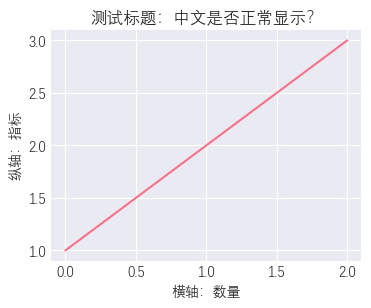

In [4]:
from matplotlib import font_manager
font_manager.fontManager.addfont(r"Deng.ttf")

# 强制指定字体（关键！）
plt.rcParams['font.sans-serif'] = ['DengXian']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False


plt.figure(figsize=(4,3))
plt.title("测试标题：中文是否正常显示？")
plt.xlabel("横轴：数量")
plt.ylabel("纵轴：指标")
plt.plot([1,2,3])
plt.show()


## Cell 2: 全局超参数配置

In [5]:
# ========== Cell 2: 全局超参数配置 ==========
"""
📌 参数调优指南:
   - 想要检测到更多趋势 → 降低 THR_ER_LOW, THR_CHOP_HIGH, 提高 THR_ER_HIGH
   - 想要更严格的趋势判定 → 提高 THR_ER_HIGH, 降低 THR_CHOP_LOW
   - Al Brooks 80/20 规则: 约80%时间在震荡区间，20%时间在趋势中

⚡ 快速调参: 只修改这个 Cell，然后重新运行后续所有 Cell 即可
"""

# ═══════════════════════════════════════════════════════════════════════════════
# 📊 基础计算参数
# ═══════════════════════════════════════════════════════════════════════════════
N_ATR = 20          # ATR 计算周期 (5min K线, 20根≈100分钟)
                    #   ↓ 减小: ATR 更敏感，波动估计更及时但更noisy
                    #   ↑ 增大: ATR 更稳定，但对突发波动反应慢

N_ER = 20           # ER 效率因子窗口 (与 Brooks 20-bar 规则一致)
                    #   ↓ 减小: 更快检测到趋势开始，但可能产生更多假信号
                    #   ↑ 增大: 趋势判断更可靠，但会错过趋势初期

L_BACK = 20         # 回看窗口 (用于线性回归、震荡度等)

# ═══════════════════════════════════════════════════════════════════════════════
# 📈 KAMA (Kaufman Adaptive Moving Average) 参数
# ═══════════════════════════════════════════════════════════════════════════════
KAMA_N_ER = 10      # KAMA 内部的 ER 计算窗口
                    #   ↓ 减小: KAMA 对趋势变化更敏感
                    #   ↑ 增大: KAMA 更平滑

KAMA_FAST = 2       # 快速 EMA 周期 (趋势强时使用)
KAMA_SLOW = 30      # 慢速 EMA 周期 (震荡时使用)
KAMA_SLOPE_LAG = 5  # KAMA 斜率计算滞后 (用几根bar计算斜率)

# ═══════════════════════════════════════════════════════════════════════════════
# 🎯 Triple Barrier 参数 (方向确认)
# ═══════════════════════════════════════════════════════════════════════════════
T_VERT = 12         # 垂直时间障碍 (12根5min≈1小时)
                    #   ↓ 减小: 只看短期方向，更适合短线
                    #   ↑ 增大: 看更长期方向，趋势判断更稳健

PT_MULT = 1.5       # 止盈倍数 (相对ATR)
                    #   ↓ 减小: 更容易触发方向标签，检测到更多趋势
                    #   ↑ 增大: 只有强势行情才给方向标签

SL_MULT = 1.5       # 止损倍数 (相对ATR)，通常与 PT_MULT 相同

# ═══════════════════════════════════════════════════════════════════════════════
# 🔴 震荡区间判定参数 (严格条件，需同时满足多个)
# ═══════════════════════════════════════════════════════════════════════════════
L_RANGE = 10        # 区间窗口 (前后各多少根bar)
L_RANGE_FWD = 10    # 未来窗口 (用于判断是否仍在区间)

THR_ER_LOW = 0.25   # 【关键】ER < 此值视为震荡
                    #   ↓ 减小(如0.2): 更严格，只有极度震荡才标为区间 → 趋势比例↑
                    #   ↑ 增大(如0.4): 更宽松，更多bar标为震荡区间 → 震荡比例↑

THR_CHOP_HIGH = 0.75  # 【关键】chop > 此值视为震荡
                    #   ↓ 减小(如0.6): 更严格 → 趋势比例↑
                    #   ↑ 增大(如0.85): 更宽松 → 震荡比例↑

THR_RANGE_ATR = 3.5 # range/ATR < 此值视为窄区间
                    #   ↓ 减小: 需要更窄的区间才算震荡
                    #   ↑ 增大: 更宽的区间也可以算震荡

THR_R2_LOW = 0.25   # R² < 此值视为无明显线性趋势
                    #   ↓ 减小: 更宽松，允许稍有趋势性的区间
                    #   ↑ 增大: 更严格

THR_FUTURE_MOVE = 1.2  # 未来移动 < 此值*ATR 视为仍在区间
                    #   ↓ 减小: 更严格，需要价格几乎不动
                    #   ↑ 增大: 允许更大的未来移动仍算区间

# ═══════════════════════════════════════════════════════════════════════════════
# 🟢 趋势判定参数 (对非震荡区间的bar进行趋势判定)
# ═══════════════════════════════════════════════════════════════════════════════
THR_ER_HIGH = 0.35  # 【关键】ER > 此值开始考虑趋势
                    #   ↓ 减小(如0.3): 更容易被判定为趋势 → 趋势比例↑
                    #   ↑ 增大(如0.5): 需要更强的效率才给趋势标签 → 趋势比例↓

THR_CHOP_LOW = 0.55 # 【关键】chop < 此值开始考虑趋势
                    #   ↓ 减小(如0.4): 需要很低的震荡度才给趋势
                    #   ↑ 增大(如0.6): 中等震荡度也可以给趋势 → 趋势比例↑

THR_SLOPE_NORM = 0.015  # KAMA斜率标准化阈值 (每bar移动多少ATR)
                    #   ↓ 减小: 更容易满足斜率条件 → 趋势比例↑
                    #   ↑ 增大: 需要更陡的斜率才算趋势

THR_DIST_NORM = 0.4 # 价格偏离KAMA的标准化阈值
                    #   ↓ 减小: 更容易满足偏离条件 → 趋势比例↑
                    #   ↑ 增大: 需要更大的偏离才算趋势

L_FWD = 12          # 趋势确认的未来窗口 (约1小时)
                    #   用于验证当前斜率方向与未来走势是否一致

# ═══════════════════════════════════════════════════════════════════════════════
# 🔧 标签平滑参数
# ═══════════════════════════════════════════════════════════════════════════════
MIN_TREND_LEN = 4   # 最小趋势段长度 (太短的趋势段标为0)
                    #   ↓ 减小: 保留更短的趋势段 → 趋势比例↑
                    #   ↑ 增大: 过滤掉短趋势 → 震荡比例↑

MIN_RANGE_LEN = 15  # 最小震荡区间长度 (Brooks原始为20)
                    #   ↓ 减小: 更短的震荡也保留 → 震荡比例↑
                    #   ↑ 增大: 只保留长震荡 → 趋势比例↑

SMOOTH_WINDOW = 5   # 平滑窗口 (多数投票)

# ═══════════════════════════════════════════════════════════════════════════════
# 📋 打印当前配置
# ═══════════════════════════════════════════════════════════════════════════════
print("=" * 70)
print("📊 当前参数配置")
print("=" * 70)
print(f"\n【基础参数】")
print(f"  ATR周期: {N_ATR}, ER窗口: {N_ER}, 回看窗口: {L_BACK}")
print(f"\n【KAMA参数】")
print(f"  n_er={KAMA_N_ER}, fast={KAMA_FAST}, slow={KAMA_SLOW}, slope_lag={KAMA_SLOPE_LAG}")
print(f"\n【Triple Barrier】")
print(f"  T_vert={T_VERT} (~{T_VERT*5}分钟), pt_mult={PT_MULT}, sl_mult={SL_MULT}")
print(f"\n【震荡区间判定】 (需同时满足)")
print(f"  ER < {THR_ER_LOW}, chop > {THR_CHOP_HIGH}, range_atr < {THR_RANGE_ATR}")
print(f"  R² < {THR_R2_LOW}, future_move < {THR_FUTURE_MOVE}*ATR")
print(f"\n【趋势判定】 (满足部分条件)")
print(f"  ER > {THR_ER_HIGH} 或 chop < {THR_CHOP_LOW}")
print(f"  slope_norm > {THR_SLOPE_NORM}, dist_norm > {THR_DIST_NORM}")
print(f"\n【标签平滑】")
print(f"  最小趋势长度: {MIN_TREND_LEN}, 最小震荡长度: {MIN_RANGE_LEN}, 平滑窗口: {SMOOTH_WINDOW}")
print("=" * 70)

print("\n✅ Cell 2 完成: 参数配置 (修改后重新运行后续Cell即可)")


📊 当前参数配置

【基础参数】
  ATR周期: 20, ER窗口: 20, 回看窗口: 20

【KAMA参数】
  n_er=10, fast=2, slow=30, slope_lag=5

【Triple Barrier】
  T_vert=12 (~60分钟), pt_mult=1.5, sl_mult=1.5

【震荡区间判定】 (需同时满足)
  ER < 0.25, chop > 0.75, range_atr < 3.5
  R² < 0.25, future_move < 1.2*ATR

【趋势判定】 (满足部分条件)
  ER > 0.35 或 chop < 0.55
  slope_norm > 0.015, dist_norm > 0.4

【标签平滑】
  最小趋势长度: 4, 最小震荡长度: 15, 平滑窗口: 5

✅ Cell 2 完成: 参数配置 (修改后重新运行后续Cell即可)


## Cell 3: 加载并合并 5min K线数据

In [6]:
# ========== Cell 3: 加载并合并 5min K线数据 ==========

# 获取所有 ES 5min K线文件
five_min_files = sorted(DATA_DIR_FUTURE.glob("ES_5min_rth_*.csv"))
print(f"找到的 5min K线文件数量: {len(five_min_files)}")

if not five_min_files:
    raise FileNotFoundError(f"在目录 {DATA_DIR_FUTURE} 下未找到 ES_5min_rth_*.csv 文件")

dfs = []
for f in five_min_files:
    print(f"读取: {f.name}")
    df_year = pd.read_csv(f)

    # 检查必要列
    required_cols = {"timestamp", "open", "high", "low", "close", "volume"}
    missing_cols = required_cols - set(df_year.columns)
    if missing_cols:
        raise ValueError(f"文件 {f.name} 缺少必要列: {missing_cols}")

    # 转换时间戳
    df_year["timestamp"] = pd.to_datetime(df_year["timestamp"], errors="coerce")
    df_year = df_year.sort_values("timestamp")
    dfs.append(df_year)

# 合并所有年份
df = pd.concat(dfs, ignore_index=True)
df = df.sort_values("timestamp").reset_index(drop=True)
df = df.set_index("timestamp")

# 确保数值列类型正确
for col in ["open", "high", "low", "close", "volume"]:
    df[col] = df[col].astype(float)

print(f"\n=== df 基本信息 ===")
print(f"Shape: {df.shape}")
print(f"时间范围: {df.index.min()} ~ {df.index.max()}")
print(f"重复时间戳数量: {df.index.duplicated().sum()}")

# 检查缺失值
missing = df.isnull().sum()
if missing.sum() > 0:
    print(f"\n存在缺失值:\n{missing[missing > 0]}")
else:
    print("\n无缺失值")

display(df.head())
print("\nCell 3 完成: 数据加载完毕 ✅")


找到的 5min K线文件数量: 16
读取: ES_5min_rth_2010.csv
读取: ES_5min_rth_2011.csv
读取: ES_5min_rth_2012.csv
读取: ES_5min_rth_2013.csv
读取: ES_5min_rth_2014.csv
读取: ES_5min_rth_2015.csv
读取: ES_5min_rth_2016.csv
读取: ES_5min_rth_2017.csv
读取: ES_5min_rth_2018.csv
读取: ES_5min_rth_2019.csv
读取: ES_5min_rth_2020.csv
读取: ES_5min_rth_2021.csv
读取: ES_5min_rth_2022.csv
读取: ES_5min_rth_2023.csv
读取: ES_5min_rth_2024.csv
读取: ES_5min_rth_2025.csv

=== df 基本信息 ===
Shape: (309412, 5)
时间范围: 2010-06-07 09:30:00-04:00 ~ 2025-11-26 16:00:00-05:00
重复时间戳数量: 0

无缺失值


,open,high,low,close,volume
timestamp,,,,,
2010-06-07 09:30:00-04:00,1066.75,1068.25,1065.00,1065.25,45516.0
2010-06-07 09:35:00-04:00,1065.25,1066.50,1063.50,1064.25,46783.0
2010-06-07 09:40:00-04:00,1064.25,1064.50,1061.50,1061.50,55016.0
2010-06-07 09:45:00-04:00,1061.50,1065.00,1060.50,1064.50,46708.0
2010-06-07 09:50:00-04:00,1064.75,1067.50,1063.75,1067.50,43551.0



Cell 3 完成: 数据加载完毕 ✅


## Cell 4: 数据预处理 - 基础序列计算

In [7]:
# ========== Cell 4: 数据预处理 - 基础序列计算 ==========

df = df.copy()

# 1. 对数收益 (log return)
# r_t = ln(C_t) - ln(C_{t-1})
df["log_close"] = np.log(df["close"])
df["log_return"] = df["log_close"].diff()

# 2. 真实波动范围 (True Range) 和 ATR
# TR_t = max(H_t - L_t, |H_t - C_{t-1}|, |L_t - C_{t-1}|)
prev_close = df["close"].shift(1)
tr1 = df["high"] - df["low"]
tr2 = np.abs(df["high"] - prev_close)
tr3 = np.abs(df["low"] - prev_close)
df["tr"] = np.maximum(np.maximum(tr1, tr2), tr3)

# ATR 使用 EMA
df["atr"] = df["tr"].ewm(span=N_ATR, adjust=False).mean()

# 3. 滚动高低价区间
df["roll_max"] = df["close"].rolling(window=L_BACK).max()
df["roll_min"] = df["close"].rolling(window=L_BACK).min()
df["roll_range"] = df["roll_max"] - df["roll_min"]

# 4. 相对区间 (range / ATR)
df["range_atr"] = df["roll_range"] / df["atr"].replace(0, np.nan)

print("=== 基础序列计算完成 ===")
print(f"log_return: mean={df['log_return'].mean():.6f}, std={df['log_return'].std():.6f}")
print(f"ATR: mean={df['atr'].mean():.4f}, std={df['atr'].std():.4f}")
print(f"range_atr: mean={df['range_atr'].mean():.4f}, std={df['range_atr'].std():.4f}")

display(df[["open", "high", "low", "close", "log_return", "tr", "atr", "range_atr"]].tail(10))
print("\nCell 4 完成 ✅")


=== 基础序列计算完成 ===
log_return: mean=0.000006, std=0.001216
ATR: mean=3.6985, std=3.3360
range_atr: mean=3.7565, std=1.5626


,open,high,low,close,log_return,tr,atr,range_atr
timestamp,,,,,,,,
2025-11-26 15:15:00-05:00,6843.50,6845.25,6840.75,6840.75,-0.000365,4.50,5.186093,3.181586
2025-11-26 15:20:00-05:00,6841.00,6844.00,6841.00,6842.00,0.000183,3.25,5.001703,2.299217
2025-11-26 15:25:00-05:00,6842.25,6843.00,6840.50,6841.00,-0.000146,2.50,4.763445,2.414219
2025-11-26 15:30:00-05:00,6841.25,6842.75,6838.00,6841.00,0.000000,4.75,4.762165,2.152382
2025-11-26 15:35:00-05:00,6841.00,6841.50,6838.75,6840.25,-0.000110,2.75,4.570530,2.187930
2025-11-26 15:40:00-05:00,6840.25,6843.00,6838.75,6840.50,0.000037,4.25,4.540003,2.202642
2025-11-26 15:45:00-05:00,6840.75,6842.75,6835.25,6835.50,-0.000731,7.50,4.821908,1.710941
2025-11-26 15:50:00-05:00,6835.50,6839.25,6831.00,6832.00,-0.000512,8.25,5.148393,2.185148
2025-11-26 15:55:00-05:00,6831.75,6834.00,6825.25,6825.25,-0.000988,8.75,5.491403,3.277851



Cell 4 完成 ✅


## Cell 5: KAMA 与 ER (效率因子) 计算

=== KAMA & ER 计算完成 ===
ER: mean=0.2388, median=0.2069
KAMA斜率标准化: mean=0.0147, std=0.1854
价格偏离度: mean=0.0971, std=1.1013


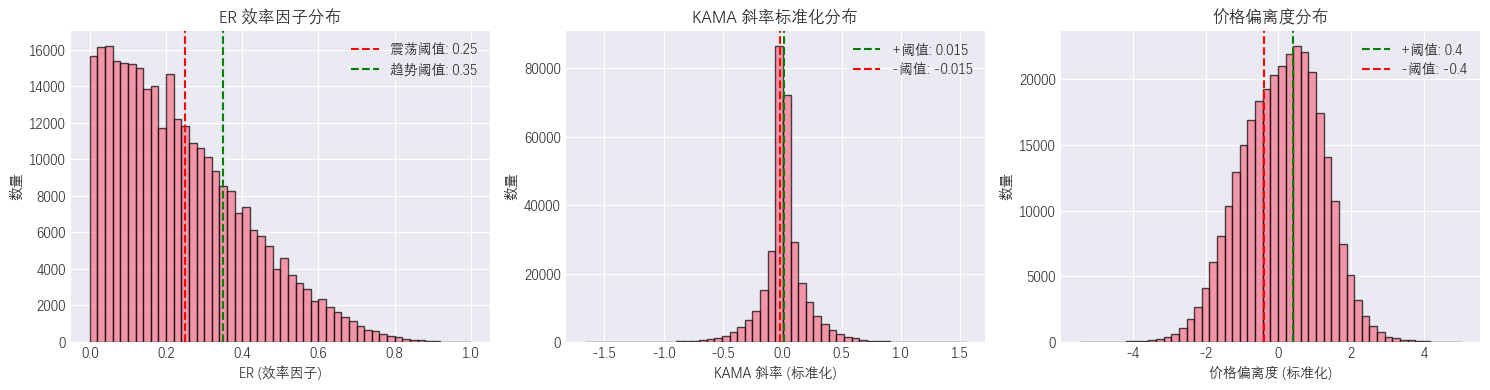


Cell 5 完成 ✅


In [ ]:
# ========== Cell 5: KAMA 与 ER (效率因子) 计算 ==========

def calc_efficiency_ratio(close: pd.Series, n: int) -> pd.Series:
    """
    计算效率因子 ER (Efficiency Ratio)

    ER_t = |C_t - C_{t-n}| / sum(|C_i - C_{i-1}|, i=t-n+1 to t)

    ER → 1: 价格几乎"走直线"，趋势干净
    ER → 0: 大量来回震荡，典型交易区间
    """
    change = (close - close.shift(n)).abs()
    volatility = close.diff().abs().rolling(window=n).sum()
    er = change / volatility.replace(0, np.nan)
    return er.clip(0, 1)


def calc_kama(close: pd.Series, n_er: int, fast: int, slow: int) -> pd.Series:
    """
    计算 KAMA (Kaufman Adaptive Moving Average)

    SC (Smoothing Constant) = [ER * (fast_sc - slow_sc) + slow_sc]^2
    KAMA_t = KAMA_{t-1} + SC * (Close_t - KAMA_{t-1})
    """
    # 计算 ER
    er = calc_efficiency_ratio(close, n_er)

    # 平滑常数
    fast_sc = 2 / (fast + 1)
    slow_sc = 2 / (slow + 1)
    sc = (er * (fast_sc - slow_sc) + slow_sc) ** 2

    # 初始化 KAMA
    kama = np.zeros(len(close))
    kama[:] = np.nan

    # 找第一个非 NaN 的 SC 位置
    first_valid = sc.first_valid_index()
    if first_valid is None:
        return pd.Series(kama, index=close.index)

    first_idx = close.index.get_loc(first_valid)

    # 用 SMA 初始化
    kama[first_idx] = close.iloc[:first_idx + 1].mean()

    # 递归计算
    close_arr = close.values
    sc_arr = sc.values
    for i in range(first_idx + 1, len(close)):
        if np.isnan(sc_arr[i]):
            kama[i] = kama[i - 1]
        else:
            kama[i] = kama[i - 1] + sc_arr[i] * (close_arr[i] - kama[i - 1])

    return pd.Series(kama, index=close.index)


# 计算 ER (使用全局 N_ER 参数)
df["er"] = calc_efficiency_ratio(df["close"], N_ER)

# 计算 KAMA
df["kama"] = calc_kama(df["close"], KAMA_N_ER, KAMA_FAST, KAMA_SLOW)

# 计算 KAMA 斜率 (使用 KAMA_SLOPE_LAG)
df["kama_slope"] = (df["kama"] - df["kama"].shift(KAMA_SLOPE_LAG)) / KAMA_SLOPE_LAG

# 斜率标准化 (相对 ATR)
# slope_norm_t = slope_t / ATR_t
df["slope_norm"] = df["kama_slope"] / df["atr"].replace(0, np.nan)

# 价格偏离度 (相对 ATR)
# dist_norm_t = (C_t - KAMA_t) / ATR_t
df["dist_norm"] = (df["close"] - df["kama"]) / df["atr"].replace(0, np.nan)

print("=== KAMA & ER 计算完成 ===")
print(f"ER: mean={df['er'].mean():.4f}, median={df['er'].median():.4f}")
print(f"KAMA斜率标准化: mean={df['slope_norm'].mean():.4f}, std={df['slope_norm'].std():.4f}")
print(f"价格偏离度: mean={df['dist_norm'].mean():.4f}, std={df['dist_norm'].std():.4f}")

plt.rcParams['font.sans-serif'] = ['DengXian']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

# ER 分布直方图
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df["er"].dropna(), bins=50, edgecolor="black", alpha=0.7)
axes[0].axvline(x=THR_ER_LOW, color="red", linestyle="--", label=f"震荡阈值: {THR_ER_LOW}")
axes[0].axvline(x=THR_ER_HIGH, color="green", linestyle="--", label=f"趋势阈值: {THR_ER_HIGH}")
axes[0].set_xlabel("ER (效率因子)")
axes[0].set_ylabel("数量")
axes[0].set_title("ER 效率因子分布")
axes[0].legend()

axes[1].hist(df["slope_norm"].dropna(), bins=50, edgecolor="black", alpha=0.7)
axes[1].axvline(x=THR_SLOPE_NORM, color="green", linestyle="--", label=f"+阈值: {THR_SLOPE_NORM}")
axes[1].axvline(x=-THR_SLOPE_NORM, color="red", linestyle="--", label=f"-阈值: -{THR_SLOPE_NORM}")
axes[1].set_xlabel("KAMA 斜率 (标准化)")
axes[1].set_ylabel("数量")
axes[1].set_title("KAMA 斜率标准化分布")
axes[1].legend()

axes[2].hist(df["dist_norm"].dropna(), bins=50, edgecolor="black", alpha=0.7)
axes[2].axvline(x=THR_DIST_NORM, color="green", linestyle="--", label=f"+阈值: {THR_DIST_NORM}")
axes[2].axvline(x=-THR_DIST_NORM, color="red", linestyle="--", label=f"-阈值: -{THR_DIST_NORM}")
axes[2].set_xlabel("价格偏离度 (标准化)")
axes[2].set_ylabel("数量")
axes[2].set_title("价格偏离度分布")
axes[2].legend()

plt.tight_layout()
plt.show()

print("\nCell 5 完成 ✅")


##  Cell 6: 本地结构/震荡度特征

计算滚动线性回归...
计算震荡度 (Choppiness Index)...

=== 本地结构特征计算完成 ===
Beta (斜率): mean=0.000006, std=0.000281
R² (拟合度): mean=0.4350, median=0.4468
Chop (Choppiness Index): mean=0.5057, median=0.5133
Overlap Ratio (重叠度): mean=0.6000, median=0.6008


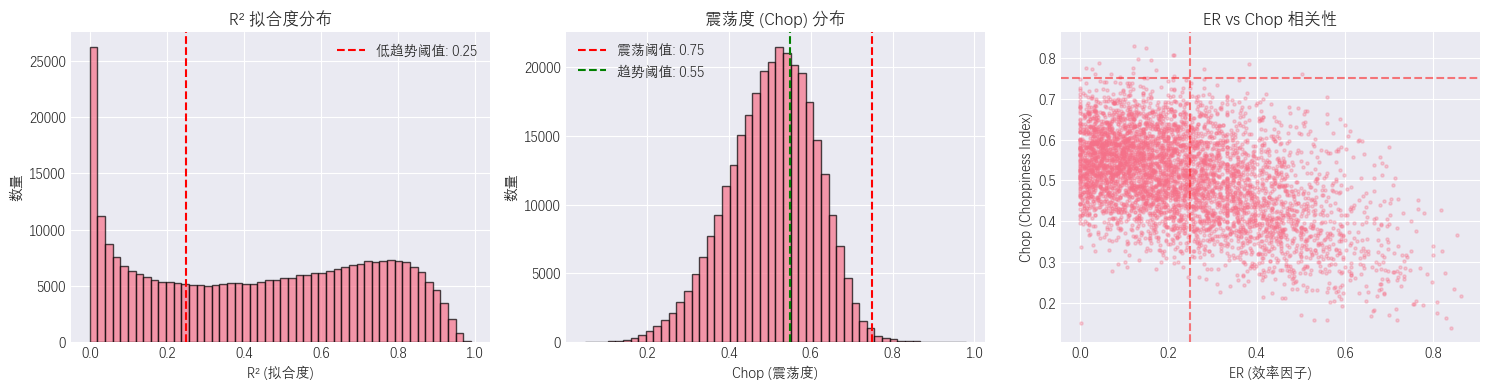


ER vs Chop 相关系数: -0.4787 (应该不再是 -1.0)
ER vs Overlap Ratio 相关系数: -0.1677

Cell 6 完成 ✅


In [ ]:
# ========== Cell 6: 本地结构/震荡度特征 ==========

def rolling_linreg(y: np.ndarray, window: int) -> tuple:
    """
    对 y 序列做滚动线性回归，返回 (斜率, R²)
    使用简单的最小二乘法: y = beta * x + alpha
    x = [0, 1, 2, ..., window-1]
    """
    n = len(y)
    beta = np.full(n, np.nan)
    r2 = np.full(n, np.nan)

    x = np.arange(window)
    x_mean = x.mean()
    ss_x = ((x - x_mean) ** 2).sum()

    for i in range(window - 1, n):
        y_win = y[i - window + 1:i + 1]
        if np.any(np.isnan(y_win)):
            continue

        y_mean = y_win.mean()

        # 斜率
        ss_xy = ((x - x_mean) * (y_win - y_mean)).sum()
        b = ss_xy / ss_x if ss_x > 0 else 0

        # R²
        y_pred = b * (x - x_mean) + y_mean
        ss_res = ((y_win - y_pred) ** 2).sum()
        ss_tot = ((y_win - y_mean) ** 2).sum()
        r2_val = 1 - ss_res / ss_tot if ss_tot > 0 else 0

        beta[i] = b
        r2[i] = max(0, min(1, r2_val))  # clip to [0, 1]

    return beta, r2


# 1. 滚动线性回归 (对 log_close)
print("计算滚动线性回归...")
log_close_arr = df["log_close"].values
beta_arr, r2_arr = rolling_linreg(log_close_arr, L_BACK)

df["beta"] = beta_arr           # 斜率
df["r2"] = r2_arr               # R² (拟合程度)

# 2. 震荡度 (Choppiness Index - 基于ATR的标准定义)
# Choppiness Index = 100 * log10(sum(ATR_n) / (highest - lowest)) / log10(n)
# 这个定义与 ER 在数学上不完全等价，因为它使用 ATR 而非收盘价变动
print("计算震荡度 (Choppiness Index)...")

# 使用不同的窗口来避免与 ER 完美相关
CHOP_WINDOW = 14  # 标准 Choppiness Index 使用 14 周期

# 计算 ATR 的滚动和
atr_sum = df["tr"].rolling(window=CHOP_WINDOW).sum()

# 计算窗口内的高低点差
high_max = df["high"].rolling(window=CHOP_WINDOW).max()
low_min = df["low"].rolling(window=CHOP_WINDOW).min()
hl_range = high_max - low_min

# Choppiness Index (标准化到 0-1)
# 原始公式: 100 * log10(atr_sum / hl_range) / log10(n)
# 简化: chop = log10(atr_sum / hl_range) / log10(n)
# 值越高 = 越震荡, 值越低 = 越趋势
import math
df["chop"] = np.log10(atr_sum / hl_range.replace(0, np.nan)) / math.log10(CHOP_WINDOW)
df["chop"] = df["chop"].clip(0, 1)

# 补充: 添加一个基于 bar 重叠度的震荡指标 (与 ER 不同)
# 计算相邻 bar 的重叠程度
prev_high = df["high"].shift(1)
prev_low = df["low"].shift(1)
overlap = np.minimum(df["high"], prev_high) - np.maximum(df["low"], prev_low)
overlap = overlap.clip(lower=0)
bar_range = (df["high"] - df["low"] + prev_high - prev_low) / 2
df["overlap_ratio"] = (overlap / bar_range.replace(0, np.nan)).rolling(window=L_BACK).mean()
df["overlap_ratio"] = df["overlap_ratio"].clip(0, 1)

# 3. 验证: ER 与 chop 的关系
# 注意: 使用标准 Choppiness Index 定义后，ER 与 chop 不再完美负相关
# 高 ER -> 低 chop (趋势)
# 低 ER -> 高 chop (震荡)

print("\n=== 本地结构特征计算完成 ===")
print(f"Beta (斜率): mean={df['beta'].mean():.6f}, std={df['beta'].std():.6f}")
print(f"R² (拟合度): mean={df['r2'].mean():.4f}, median={df['r2'].median():.4f}")
print(f"Chop (Choppiness Index): mean={df['chop'].mean():.4f}, median={df['chop'].median():.4f}")
print(f"Overlap Ratio (重叠度): mean={df['overlap_ratio'].mean():.4f}, median={df['overlap_ratio'].median():.4f}")

plt.rcParams['font.sans-serif'] = ['DengXian']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

# ER vs Chop 散点图
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# R² 分布
axes[0].hist(df["r2"].dropna(), bins=50, edgecolor="black", alpha=0.7)
axes[0].axvline(x=THR_R2_LOW, color="red", linestyle="--", label=f"低趋势阈值: {THR_R2_LOW}")
axes[0].set_xlabel("R² (拟合度)")
axes[0].set_ylabel("数量")
axes[0].set_title("R² 拟合度分布")
axes[0].legend()

# Chop 分布
axes[1].hist(df["chop"].dropna(), bins=50, edgecolor="black", alpha=0.7)
axes[1].axvline(x=THR_CHOP_HIGH, color="red", linestyle="--", label=f"震荡阈值: {THR_CHOP_HIGH}")
axes[1].axvline(x=THR_CHOP_LOW, color="green", linestyle="--", label=f"趋势阈值: {THR_CHOP_LOW}")
axes[1].set_xlabel("Chop (震荡度)")
axes[1].set_ylabel("数量")
axes[1].set_title("震荡度 (Chop) 分布")
axes[1].legend()

# ER vs Chop 散点图 (采样以加速)
sample_idx = np.random.choice(len(df.dropna()), size=min(5000, len(df.dropna())), replace=False)
df_sample = df.dropna().iloc[sample_idx]
axes[2].scatter(df_sample["er"], df_sample["chop"], alpha=0.3, s=5)
axes[2].set_xlabel("ER (效率因子)")
axes[2].set_ylabel("Chop (Choppiness Index)")
axes[2].set_title("ER vs Chop 相关性")
axes[2].axvline(x=THR_ER_LOW, color="red", linestyle="--", alpha=0.5)
axes[2].axhline(y=THR_CHOP_HIGH, color="red", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

# 计算相关系数
corr_er_chop = df[["er", "chop"]].dropna().corr().iloc[0, 1]
corr_er_overlap = df[["er", "overlap_ratio"]].dropna().corr().iloc[0, 1]
print(f"\nER vs Chop 相关系数: {corr_er_chop:.4f} (应该不再是 -1.0)")
print(f"ER vs Overlap Ratio 相关系数: {corr_er_overlap:.4f}")

print("\nCell 6 完成 ✅")


## Cell 7: Triple Barrier 方向标签

计算 Triple Barrier 方向标签...
参数: T_vert=12, pt_mult=1.5, sl_mult=1.5

=== Triple Barrier 标签分布 ===
  DOWN (-1): 143694 (46.44%)
  NEUTRAL (0): 4898 (1.58%)
  UP (1): 160820 (51.98%)


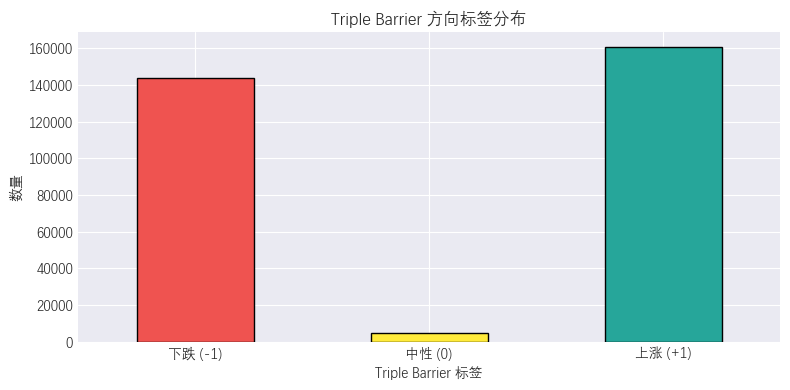


Cell 7 完成 ✅


In [8]:
# ========== Cell 7: Triple Barrier 方向标签 ==========

@njit
def triple_barrier_labels(close: np.ndarray, atr: np.ndarray,
                          t_vert: int, pt_mult: float, sl_mult: float) -> np.ndarray:
    """
    为每个 bar 计算 triple barrier 标签

    参数:
        close: 收盘价数组
        atr: ATR 数组
        t_vert: 垂直时间障碍 (最大持有时间)
        pt_mult: 止盈倍数 (相对 ATR)
        sl_mult: 止损倍数 (相对 ATR)

    返回:
        d: 方向标签数组 (-1, 0, 1)
           +1: 先触及上轨 (止盈)
           -1: 先触及下轨 (止损)
            0: 未触及任何轨道 (时间截止)
    """
    n = len(close)
    d = np.zeros(n, dtype=np.int32)

    for t in range(n):
        if np.isnan(atr[t]) or atr[t] <= 0:
            d[t] = 0
            continue

        c_t = close[t]
        upper = c_t + pt_mult * atr[t]  # 止盈上轨
        lower = c_t - sl_mult * atr[t]  # 止损下轨

        # 遍历未来路径
        hit_up = False
        hit_down = False
        first_hit_up = n + 1
        first_hit_down = n + 1

        for j in range(1, min(t_vert + 1, n - t)):
            future_close = close[t + j]

            if future_close >= upper and not hit_up:
                hit_up = True
                first_hit_up = j

            if future_close <= lower and not hit_down:
                hit_down = True
                first_hit_down = j

            if hit_up and hit_down:
                break

        # 判断哪个先触及
        if hit_up and hit_down:
            if first_hit_up < first_hit_down:
                d[t] = 1
            elif first_hit_down < first_hit_up:
                d[t] = -1
            else:
                d[t] = 0  # 同时触及，标为中性
        elif hit_up:
            d[t] = 1
        elif hit_down:
            d[t] = -1
        else:
            # 未触及任何轨道，用最终方向
            end_idx = min(t + t_vert, n - 1)
            if end_idx > t:
                final_move = close[end_idx] - c_t
                if final_move > 0:
                    d[t] = 1
                elif final_move < 0:
                    d[t] = -1
                else:
                    d[t] = 0
            else:
                d[t] = 0

    return d


# 计算 Triple Barrier 标签
print("计算 Triple Barrier 方向标签...")
print(f"参数: T_vert={T_VERT}, pt_mult={PT_MULT}, sl_mult={SL_MULT}")

close_arr = df["close"].values.astype(np.float64)
atr_arr = df["atr"].values.astype(np.float64)

df["d_barrier"] = triple_barrier_labels(close_arr, atr_arr, T_VERT, PT_MULT, SL_MULT)

# 统计分布
barrier_counts = df["d_barrier"].value_counts().sort_index()
print("\n=== Triple Barrier 标签分布 ===")
for k, v in barrier_counts.items():
    label_name = {-1: "DOWN", 0: "NEUTRAL", 1: "UP"}.get(k, str(k))
    print(f"  {label_name} ({k}): {v} ({v / len(df):.2%})")

plt.rcParams['font.sans-serif'] = ['DengXian']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

# 可视化
fig, ax = plt.subplots(figsize=(8, 4))
barrier_counts.plot(kind="bar", ax=ax, color=["#ef5350", "#ffeb3b", "#26a69a"], edgecolor="black")
ax.set_xlabel("Triple Barrier 标签")
ax.set_ylabel("数量")
ax.set_title("Triple Barrier 方向标签分布")
ax.set_xticklabels(["下跌 (-1)", "中性 (0)", "上涨 (+1)"], rotation=0)
plt.tight_layout()
plt.show()

print("\nCell 7 完成 ✅")


## Cell 7.5 Tripple Barrier Version2

计算 Triple Barrier 方向标签（R-barrier）...
参数: T_vert=12, pt_mult=1.5 (e.g., 0.5R), sl_mult=1.5 (e.g., 1R), tick=0.01, lookback=5

=== Triple Barrier 标签分布 ===
  DOWN (-1): 152968 (49.44%)
  NEUTRAL (0): 2147 (0.69%)
  UP (1): 154297 (49.87%)


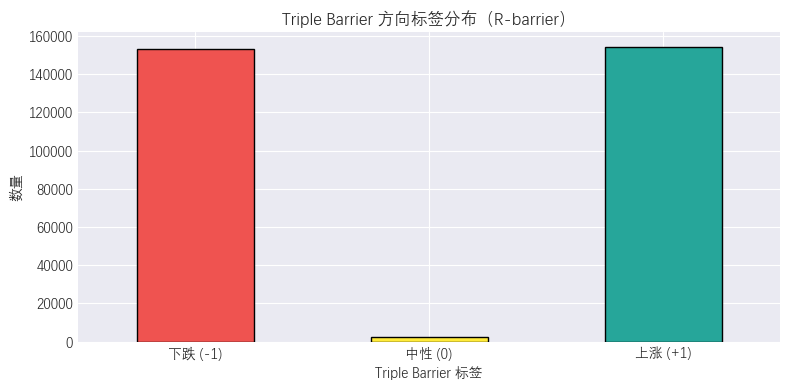


Cell 7.5 完成 ✅


In [11]:
# ========== Cell 7.5: Triple Barrier 方向标签（R-barrier 版） ==========

from numba import njit
import numpy as np
import matplotlib.pyplot as plt

TICK_SIZE = 0.01
LOOKBACK_N = 5

@njit
def triple_barrier_labels_R(
    high: np.ndarray,
    low: np.ndarray,
    close: np.ndarray,
    t_vert: int,
    pt_mult: float,
    sl_mult: float,
    tick_size: float,
    lookback: int
) -> np.ndarray:
    """
    为每个 bar 计算 triple barrier 标签（不用 ATR，用结构 R）

    结构止损线（多头）：
      - 若当前bar构成上涨微通道（Higher Lows: L[t-2] < L[t-1] < L[t]）
        SL_long = min(L[t-2], L[t-1], L[t]) - tick
      - 否则 fallback:
        SL_long = rolling_min(low, lookback) - tick

    结构止损线（空头）：
      SL_short = rolling_max(high, lookback) + tick
      （如果你后续也要“下跌微通道”，可以对称加进去）

    风险单位：
      R_long  = close[t] - SL_long
      R_short = SL_short - close[t]

    Barrier：
      upper = close[t] + pt_mult * R_long     # 例如 pt_mult=0.5 -> 0.5R
      lower = close[t] - sl_mult * R_short    # 例如 sl_mult=1.0 -> 1R 止损

    触线判定（更贴合“线”）：
      hit_up   用 future_high >= upper
      hit_down 用 future_low  <= lower

    返回:
      d[t] ∈ {-1,0,1}
        +1: 先触及 upper
        -1: 先触及 lower
         0: 时间截止仍未触及（用最终方向兜底）
    """
    n = len(close)
    d = np.zeros(n, dtype=np.int32)

    for t in range(n):
        c_t = close[t]

        # ---------- 1) 多头结构止损线：微通道优先，否则 fallback ----------
        # fallback：过去 lookback 根（含当前）最低点
        start = t - lookback + 1
        if start < 0:
            start = 0
        mn_low = low[start]
        mx_high = high[start]
        for i in range(start + 1, t + 1):
            if low[i] < mn_low:
                mn_low = low[i]
            if high[i] > mx_high:
                mx_high = high[i]

        sl_long = mn_low - tick_size

        # 微通道（上涨）：L[t-2] < L[t-1] < L[t]，且 t>=2
        if t >= 2:
            l1 = low[t - 2]
            l2 = low[t - 1]
            l3 = low[t]
            if (l1 < l2) and (l2 < l3):
                # 通道下沿 = 三根里最低 low
                mc_low = l1
                if l2 < mc_low:
                    mc_low = l2
                if l3 < mc_low:
                    mc_low = l3
                sl_long = mc_low - tick_size

        # ---------- 2) 空头结构止损线：用结构高点（rolling max） ----------
        sl_short = mx_high + tick_size

        # ---------- 3) 计算 R ----------
        R_long = c_t - sl_long
        R_short = sl_short - c_t

        # 防御：极端情况下 R<=0 直接中性
        if (R_long <= 0.0) or (R_short <= 0.0):
            d[t] = 0
            continue

        # ---------- 4) barrier ----------
        upper = c_t + pt_mult * R_long
        lower = c_t - sl_mult * R_short

        # ---------- 5) 向前看 t_vert，判断谁先触线 ----------
        hit_up = False
        hit_down = False
        first_up = n + 1
        first_dn = n + 1

        max_j = t_vert
        if t + max_j >= n:
            max_j = n - 1 - t

        for j in range(1, max_j + 1):
            fh = high[t + j]
            fl = low[t + j]

            if (not hit_up) and (fh >= upper):
                hit_up = True
                first_up = j
            if (not hit_down) and (fl <= lower):
                hit_down = True
                first_dn = j

            if hit_up and hit_down:
                break

        if hit_up and hit_down:
            if first_up < first_dn:
                d[t] = 1
            elif first_dn < first_up:
                d[t] = -1
            else:
                d[t] = 0
        elif hit_up:
            d[t] = 1
        elif hit_down:
            d[t] = -1
        else:
            # 时间到：用最终方向兜底
            end_idx = t + max_j
            final_move = close[end_idx] - c_t
            if final_move > 0:
                d[t] = 1
            elif final_move < 0:
                d[t] = -1
            else:
                d[t] = 0

    return d


# ====== 计算 Triple Barrier 标签（R-barrier） ======
print("计算 Triple Barrier 方向标签（R-barrier）...")
print(f"参数: T_vert={T_VERT}, pt_mult={PT_MULT} (e.g., 0.5R), sl_mult={SL_MULT} (e.g., 1R), "
      f"tick={TICK_SIZE}, lookback={LOOKBACK_N}")

high_arr  = df["high"].values.astype(np.float64)
low_arr   = df["low"].values.astype(np.float64)
close_arr = df["close"].values.astype(np.float64)

df["d_barrier"] = triple_barrier_labels_R(
    high_arr, low_arr, close_arr,
    T_VERT, PT_MULT, SL_MULT,
    TICK_SIZE, LOOKBACK_N
)

# 统计分布
barrier_counts = df["d_barrier"].value_counts().sort_index()
print("\n=== Triple Barrier 标签分布 ===")
for k, v in barrier_counts.items():
    label_name = {-1: "DOWN", 0: "NEUTRAL", 1: "UP"}.get(k, str(k))
    print(f"  {label_name} ({k}): {v} ({v / len(df):.2%})")

plt.rcParams['font.sans-serif'] = ['DengXian']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

# 可视化
fig, ax = plt.subplots(figsize=(8, 4))
barrier_counts.plot(kind="bar", ax=ax, color=["#ef5350", "#ffeb3b", "#26a69a"], edgecolor="black")
ax.set_xlabel("Triple Barrier 标签")
ax.set_ylabel("数量")
ax.set_title("Triple Barrier 方向标签分布（R-barrier）")
ax.set_xticklabels(["下跌 (-1)", "中性 (0)", "上涨 (+1)"], rotation=0)
plt.tight_layout()
plt.show()

print("\nCell 7.5 完成 ✅")


## Cell 8: 市场周期标签 - Step 1: 识别震荡区间

In [ ]:
# ========== Cell 8: 市场周期标签 - Step 1: 识别震荡区间 ==========

def identify_trading_range(df: pd.DataFrame,
                           thr_er_low: float,
                           thr_chop_high: float,
                           thr_range_atr: float,
                           thr_r2_low: float,
                           thr_future_move: float,
                           l_range_fwd: int) -> np.ndarray:
    """
    识别震荡/交易区间

    判定条件 (满足所有条件):
    1. ER < thr_er_low (效率低, 来回震荡)
    2. chop > thr_chop_high (震荡度高)
    3. range_atr < thr_range_atr (区间相对窄)
    4. R² < thr_r2_low (无明显线性趋势)
    5. 未来移动 < thr_future_move * ATR (仍在区间内)

    返回:
        is_range: bool 数组, True 表示该 bar 处于交易区间
    """
    n = len(df)
    is_range = np.zeros(n, dtype=bool)

    er = df["er"].values
    chop = df["chop"].values
    range_atr = df["range_atr"].values
    r2 = df["r2"].values
    close = df["close"].values
    atr = df["atr"].values

    for t in range(n):
        # 检查基本条件
        if np.isnan(er[t]) or np.isnan(chop[t]) or np.isnan(range_atr[t]) or np.isnan(r2[t]):
            continue
        if np.isnan(atr[t]) or atr[t] <= 0:
            continue

        cond_er = er[t] < thr_er_low
        cond_chop = chop[t] > thr_chop_high
        cond_range = range_atr[t] < thr_range_atr
        cond_r2 = r2[t] < thr_r2_low

        # 检查未来移动 (利用少量未来信息)
        future_idx = min(t + l_range_fwd, n - 1)
        if future_idx > t:
            future_move = abs(close[future_idx] - close[t])
            cond_future = future_move < thr_future_move * atr[t]
        else:
            cond_future = True

        # 震荡区间判定: 满足 ER + chop 条件 AND (range 或 R² 或 future move)
        if cond_er and cond_chop and (cond_range or cond_r2 or cond_future):
            is_range[t] = True

    return is_range


# 计算初步的震荡区间标记
print("识别震荡/交易区间...")
is_range = identify_trading_range(
    df,
    thr_er_low=THR_ER_LOW,
    thr_chop_high=THR_CHOP_HIGH,
    thr_range_atr=THR_RANGE_ATR,
    thr_r2_low=THR_R2_LOW,
    thr_future_move=THR_FUTURE_MOVE,
    l_range_fwd=L_RANGE_FWD
)

df["is_range_raw"] = is_range

# 统计
range_count = is_range.sum()
print(f"\n初步震荡区间 bar 数量: {range_count} ({range_count / len(df):.2%})")

# 应用最小长度约束 (Brooks 20-bar rule)
# 只有连续 >= MIN_RANGE_LEN 个 bar 都是震荡区间，才确认为震荡
def apply_min_length_constraint(arr: np.ndarray, min_len: int, value: bool) -> np.ndarray:
    """
    对连续段应用最小长度约束
    """
    result = arr.copy()
    n = len(arr)
    i = 0

    while i < n:
        if arr[i] == value:
            # 找连续段的结束
            j = i + 1
            while j < n and arr[j] == value:
                j += 1

            seg_len = j - i
            if seg_len < min_len:
                # 太短，取消标记
                result[i:j] = not value

            i = j
        else:
            i += 1

    return result


# 应用最小长度约束
is_range_filtered = apply_min_length_constraint(is_range, MIN_RANGE_LEN, True)
df["is_range"] = is_range_filtered

range_count_filtered = is_range_filtered.sum()
print(f"过滤后震荡区间 bar 数量 (min_len={MIN_RANGE_LEN}): {range_count_filtered} ({range_count_filtered / len(df):.2%})")

# 扩展边缘 (前后各 2-3 bar)
EDGE_EXTEND = 2

def extend_range_edges(arr: np.ndarray, extend: int) -> np.ndarray:
    """
    对震荡区间的边缘进行扩展
    """
    result = arr.copy()
    n = len(arr)

    for i in range(n):
        if arr[i]:
            # 向前扩展
            for k in range(1, extend + 1):
                if i - k >= 0:
                    result[i - k] = True
            # 向后扩展
            for k in range(1, extend + 1):
                if i + k < n:
                    result[i + k] = True

    return result


is_range_extended = extend_range_edges(is_range_filtered, EDGE_EXTEND)
df["is_range_extended"] = is_range_extended

range_count_extended = is_range_extended.sum()
print(f"扩展边缘后震荡区间 bar 数量 (extend={EDGE_EXTEND}): {range_count_extended} ({range_count_extended / len(df):.2%})")

print("\nCell 8 完成 ✅")


识别震荡/交易区间...

初步震荡区间 bar 数量: 1090 (0.35%)
过滤后震荡区间 bar 数量 (min_len=15): 272 (0.09%)
扩展边缘后震荡区间 bar 数量 (extend=2): 312 (0.10%)

Cell 8 完成 ✅


## Cell 9: 市场周期标签 - Step 2: 识别趋势

In [ ]:
# ========== Cell 9: 市场周期标签 - Step 2: 识别趋势 ==========

def identify_trend(df: pd.DataFrame,
                   is_range: np.ndarray,
                   thr_er_high: float,
                   thr_chop_low: float,
                   thr_slope_norm: float,
                   thr_dist_norm: float,
                   l_fwd: int) -> np.ndarray:
    """
    识别趋势 (对非震荡区间的 bar)

    趋势判定条件:
    1. 方向一致性: sign(slope_norm) == sign(未来收益)
    2. 斜率强度: |slope_norm| > thr_slope_norm
    3. 效率/趋势性: ER > thr_er_high 或 chop < thr_chop_low
    4. 价格偏离: |dist_norm| > thr_dist_norm (可选)
    5. Triple barrier 方向确认

    返回:
        regime: 标签数组 (-1, 0, 1)
    """
    n = len(df)
    regime = np.zeros(n, dtype=np.int32)

    close = df["close"].values
    er = df["er"].values
    chop = df["chop"].values
    slope_norm = df["slope_norm"].values
    dist_norm = df["dist_norm"].values
    d_barrier = df["d_barrier"].values

    for t in range(n):
        # 如果已被标记为震荡区间，直接设为 0
        if is_range[t]:
            regime[t] = 0
            continue

        # 检查特征是否有效
        if (np.isnan(er[t]) or np.isnan(chop[t]) or
            np.isnan(slope_norm[t]) or np.isnan(dist_norm[t])):
            regime[t] = 0
            continue

        # 检查未来收益方向
        future_idx = min(t + l_fwd, n - 1)
        if future_idx > t:
            future_return = close[future_idx] - close[t]
            future_direction = np.sign(future_return)
        else:
            future_direction = 0

        # 趋势候选条件
        slope_direction = np.sign(slope_norm[t])

        # 条件1: 方向一致性
        direction_consistent = (slope_direction == future_direction) and (slope_direction != 0)

        # 条件2: 斜率强度
        slope_strong = abs(slope_norm[t]) > thr_slope_norm

        # 条件3: 效率/趋势性 (满足其一即可)
        trend_quality = (er[t] > thr_er_high) or (chop[t] < thr_chop_low)

        # 条件4: 价格偏离 (可选加强条件)
        price_deviated = abs(dist_norm[t]) > thr_dist_norm

        # 综合判定
        # 必须满足: 方向一致 + 斜率强度 + (趋势质量 或 价格偏离)
        is_trend = direction_consistent and slope_strong and (trend_quality or price_deviated)

        if is_trend:
            # 再用 triple barrier 确认方向
            if d_barrier[t] == slope_direction:
                regime[t] = int(slope_direction)
            elif d_barrier[t] == 0:
                # barrier 无方向，但结构显示趋势，仍给趋势标签
                regime[t] = int(slope_direction)
            else:
                # barrier 方向与结构不一致，标为模糊 (0)
                regime[t] = 0
        else:
            regime[t] = 0

    return regime


# 识别趋势
print("识别趋势...")
regime_raw = identify_trend(
    df,
    is_range=df["is_range_extended"].values,
    thr_er_high=THR_ER_HIGH,
    thr_chop_low=THR_CHOP_LOW,
    thr_slope_norm=THR_SLOPE_NORM,
    thr_dist_norm=THR_DIST_NORM,
    l_fwd=L_FWD
)

df["regime_raw"] = regime_raw

# 统计
regime_counts_raw = pd.Series(regime_raw).value_counts().sort_index()
print("\n=== 原始 Regime 标签分布 ===")
for k, v in regime_counts_raw.items():
    label_name = {-1: "DOWN (-1)", 0: "RANGE (0)", 1: "UP (+1)"}.get(k, str(k))
    print(f"  {label_name}: {v} ({v / len(df):.2%})")

print("\nCell 9 完成 ✅")


识别趋势...

=== 原始 Regime 标签分布 ===
  DOWN (-1): 42386 (13.70%)
  RANGE (0): 205402 (66.38%)
  UP (+1): 61624 (19.92%)

Cell 9 完成 ✅


## Cell 10: 市场周期标签 - Step 3: 标签平滑

标签平滑 (min_trend_len=4, smooth_window=5)...

=== 最终 Market Cycle 标签分布 ===
  DOWN (-1): 31,812 (10.28%)
  RANGE (0): 228,526 (73.86%)
  UP (+1): 49,074 (15.86%)

震荡区间比例: 73.86% (Al Brooks: ~80%)
趋势区间比例: 26.14% (Al Brooks: ~20%)


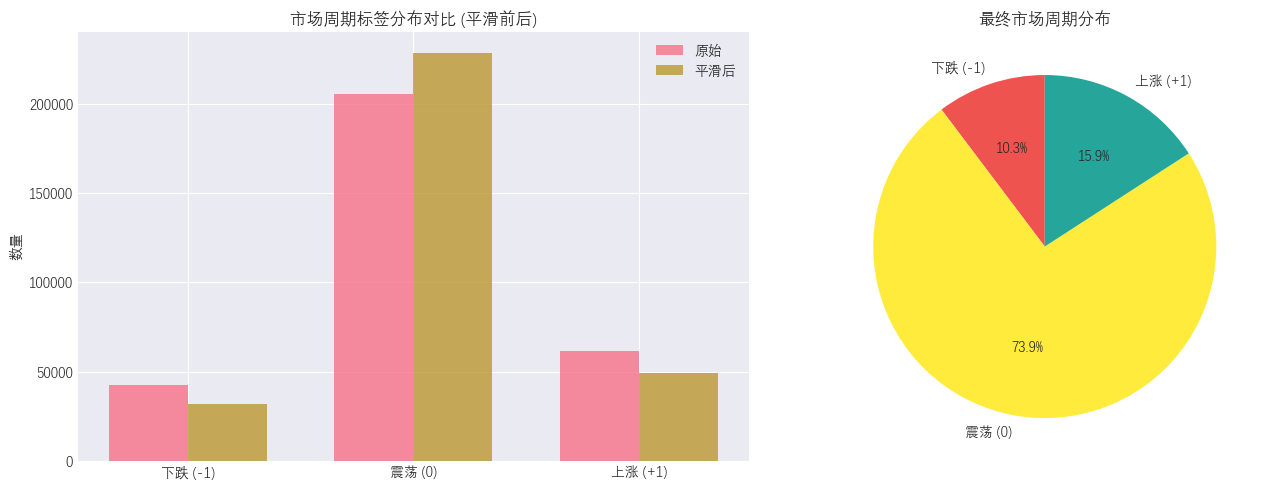


Cell 10 完成 ✅


In [ ]:
# ========== Cell 10: 市场周期标签 - Step 3: 标签平滑 ==========

def smooth_regime_labels(regime: np.ndarray,
                         min_trend_len: int,
                         smooth_window: int) -> np.ndarray:
    """
    对标签序列进行平滑处理

    步骤:
    1. 删除太短的趋势段 (长度 < min_trend_len 的 ±1 段改为 0)
    2. 多数投票平滑

    参数:
        regime: 原始标签数组 (-1, 0, 1)
        min_trend_len: 最小趋势段长度
        smooth_window: 平滑窗口大小

    返回:
        smoothed: 平滑后的标签数组
    """
    n = len(regime)
    result = regime.copy()

    # Step 1: 删除太短的趋势段
    i = 0
    while i < n:
        if result[i] != 0:  # 趋势段
            # 找连续段的结束
            j = i + 1
            while j < n and result[j] == result[i]:
                j += 1

            seg_len = j - i
            if seg_len < min_trend_len:
                # 太短，改为 0 (震荡)
                result[i:j] = 0

            i = j
        else:
            i += 1

    # Step 2: 多数投票平滑 (中值滤波的变体)
    half_win = smooth_window // 2
    smoothed = result.copy()

    for i in range(n):
        start = max(0, i - half_win)
        end = min(n, i + half_win + 1)
        window = result[start:end]

        # 统计每个标签的出现次数
        counts = {-1: 0, 0: 0, 1: 0}
        for v in window:
            counts[v] = counts.get(v, 0) + 1

        # 找出最多的标签
        max_count = max(counts.values())
        candidates = [k for k, v in counts.items() if v == max_count]

        # 如果有多个候选，优先保持原值或取 0
        if len(candidates) == 1:
            smoothed[i] = candidates[0]
        elif result[i] in candidates:
            smoothed[i] = result[i]
        else:
            smoothed[i] = 0

    return smoothed


# 应用平滑
print(f"标签平滑 (min_trend_len={MIN_TREND_LEN}, smooth_window={SMOOTH_WINDOW})...")
regime_smoothed = smooth_regime_labels(
    df["regime_raw"].values,
    min_trend_len=MIN_TREND_LEN,
    smooth_window=SMOOTH_WINDOW
)

df["regime"] = regime_smoothed

# 最终统计
regime_counts_final = pd.Series(regime_smoothed).value_counts().sort_index()
print("\n=== 最终 Market Cycle 标签分布 ===")
total = len(df)
for k, v in regime_counts_final.items():
    label_name = {-1: "DOWN (-1)", 0: "RANGE (0)", 1: "UP (+1)"}.get(k, str(k))
    print(f"  {label_name}: {v:,} ({v / total:.2%})")

# 与 Al Brooks 80/20 规则对比
range_pct = regime_counts_final.get(0, 0) / total
trend_pct = (regime_counts_final.get(-1, 0) + regime_counts_final.get(1, 0)) / total
print(f"\n震荡区间比例: {range_pct:.2%} (Al Brooks: ~80%)")
print(f"趋势区间比例: {trend_pct:.2%} (Al Brooks: ~20%)")

# 可视化对比
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 原始 vs 平滑后的分布
regime_counts_raw_series = pd.Series(df["regime_raw"].values).value_counts().sort_index()

width = 0.35
x = np.arange(3)
labels = ["下跌 (-1)", "震荡 (0)", "上涨 (+1)"]

plt.rcParams['font.sans-serif'] = ['DengXian']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

axes[0].bar(x - width/2, [regime_counts_raw_series.get(k, 0) for k in [-1, 0, 1]],
            width, label="原始", alpha=0.8)
axes[0].bar(x + width/2, [regime_counts_final.get(k, 0) for k in [-1, 0, 1]],
            width, label="平滑后", alpha=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels)
axes[0].set_ylabel("数量")
axes[0].set_title("市场周期标签分布对比 (平滑前后)")
axes[0].legend()

# 饼图
colors = ["#ef5350", "#ffeb3b", "#26a69a"]
sizes = [regime_counts_final.get(k, 0) for k in [-1, 0, 1]]
axes[1].pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", startangle=90)
axes[1].set_title("最终市场周期分布")

plt.tight_layout()
plt.show()

print("\nCell 10 完成 ✅")


## Cell 11: Bokeh K线图可视化函数定义

In [ ]:
# ========== Cell 11: Bokeh K线图可视化函数定义 ==========

def plot_kline_with_regime(df_day: pd.DataFrame, title: str = "K-line with Market Regime") -> figure:
    """
    绘制单日 K 线图，并在背景上填充 market regime 颜色

    颜色映射:
    - DOWN (-1): 浅红色
    - RANGE (0): 浅黄色
    - UP (+1): 浅绿色

    Args:
        df_day: 单日的 K 线数据 DataFrame，需包含:
                timestamp_dt, open, high, low, close, regime
        title: 图表标题

    Returns:
        Bokeh figure 对象
    """
    df_day = df_day.copy().reset_index(drop=True)

    # 计算 K 线的涨跌颜色
    df_day["color"] = df_day.apply(
        lambda row: "#26a69a" if row["close"] >= row["open"] else "#ef5350",
        axis=1
    )

    # K 线宽度（毫秒，5 分钟 K 线用 4 分钟宽度）
    w = 4 * 60 * 1000  # 4 minutes in milliseconds

    # 创建 ColumnDataSource
    source = ColumnDataSource(data={
        "timestamp": df_day["timestamp_dt"],
        "open": df_day["open"],
        "high": df_day["high"],
        "low": df_day["low"],
        "close": df_day["close"],
        "color": df_day["color"],
        "regime": df_day["regime"].fillna(0).astype(int),
    })

    # 计算 Y 轴范围
    y_min = df_day["low"].min() * 0.9995
    y_max = df_day["high"].max() * 1.0005

    # 创建 figure
    p = figure(
        title=title,
        x_axis_type="datetime",
        width=1200,
        height=500,
        y_range=Range1d(y_min, y_max),
        tools="pan,wheel_zoom,box_zoom,reset,save",
        background_fill_color="#fafafa",
    )

    # ---- 添加 regime 背景色块 ----
    regime_colors = {
        -1: "#ffcccc",  # DOWN - 浅红色
        0: "#ffffcc",   # RANGE - 浅黄色
        1: "#ccffcc",   # UP - 浅绿色
    }

    # 找出连续相同 regime 的区间
    df_day["regime_filled"] = df_day["regime"].fillna(0).astype(int)
    df_day["regime_change"] = (df_day["regime_filled"] != df_day["regime_filled"].shift()).cumsum()

    regime_groups = df_day.groupby("regime_change").agg({
        "timestamp_dt": ["first", "last"],
        "regime_filled": "first"
    })
    regime_groups.columns = ["start_time", "end_time", "regime"]

    # 为每个 regime 区间添加背景
    for _, row in regime_groups.iterrows():
        regime = int(row["regime"])
        if regime in regime_colors:
            start = row["start_time"]
            end = row["end_time"] + pd.Timedelta(minutes=5)

            box = BoxAnnotation(
                left=start,
                right=end,
                fill_color=regime_colors[regime],
                fill_alpha=0.4,
                level="underlay",
            )
            p.add_layout(box)

    # ---- 绘制 K 线 ----
    # 影线
    p.segment(
        x0="timestamp", y0="high",
        x1="timestamp", y1="low",
        source=source,
        color="black",
        line_width=1,
    )

    # K 线实体
    p.vbar(
        x="timestamp",
        width=w,
        top="open",
        bottom="close",
        source=source,
        fill_color="color",
        line_color="black",
        line_width=0.5,
    )

    # ---- 添加 HoverTool ----
    hover = HoverTool(
        tooltips=[
            ("时间", "@timestamp{%Y-%m-%d %H:%M}"),
            ("开", "@open{0.2f}"),
            ("高", "@high{0.2f}"),
            ("低", "@low{0.2f}"),
            ("收", "@close{0.2f}"),
            ("Regime", "@regime (-1=DOWN, 0=RANGE, 1=UP)"),
        ],
        formatters={"@timestamp": "datetime"},
        mode="vline",
    )
    p.add_tools(hover)

    # 设置轴标签
    p.xaxis.axis_label = "Time"
    p.yaxis.axis_label = "Price"
    p.xaxis.major_label_orientation = 0.8

    return p


def plot_multiday_kline(df_multi: pd.DataFrame, title: str = "Multi-Day K-line",
                        width: int = 2400, height: int = 600) -> figure:
    """
    绘制连续多日 K 线图，移除休盘时间的空隙
    使用 index-based x 轴
    """
    df = df_multi.copy().reset_index(drop=True)
    df["idx"] = df.index

    # K 线涨跌颜色
    df["color"] = df.apply(
        lambda row: "#26a69a" if row["close"] >= row["open"] else "#ef5350",
        axis=1
    )

    # 格式化时间标签
    df["time_label"] = df["timestamp_dt"].dt.strftime("%m-%d %H:%M")
    df["date_str"] = df["date"].astype(str)

    bar_width = 0.6

    # ColumnDataSource
    source = ColumnDataSource(data={
        "idx": df["idx"],
        "timestamp": df["timestamp_dt"],
        "open": df["open"],
        "high": df["high"],
        "low": df["low"],
        "close": df["close"],
        "color": df["color"],
        "regime": df["regime"].fillna(0).astype(int),
        "date_str": df["date_str"],
        "time_label": df["time_label"],
    })

    # Y 轴范围
    y_min = df["low"].min() * 0.998
    y_max = df["high"].max() * 1.002

    # 创建 figure
    p = figure(
        title=title,
        width=width,
        height=height,
        y_range=Range1d(y_min, y_max),
        tools="pan,wheel_zoom,box_zoom,reset,save,crosshair",
        background_fill_color="#fafafa",
    )

    p.x_range.range_padding = 0.01

    # ---- 添加 regime 背景色块 ----
    regime_colors = {
        -1: "#ffcccc",  # DOWN
        0: "#ffffcc",   # RANGE
        1: "#ccffcc",   # UP
    }

    df["regime_filled"] = df["regime"].fillna(0).astype(int)
    df["regime_change"] = (df["regime_filled"] != df["regime_filled"].shift()).cumsum()

    regime_groups = df.groupby("regime_change").agg({
        "idx": ["first", "last"],
        "regime_filled": "first"
    })
    regime_groups.columns = ["start_idx", "end_idx", "regime"]

    for _, row in regime_groups.iterrows():
        regime = int(row["regime"])
        if regime in regime_colors:
            start = row["start_idx"] - 0.5
            end = row["end_idx"] + 0.5

            box = BoxAnnotation(
                left=start,
                right=end,
                fill_color=regime_colors[regime],
                fill_alpha=0.4,
                level="underlay",
            )
            p.add_layout(box)

    # ---- 添加日期分割线 ----
    unique_dates = df["date"].unique()
    for i, date in enumerate(unique_dates):
        if i == 0:
            continue

        first_bar_idx = df[df["date"] == date]["idx"].min()

        vline = Span(
            location=first_bar_idx - 0.5,
            dimension="height",
            line_color="gray",
            line_dash="dashed",
            line_width=1.5,
            line_alpha=0.7,
        )
        p.add_layout(vline)

        label = Label(
            x=first_bar_idx + 5,
            y=y_max * 0.999,
            text=str(date),
            text_font_size="10pt",
            text_color="gray",
            text_align="left",
        )
        p.add_layout(label)

    # ---- 绘制 K 线 ----
    p.segment(
        x0="idx", y0="high",
        x1="idx", y1="low",
        source=source,
        color="black",
        line_width=1,
    )

    p.vbar(
        x="idx",
        width=bar_width,
        top="open",
        bottom="close",
        source=source,
        fill_color="color",
        line_color="black",
        line_width=0.5,
    )

    # ---- X 轴标签 ----
    tick_interval = 12  # 约 1 小时
    tick_indices = list(range(0, len(df), tick_interval))

    p.xaxis.ticker = tick_indices
    p.xaxis.major_label_overrides = {
        i: df.loc[i, "time_label"] for i in tick_indices if i < len(df)
    }
    p.xaxis.major_label_orientation = 0.8

    # ---- HoverTool ----
    hover = HoverTool(
        tooltips=[
            ("日期", "@date_str"),
            ("时间", "@time_label"),
            ("开", "@open{0.2f}"),
            ("高", "@high{0.2f}"),
            ("低", "@low{0.2f}"),
            ("收", "@close{0.2f}"),
            ("Regime", "@regime (-1=DOWN, 0=RANGE, 1=UP)"),
        ],
        mode="vline",
    )
    p.add_tools(hover)

    p.xaxis.axis_label = "Time"
    p.yaxis.axis_label = "Price"
    p.title.text_font_size = "14pt"

    return p


print("Bokeh 绑定函数已定义:")
print("  - plot_kline_with_regime(df_day, title)")
print("  - plot_multiday_kline(df_multi, title, width, height)")
print("\nCell 11 完成 ✅")


Bokeh 绑定函数已定义:
  - plot_kline_with_regime(df_day, title)
  - plot_multiday_kline(df_multi, title, width, height)

Cell 11 完成 ✅


## Cell 12: 随机选取单日 K线图可视化

In [ ]:
# ========== Cell 12: 随机选取单日 K线图可视化 ==========
import random

# 准备绘图数据
df_plot = df.copy().reset_index()
df_plot["timestamp_dt"] = pd.to_datetime(df_plot["timestamp"].astype(str).str.slice(0, 19))
df_plot["date"] = df_plot["timestamp_dt"].dt.date

# 获取所有有效的交易日 (有 regime 标签)
valid_dates = df_plot[df_plot["regime"].notna()]["date"].unique()
print(f"有效交易日总数: {len(valid_dates)}")

# 随机选取 10 个交易日
NUM_DAYS = 10
# random.seed(42)
selected_dates = sorted(random.sample(list(valid_dates), min(NUM_DAYS, len(valid_dates))))

print(f"\n选取的 {len(selected_dates)} 个交易日:")
for d in selected_dates:
    print(f"  - {d}")


# 绘制每天的图表
plots = []
for date in selected_dates:
    df_day = df_plot[df_plot["date"] == date].copy()

    if len(df_day) == 0:
        print(f"  [跳过] {date}: 无数据")
        continue

    # 统计当天的 regime 分布
    regime_counts = df_day["regime"].value_counts()
    regime_str = ", ".join([f"{k}:{v}" for k, v in sorted(regime_counts.items())])

    title = f"ES 5min - {date} | Regime分布: {regime_str} | DOWN=浅红, RANGE=浅黄, UP=浅绿"
    p = plot_kline_with_regime(df_day, title=title)
    plots.append(p)
    print(f"  [完成] {date}: {len(df_day)} 根 K 线")

# 显示图表
if plots:
    layout = column(*plots)
    show(layout)

    # 保存 HTML 到 charts 目录
    chart_path = OUTPUT_DIR_CHARTS / "market_cycle_random_days.html"
    output_file(str(chart_path))
    save(layout, filename=str(chart_path), title="Market Cycle - Random Days")
    print(f"\n图表已保存到: {chart_path}")

print("\nCell 12 完成 ✅")


有效交易日总数: 3976

选取的 10 个交易日:
  - 2012-02-08
  - 2014-04-21
  - 2017-07-21
  - 2019-01-25
  - 2020-04-03
  - 2021-01-12
  - 2021-03-22
  - 2022-10-31
  - 2023-12-21
  - 2025-06-19
  [完成] 2012-02-08: 79 根 K 线
  [完成] 2014-04-21: 79 根 K 线
  [完成] 2017-07-21: 79 根 K 线
  [完成] 2019-01-25: 79 根 K 线
  [完成] 2020-04-03: 79 根 K 线
  [完成] 2021-01-12: 79 根 K 线
  [完成] 2021-03-22: 79 根 K 线
  [完成] 2022-10-31: 79 根 K 线
  [完成] 2023-12-21: 79 根 K 线
  [完成] 2025-06-19: 42 根 K 线



图表已保存到: market_cycle/charts/market_cycle_random_days.html

Cell 12 完成 ✅


In [ ]:
# ========== Cell 13: 连续多日 K线图可视化 ==========

# 配置
NUM_CONSECUTIVE_DAYS = 10
CHART_WIDTH = 2400
CHART_HEIGHT = 600

# 可以指定起始日期，或随机选择
START_MODE = "random"  # "random" 或 "specific"
SPECIFIC_START_DATE = "2023-10-01"

# 获取有效交易日列表
valid_dates_sorted = sorted(df_plot[df_plot["regime"].notna()]["date"].unique())
print(f"有效交易日总数: {len(valid_dates_sorted)}")

# 选择连续的交易日
if START_MODE == "specific":
    from datetime import datetime
    target_start = datetime.strptime(SPECIFIC_START_DATE, "%Y-%m-%d").date()
    if target_start in valid_dates_sorted:
        start_idx = valid_dates_sorted.index(target_start)
    else:
        later_dates = [d for d in valid_dates_sorted if d >= target_start]
        start_idx = valid_dates_sorted.index(later_dates[0]) if later_dates else 0
    print(f"指定起始日期: {SPECIFIC_START_DATE}")
else:
    random.seed(123)
    max_start_idx = len(valid_dates_sorted) - NUM_CONSECUTIVE_DAYS
    start_idx = random.randint(0, max(0, max_start_idx))
    print(f"随机选择起始索引: {start_idx}")

end_idx = min(start_idx + NUM_CONSECUTIVE_DAYS, len(valid_dates_sorted))
consecutive_dates = valid_dates_sorted[start_idx:end_idx]

print(f"\n选取的 {len(consecutive_dates)} 个连续交易日:")
print(f"  起始: {consecutive_dates[0]}")
print(f"  结束: {consecutive_dates[-1]}")

# 筛选数据
df_multi = df_plot[df_plot["date"].isin(consecutive_dates)].copy()
df_multi = df_multi.sort_values("timestamp_dt").reset_index(drop=True)
print(f"\n总 K 线数: {len(df_multi)}")

# 统计 regime 分布
regime_multi_counts = df_multi["regime"].value_counts().sort_index()
print("\n连续多日 Regime 分布:")
for k, v in regime_multi_counts.items():
    label_name = {-1: "DOWN (-1)", 0: "RANGE (0)", 1: "UP (+1)"}.get(k, str(k))
    print(f"  {label_name}: {v} ({v / len(df_multi):.2%})")

# 绘制多日连续图
title = f"ES 5min ({consecutive_dates[0]} ~ {consecutive_dates[-1]}) | DOWN=浅红, RANGE=浅黄, UP=浅绿"
p_multi = plot_multiday_kline(df_multi, title=title, width=CHART_WIDTH, height=CHART_HEIGHT)

show(p_multi)

# 保存 HTML 到 charts 目录
chart_path = OUTPUT_DIR_CHARTS / "market_cycle_multiday.html"
output_file(str(chart_path))
save(p_multi, filename=str(chart_path), title="Market Cycle - Multi-Day")
print(f"\n连续多日图表已保存到: {chart_path}")

print("\nCell 13 完成 ✅")


有效交易日总数: 3976
随机选择起始索引: 214

选取的 10 个连续交易日:
  起始: 2011-04-04
  结束: 2011-04-15

总 K 线数: 790

连续多日 Regime 分布:
  DOWN (-1): 94 (11.90%)
  RANGE (0): 600 (75.95%)
  UP (+1): 96 (12.15%)



连续多日图表已保存到: market_cycle/charts/market_cycle_multiday.html

Cell 13 完成 ✅


In [ ]:
# ========== Cell 14: 自定义日期 K线图可视化 ==========
# 修改 custom_dates 列表来查看特定日期

from datetime import datetime

custom_dates = [
    "2023-03-10",
    "2023-06-15",
    "2024-01-08",
    "2024-11-05",
    "2025-01-15",
]

# 转换为 date 类型
custom_dates_parsed = [datetime.strptime(d, "%Y-%m-%d").date() for d in custom_dates]

# 过滤有效日期
valid_custom_dates = [d for d in custom_dates_parsed if d in set(valid_dates_sorted)]
invalid_dates = [d for d in custom_dates_parsed if d not in set(valid_dates_sorted)]

if invalid_dates:
    print(f"[警告] 以下日期无有效数据，将被跳过: {invalid_dates}")

if not valid_custom_dates:
    print("[错误] 没有有效的自定义日期可绘制。")
else:
    print(f"将绘制以下 {len(valid_custom_dates)} 个自定义日期:")
    for d in valid_custom_dates:
        print(f"  - {d}")

    # 绘制图表
    custom_plots = []
    for date in valid_custom_dates:
        df_day = df_plot[df_plot["date"] == date].copy()

        if len(df_day) == 0:
            print(f"  [跳过] {date}: 无数据")
            continue

        # 统计当天的 regime 分布
        regime_counts = df_day["regime"].value_counts()
        regime_str = ", ".join([f"{k}:{v}" for k, v in sorted(regime_counts.items())])

        title = f"ES 5min - {date} | Regime分布: {regime_str} | DOWN=浅红, RANGE=浅黄, UP=浅绿"
        p = plot_kline_with_regime(df_day, title=title)
        custom_plots.append(p)
        print(f"  [完成] {date}: {len(df_day)} 根 K 线")

    if custom_plots:
        custom_layout = column(*custom_plots)
        show(custom_layout)

        # 保存 HTML 到 charts 目录
        chart_path = OUTPUT_DIR_CHARTS / "market_cycle_custom_dates.html"
        output_file(str(chart_path))
        save(custom_layout, filename=str(chart_path), title="Market Cycle - Custom Dates")
        print(f"\n自定义日期图表已保存到: {chart_path}")

print("\nCell 14 完成 ✅")


将绘制以下 5 个自定义日期:
  - 2023-03-10
  - 2023-06-15
  - 2024-01-08
  - 2024-11-05
  - 2025-01-15
  [完成] 2023-03-10: 79 根 K 线
  [完成] 2023-06-15: 79 根 K 线
  [完成] 2024-01-08: 79 根 K 线
  [完成] 2024-11-05: 79 根 K 线
  [完成] 2025-01-15: 79 根 K 线



自定义日期图表已保存到: market_cycle/charts/market_cycle_custom_dates.html

Cell 14 完成 ✅


In [ ]:
# ========== Cell 15: 导出标注数据与特征矩阵 ==========

# 选择要导出的特征列
feature_cols = [
    "log_return",       # 对数收益
    "atr",              # ATR
    "range_atr",        # 相对区间
    "er",               # 效率因子
    "kama",             # KAMA
    "slope_norm",       # KAMA 斜率标准化
    "dist_norm",        # 价格偏离度标准化
    "beta",             # 回归斜率
    "r2",               # R²
    "chop",             # Choppiness Index (基于ATR)
    "overlap_ratio",    # Bar 重叠度
    "d_barrier",        # Triple Barrier 方向标签
]

# 额外的价格和时间特征
extra_cols = [
    "open", "high", "low", "close", "volume",
]

# 标签列
label_cols = [
    "regime",           # 最终市场周期标签
    "regime_raw",       # 原始标签 (未平滑)
    "is_range",         # 是否为震荡区间 (布尔)
    "is_range_extended", # 扩展后的震荡区间
]

# 构建导出 DataFrame
df_export = df[extra_cols + feature_cols + label_cols].copy()
df_export = df_export.reset_index()

# 添加年份和日期列
df_export["timestamp_dt"] = pd.to_datetime(df_export["timestamp"].astype(str).str.slice(0, 19))
df_export["year"] = df_export["timestamp_dt"].dt.year
df_export["date"] = df_export["timestamp_dt"].dt.date

# 过滤掉 NaN 样本 (warm-up 期)
df_valid = df_export.dropna(subset=["regime"])
print(f"有效样本数: {len(df_valid)} / {len(df_export)} ({len(df_valid) / len(df_export):.2%})")

# 统计最终标签分布
final_counts = df_valid["regime"].value_counts().sort_index()
print("\n=== 最终导出数据的 Regime 分布 ===")
for k, v in final_counts.items():
    label_name = {-1: "DOWN (-1)", 0: "RANGE (0)", 1: "UP (+1)"}.get(k, str(k))
    print(f"  {label_name}: {v:,} ({v / len(df_valid):.2%})")

# 按年份统计
print("\n=== 按年份统计 ===")
year_stats = df_valid.groupby("year")["regime"].value_counts().unstack(fill_value=0)
year_stats["total"] = year_stats.sum(axis=1)
display(year_stats)

# 保存为 CSV 和 Parquet 到 data 目录
OUTPUT_CSV = OUTPUT_DIR_DATA / "market_cycle_labeled_data.csv"
OUTPUT_PARQUET = OUTPUT_DIR_DATA / "market_cycle_labeled_data.parquet"

df_valid.to_csv(OUTPUT_CSV, index=False)
df_valid.to_parquet(OUTPUT_PARQUET, index=False)

print(f"\n数据已导出:")
print(f"  - CSV: {OUTPUT_CSV}")
print(f"  - Parquet: {OUTPUT_PARQUET}")

# 构建用于模型训练的特征矩阵 X 和标签 y
X = df_valid[feature_cols].copy()
y = df_valid["regime"].astype(int).copy()

print(f"\n=== 模型训练数据 ===")
print(f"特征矩阵 X shape: {X.shape}")
print(f"标签 y shape: {y.shape}")
print(f"特征列: {feature_cols}")

# 检查特征的基本统计
print("\n特征统计:")
display(X.describe())

print("\nCell 15 完成 ✅")


有效样本数: 309412 / 309412 (100.00%)

=== 最终导出数据的 Regime 分布 ===
  DOWN (-1): 31,812 (10.28%)
  RANGE (0): 228,526 (73.86%)
  UP (+1): 49,074 (15.86%)

=== 按年份统计 ===


regime,-1,0,1,total
year,,,,
2010,935,8837,1800,11572
2011,2230,14795,2993,20018
2012,2118,14779,2872,19769
2013,1671,14944,3191,19806
2014,2099,14436,2966,19501
2015,2247,14864,2982,20093
2016,2044,15092,2990,20126
2017,1490,15521,3002,20013
2018,2391,14470,3120,19981



数据已导出:
  - CSV: market_cycle/data/market_cycle_labeled_data.csv
  - Parquet: market_cycle/data/market_cycle_labeled_data.parquet

=== 模型训练数据 ===
特征矩阵 X shape: (309412, 12)
标签 y shape: (309412,)
特征列: ['log_return', 'atr', 'range_atr', 'er', 'kama', 'slope_norm', 'dist_norm', 'beta', 'r2', 'chop', 'overlap_ratio', 'd_barrier']

特征统计:


,log_return,atr,range_atr,er,kama,slope_norm,dist_norm,beta,r2,chop,overlap_ratio,d_barrier
count,309411.000000,309411.000000,309393.000000,309392.000000,309402.000000,309397.000000,309402.000000,309393.000000,3.093930e+05,309398.000000,309392.000000,309412.00000
mean,0.000006,3.698546,3.756450,0.238839,2979.158538,0.014694,0.097139,0.000006,4.349979e-01,0.505683,0.599972,0.05535
std,0.001216,3.335959,1.562644,0.173331,1465.977769,0.185352,1.101335,0.000281,2.929586e-01,0.107330,0.054577,0.99051
min,-0.071205,0.346148,0.138900,0.000000,1012.234950,-1.663501,-5.453387,-0.005148,8.751888e-13,0.048165,0.303707,-1.00000
25%,-0.000368,1.604902,2.669351,0.097561,1867.066945,-0.046135,-0.678319,-0.000091,1.536626e-01,0.435240,0.564432,-1.00000
50%,0.000000,2.597806,3.426552,0.206897,2647.060430,0.005635,0.149963,0.000014,4.468311e-01,0.513269,0.600788,1.00000
75%,0.000383,4.684211,4.476464,0.348837,4112.008229,0.076469,0.884750,0.000110,6.987168e-01,0.582532,0.636578,1.00000
max,0.067505,76.226612,18.311768,1.000000,6939.605558,1.547626,5.009337,0.005267,9.892182e-01,0.979137,0.873231,1.00000



Cell 15 完成 ✅


In [ ]:
# ========== Cell 16: 特征归一化 (Rolling Z-Score Normalization) ==========
'''
📌 归一化策略:
   1. 对绝对量纲特征 (atr, tr, bar_range, volume) 进行滚动 Z-score 归一化
   2. 已经是比例/有界的特征 (er, chop, body_ratio 等) 不需要额外处理
   3. 删除原始尺度特征，只保留归一化版本

📌 设计原则:
   - 每个 t 只使用过去 W 根 bar 的统计量，不看未来
   - σ 很小时 (< eps) 置为 0，避免数值爆炸
   - 前 W-1 根 bar 的归一化值设为 NaN，后续过滤掉
'''
print("=" * 70)
print("🔧 特征归一化处理")
print("=" * 70)

# ═══════════════════════════════════════════════════════════════════════════════
# 滚动归一化参数
# ═══════════════════════════════════════════════════════════════════════════════

NORM_WINDOW = 100  # 滚动窗口大小 (~8小时 RTH)
EPS = 1e-8         # 避免除零

# ========== 1. 定义需要归一化的特征 ==========
RAW_SCALE_FEATURES = ["atr", "tr", "bar_range", "volume"]

# ========== 2. 滚动 Z-Score 归一化函数 ==========
def rolling_zscore(series: pd.Series, window: int, eps: float = 1e-8) -> pd.Series:
    '''
    滚动 Z-Score 归一化
    z_t = (x_t - μ_t) / σ_t
    其中 μ_t, σ_t 是过去 window 根 bar 的均值和标准差
    '''
    roll_mean = series.rolling(window=window, min_periods=window).mean()
    roll_std = series.rolling(window=window, min_periods=window).std()
    roll_std = roll_std.replace(0, np.nan).clip(lower=eps)
    zscore = (series - roll_mean) / roll_std
    return zscore

# ========== 3. 对绝对量纲特征进行滚动归一化 ==========
print("\n对绝对量纲特征进行滚动 Z-Score 归一化...")

for feat in RAW_SCALE_FEATURES:
    if feat in df.columns:
        norm_col = f"{feat}_z"
        df[norm_col] = rolling_zscore(df[feat], NORM_WINDOW, EPS)
        valid_count = df[norm_col].notna().sum()
        print(f"  {feat} → {norm_col}: mean={df[norm_col].mean():.4f}, std={df[norm_col].std():.4f}, valid={valid_count:,}")

# ========== 4. KAMA 特殊处理 ==========
if "kama" in df.columns:
    df["kama_z"] = rolling_zscore(df["kama"], NORM_WINDOW, EPS)
    print(f"  kama → kama_z: mean={df['kama_z'].mean():.4f}, std={df['kama_z'].std():.4f}")

# ========== 5. Volume 特殊处理 ==========
if "volume" in df.columns:
    df["log_volume"] = np.log1p(df["volume"])
    df["log_volume_z"] = rolling_zscore(df["log_volume"], NORM_WINDOW, EPS)
    print(f"  volume → log_volume_z: mean={df['log_volume_z'].mean():.4f}, std={df['log_volume_z'].std():.4f}")

# ========== 6. 统计归一化后的特征分布 ==========
print("\n" + "=" * 70)
print("📊 归一化特征统计")
print("=" * 70)

new_norm_features = [c for c in df.columns if c.endswith("_z") and c not in ["range_z", "range_z_ma5"]]
print(f"\n新增归一化特征: {len(new_norm_features)}")
for col in new_norm_features[:10]:
    stats = df[col].describe()
    print(f"  {col}: min={stats['min']:.2f}, max={stats['max']:.2f}, mean={stats['mean']:.4f}")

# ========== 7. 定义要从训练中排除的原始尺度特征 ==========
FEATURES_TO_EXCLUDE_FROM_TRAINING = [
    "kama",       # 原始价格尺度 → 使用 dist_norm 或 kama_z
    "atr",        # 原始波动幅度 → 使用 range_atr 或 atr_z
    "tr",         # 原始 True Range → 使用 atr_z
    "bar_range",  # 原始 bar 高低价差 → 使用 range_z
    "d_barrier",  # 泄露未来信息
    "regime_raw",
    "is_range",
    "is_range_extended",
    "is_range_in_trend",
]

print(f"\n⚠️ 以下特征将从训练集中排除:")
for f in FEATURES_TO_EXCLUDE_FROM_TRAINING:
    print(f"  - {f}")

print("\nCell 16 完成: 特征归一化 ✅")

🔧 特征归一化处理

对绝对量纲特征进行滚动 Z-Score 归一化...
  atr → atr_z: mean=-0.0404, std=1.1655, valid=309,312
  tr → tr_z: mean=-0.0250, std=0.9968, valid=309,312
  volume → volume_z: mean=-0.0285, std=0.9665, valid=309,313
  kama → kama_z: mean=0.1654, std=1.5297
  volume → log_volume_z: mean=-0.0387, std=1.0139

📊 归一化特征统计

新增归一化特征: 5
  atr_z: min=-3.32, max=8.92, mean=-0.0404
  tr_z: min=-2.47, max=9.81, mean=-0.0250
  volume_z: min=-1.94, max=9.31, mean=-0.0285
  kama_z: min=-7.91, max=7.08, mean=0.1654
  log_volume_z: min=-7.93, max=5.53, mean=-0.0387

⚠️ 以下特征将从训练集中排除:
  - kama
  - atr
  - tr
  - bar_range
  - d_barrier
  - regime_raw
  - is_range
  - is_range_extended
  - is_range_in_trend

Cell 16 完成: 特征归一化 ✅


计算多尺度趋势特征...

=== 多尺度趋势特征统计 ===
slope_10_norm: mean=0.0005, std=0.0104
slope_30_norm: mean=0.0007, std=0.0065
slope_60_norm: mean=0.0008, std=0.0055

trend_alignment 分布:
  -3 (强下跌): 57,428 (18.6%)
  -1 (分歧): 80,370 (26.0%)
  +1 (分歧): 89,474 (28.9%)
  +2 (弱上涨): 2 (0.0%)
  +3 (强上涨): 82,079 (26.5%)


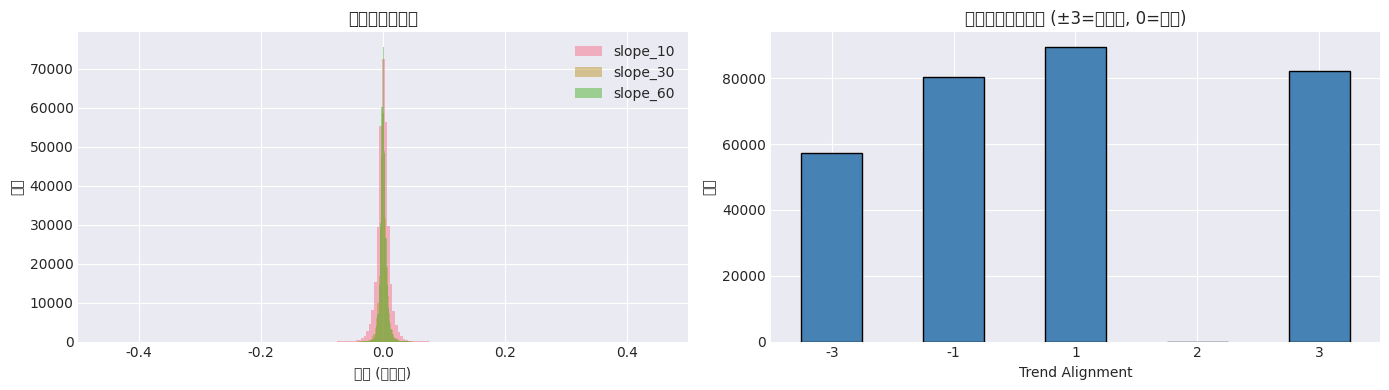


Cell 17 完成: 多尺度趋势特征 ✅


In [ ]:
# ========== Cell 17: 多尺度趋势特征 (Multi-Scale Trend Features) ==========
"""
📌 1.1(a) 多尺度趋势强度 / "趋势能量"
   - 不同窗口的 log_close 斜率: slope_short (10), slope_mid (30), slope_long (60)
   - 多尺度一致性指标: trend_alignment = sign(slope_10) + sign(slope_30) + sign(slope_60)
     - 接近 +3/-3: 多尺度趋势同向
     - 接近 0: 分歧多，结构不清晰（更像 trading range 边缘）
"""
print("计算多尺度趋势特征...")

# 多尺度斜率窗口定义
SLOPE_WINDOWS = [10, 30, 60]

def calc_rolling_slope(log_close: pd.Series, window: int) -> pd.Series:
    """
    计算滚动线性回归斜率 (对 log_close)
    使用简化的最小二乘法
    """
    def linreg_slope(y):
        if len(y) < window or np.any(np.isnan(y)):
            return np.nan
        x = np.arange(len(y))
        x_mean = x.mean()
        y_mean = y.mean()
        ss_xy = ((x - x_mean) * (y - y_mean)).sum()
        ss_x = ((x - x_mean) ** 2).sum()
        return ss_xy / ss_x if ss_x > 0 else 0

    return log_close.rolling(window=window).apply(linreg_slope, raw=True)


# 计算不同窗口的斜率
for w in SLOPE_WINDOWS:
    col_name = f"slope_{w}"
    df[col_name] = calc_rolling_slope(df["log_close"], w)
    # 标准化 (相对 ATR)
    df[f"{col_name}_norm"] = df[col_name] / df["atr"].replace(0, np.nan) * 100  # 放大显示

# 多尺度一致性指标
df["trend_alignment"] = (
    np.sign(df["slope_10"]) +
    np.sign(df["slope_30"]) +
    np.sign(df["slope_60"])
)

# 统计
print("\n=== 多尺度趋势特征统计 ===")
for w in SLOPE_WINDOWS:
    col = f"slope_{w}_norm"
    print(f"slope_{w}_norm: mean={df[col].mean():.4f}, std={df[col].std():.4f}")

alignment_counts = df["trend_alignment"].value_counts().sort_index()
print(f"\ntrend_alignment 分布:")
for k, v in alignment_counts.items():
    pct = v / len(df) * 100
    label = {-3: "强下跌", -2: "弱下跌", -1: "分歧", 0: "无方向",
             1: "分歧", 2: "弱上涨", 3: "强上涨"}.get(int(k), str(k))
    print(f"  {int(k):+d} ({label}): {v:,} ({pct:.1f}%)")


plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# 多尺度斜率分布
for i, w in enumerate(SLOPE_WINDOWS):
    axes[0].hist(df[f"slope_{w}_norm"].dropna(), bins=50, alpha=0.5, label=f"slope_{w}")
axes[0].set_xlabel("斜率 (标准化)")
axes[0].set_ylabel("数量")
axes[0].set_title("多尺度斜率分布")
axes[0].legend()
axes[0].set_xlim(-0.5, 0.5)

# trend_alignment 分布
alignment_counts.plot(kind="bar", ax=axes[1], color="steelblue", edgecolor="black")
axes[1].set_xlabel("Trend Alignment")
axes[1].set_ylabel("数量")
axes[1].set_title("多尺度一致性分布 (±3=强趋势, 0=分歧)")
axes[1].set_xticklabels([f"{int(x)}" for x in alignment_counts.index], rotation=0)

plt.tight_layout()
plt.show()

print("\nCell 17 完成: 多尺度趋势特征 ✅")


计算方向性波动 & Range Expansion 特征...

=== 方向性波动特征统计 ===
dir_vol_ratio: mean=0.3754, median=0.3382
vol_up_ratio: mean=0.5168 (0.5=平衡, >0.5=上涨主导)

=== Range Expansion 特征统计 ===
range_z: mean=-0.0184, std=1.0436
range_z_ma5: mean=-0.0184


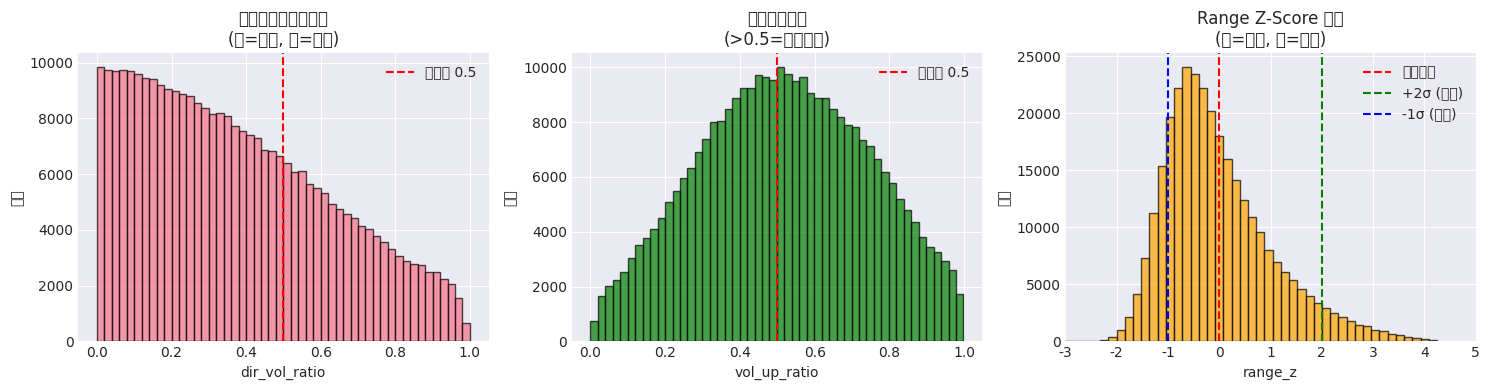


Cell 18 完成: 方向性波动 & Range Expansion ✅


In [ ]:
# ========== Cell 18: 方向性波动 & Range Expansion (Directional Volatility) ==========
"""
📌 1.1(b) "方向性波动" vs "无方向波动"
   区分"顺势波动"和"乱抖动"：
   - vol_up = sum(r_i^2 for r_i > 0)
   - vol_down = sum(r_i^2 for r_i < 0)
   - dir_vol_ratio = |vol_up - vol_down| / vol_tot  ∈ [0,1]
     - 越接近 1: 单边主导（趋势更明显）
     - 越接近 0: 上下乱抖（典型 range）

📌 1.1(c) Range Expansion / Compression
   - range_z = (current_range - avg_range_N) / std_range_N
   - 典型的 regime 变化往往伴随 range_z 的 spike
"""
print("计算方向性波动 & Range Expansion 特征...")

DIR_VOL_WINDOW = 20
RANGE_Z_WINDOW = 20

# ========== 1.1(b) 方向性波动 ==========
def calc_directional_volatility(returns: pd.Series, window: int) -> pd.DataFrame:
    """
    计算方向性波动指标
    """
    # 上涨波动 (r > 0 时的 r^2)
    returns_sq = returns ** 2
    vol_up = returns_sq.where(returns > 0, 0).rolling(window).sum()
    vol_down = returns_sq.where(returns < 0, 0).rolling(window).sum()
    vol_tot = vol_up + vol_down

    # 方向性波动比率
    dir_vol_ratio = (vol_up - vol_down).abs() / vol_tot.replace(0, np.nan)
    dir_vol_ratio = dir_vol_ratio.clip(0, 1)

    # 上涨波动占比 (判断方向)
    vol_up_ratio = vol_up / vol_tot.replace(0, np.nan)

    return pd.DataFrame({
        "vol_up": vol_up,
        "vol_down": vol_down,
        "vol_tot": vol_tot,
        "dir_vol_ratio": dir_vol_ratio,
        "vol_up_ratio": vol_up_ratio,
    })


dir_vol_df = calc_directional_volatility(df["log_return"], DIR_VOL_WINDOW)
df["dir_vol_ratio"] = dir_vol_df["dir_vol_ratio"]
df["vol_up_ratio"] = dir_vol_df["vol_up_ratio"]

# ========== 1.1(c) Range Expansion / Compression ==========
df["bar_range"] = df["high"] - df["low"]
df["avg_range"] = df["bar_range"].rolling(RANGE_Z_WINDOW).mean()
df["std_range"] = df["bar_range"].rolling(RANGE_Z_WINDOW).std()
df["range_z"] = (df["bar_range"] - df["avg_range"]) / df["std_range"].replace(0, np.nan)

# Range z-score 的滚动均值 (用于检测持续压缩/扩张)
df["range_z_ma5"] = df["range_z"].rolling(5).mean()

# 统计
print("\n=== 方向性波动特征统计 ===")
print(f"dir_vol_ratio: mean={df['dir_vol_ratio'].mean():.4f}, median={df['dir_vol_ratio'].median():.4f}")
print(f"vol_up_ratio: mean={df['vol_up_ratio'].mean():.4f} (0.5=平衡, >0.5=上涨主导)")

print(f"\n=== Range Expansion 特征统计 ===")
print(f"range_z: mean={df['range_z'].mean():.4f}, std={df['range_z'].std():.4f}")
print(f"range_z_ma5: mean={df['range_z_ma5'].mean():.4f}")

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# dir_vol_ratio 分布
axes[0].hist(df["dir_vol_ratio"].dropna(), bins=50, edgecolor="black", alpha=0.7)
axes[0].axvline(x=0.5, color="red", linestyle="--", label="中性线 0.5")
axes[0].set_xlabel("dir_vol_ratio")
axes[0].set_ylabel("数量")
axes[0].set_title("方向性波动比率分布\n(高=单边, 低=震荡)")
axes[0].legend()

# vol_up_ratio 分布
axes[1].hist(df["vol_up_ratio"].dropna(), bins=50, edgecolor="black", alpha=0.7, color="green")
axes[1].axvline(x=0.5, color="red", linestyle="--", label="平衡线 0.5")
axes[1].set_xlabel("vol_up_ratio")
axes[1].set_ylabel("数量")
axes[1].set_title("上涨波动占比\n(>0.5=上涨主导)")
axes[1].legend()

# range_z 分布
axes[2].hist(df["range_z"].dropna(), bins=50, edgecolor="black", alpha=0.7, color="orange")
axes[2].axvline(x=0, color="red", linestyle="--", label="平均水平")
axes[2].axvline(x=2, color="green", linestyle="--", label="+2σ (扩张)")
axes[2].axvline(x=-1, color="blue", linestyle="--", label="-1σ (压缩)")
axes[2].set_xlabel("range_z")
axes[2].set_ylabel("数量")
axes[2].set_title("Range Z-Score 分布\n(正=扩张, 负=压缩)")
axes[2].legend()
axes[2].set_xlim(-3, 5)

plt.tight_layout()
plt.show()

print("\nCell 18 完成: 方向性波动 & Range Expansion ✅")


计算多空 Bar 结构特征...



=== Bull/Bear 比例统计 ===
bull_ratio: mean=0.4669
bear_ratio: mean=0.4513
bull_bear_diff: mean=0.0157

=== 连续性统计 ===
consec_bull: max=13, mean=0.85
consec_bear: max=15, mean=0.80


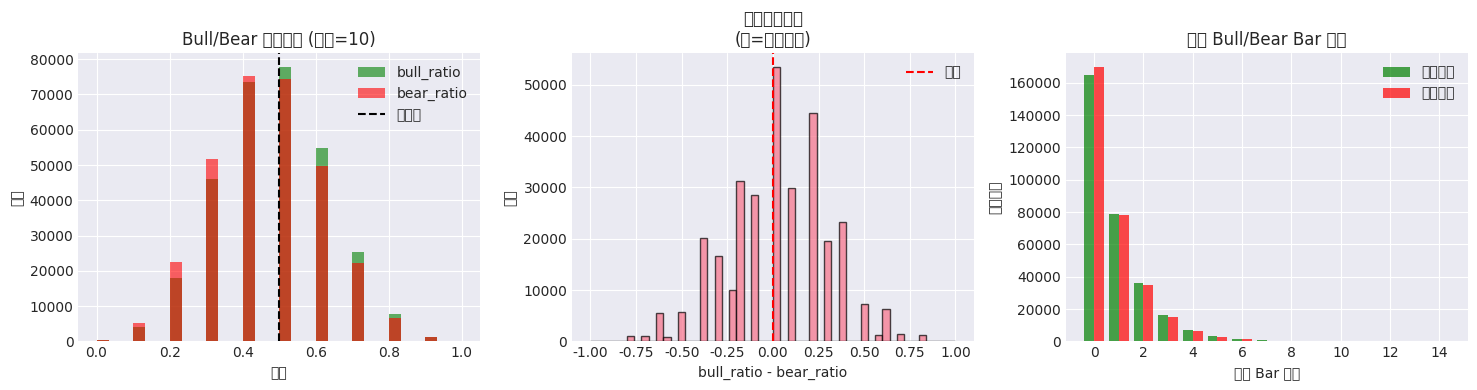


Cell 19 完成: 多空 Bar 结构 ✅


In [ ]:
# ========== Cell 19: 多空 Bar 结构 & 连续性 (Bull/Bear Bar Structure) ==========
"""
📌 1.2(a) Brooks 很看"连续几根 bull/bear bar"
   - bull_ratio_N: 窗口内阳线比例
   - bear_ratio_N: 窗口内阴线比例
   - consec_bull: 当前向前连续的阳线数量
   - consec_bear: 当前向前连续的阴线数量

   趋势段中常见: bull_ratio 极高且 consec_bull > 3
   震荡段中多为: 1-1、2-1 互换、bull/bear 混杂
"""
print("计算多空 Bar 结构特征...")

BAR_STRUCTURE_WINDOW = 10

# ========== Bull/Bear 判定 ==========
# 阳线: close > open, 阴线: close < open
df["is_bull"] = (df["close"] > df["open"]).astype(int)
df["is_bear"] = (df["close"] < df["open"]).astype(int)
df["is_doji"] = (df["close"] == df["open"]).astype(int)  # 十字星

# ========== 窗口内比例 ==========
df["bull_ratio"] = df["is_bull"].rolling(BAR_STRUCTURE_WINDOW).mean()
df["bear_ratio"] = df["is_bear"].rolling(BAR_STRUCTURE_WINDOW).mean()

# Bull - Bear 差异 (正=多头主导, 负=空头主导)
df["bull_bear_diff"] = df["bull_ratio"] - df["bear_ratio"]

# ========== 连续性计算 ==========
@njit
def calc_consecutive_bars(is_bull: np.ndarray, is_bear: np.ndarray) -> tuple:
    """
    计算连续阳线/阴线数量
    """
    n = len(is_bull)
    consec_bull = np.zeros(n, dtype=np.int32)
    consec_bear = np.zeros(n, dtype=np.int32)

    for i in range(n):
        # 连续阳线
        if is_bull[i]:
            if i == 0:
                consec_bull[i] = 1
            else:
                consec_bull[i] = consec_bull[i-1] + 1 if is_bull[i-1] else 1
        else:
            consec_bull[i] = 0

        # 连续阴线
        if is_bear[i]:
            if i == 0:
                consec_bear[i] = 1
            else:
                consec_bear[i] = consec_bear[i-1] + 1 if is_bear[i-1] else 1
        else:
            consec_bear[i] = 0

    return consec_bull, consec_bear


consec_bull, consec_bear = calc_consecutive_bars(
    df["is_bull"].values.astype(np.int32),
    df["is_bear"].values.astype(np.int32)
)
df["consec_bull"] = consec_bull
df["consec_bear"] = consec_bear

# 最近 N 根内最大连续段
df["max_consec_bull_10"] = df["consec_bull"].rolling(10).max()
df["max_consec_bear_10"] = df["consec_bear"].rolling(10).max()

# ========== 统计 ==========
print("\n=== Bull/Bear 比例统计 ===")
print(f"bull_ratio: mean={df['bull_ratio'].mean():.4f}")
print(f"bear_ratio: mean={df['bear_ratio'].mean():.4f}")
print(f"bull_bear_diff: mean={df['bull_bear_diff'].mean():.4f}")

print(f"\n=== 连续性统计 ===")
print(f"consec_bull: max={df['consec_bull'].max()}, mean={df['consec_bull'].mean():.2f}")
print(f"consec_bear: max={df['consec_bear'].max()}, mean={df['consec_bear'].mean():.2f}")

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# bull/bear ratio 分布
axes[0].hist(df["bull_ratio"].dropna(), bins=30, alpha=0.6, label="bull_ratio", color="green")
axes[0].hist(df["bear_ratio"].dropna(), bins=30, alpha=0.6, label="bear_ratio", color="red")
axes[0].axvline(x=0.5, color="black", linestyle="--", label="平衡线")
axes[0].set_xlabel("比例")
axes[0].set_ylabel("数量")
axes[0].set_title(f"Bull/Bear 比例分布 (窗口={BAR_STRUCTURE_WINDOW})")
axes[0].legend()

# bull_bear_diff 分布
axes[1].hist(df["bull_bear_diff"].dropna(), bins=50, edgecolor="black", alpha=0.7)
axes[1].axvline(x=0, color="red", linestyle="--", label="平衡")
axes[1].set_xlabel("bull_ratio - bear_ratio")
axes[1].set_ylabel("数量")
axes[1].set_title("多空差异分布\n(正=多头主导)")
axes[1].legend()

# 连续性分布
consec_bull_counts = pd.Series(consec_bull).value_counts().sort_index()
consec_bear_counts = pd.Series(consec_bear).value_counts().sort_index()
x_range = range(0, min(15, max(consec_bull_counts.index.max(), consec_bear_counts.index.max()) + 1))
axes[2].bar([x - 0.2 for x in x_range],
            [consec_bull_counts.get(x, 0) for x in x_range],
            width=0.4, label="连续阳线", color="green", alpha=0.7)
axes[2].bar([x + 0.2 for x in x_range],
            [consec_bear_counts.get(x, 0) for x in x_range],
            width=0.4, label="连续阴线", color="red", alpha=0.7)
axes[2].set_xlabel("连续 Bar 数量")
axes[2].set_ylabel("出现次数")
axes[2].set_title("连续 Bull/Bear Bar 分布")
axes[2].legend()

plt.tight_layout()
plt.show()

print("\nCell 19 完成: 多空 Bar 结构 ✅")


计算实体/影线结构特征...

=== 单 Bar 实体/影线统计 ===
body_ratio: mean=0.4482, median=0.4483
upper_wick_ratio: mean=0.2710
lower_wick_ratio: mean=0.2807
total_wick_ratio: mean=0.5518

=== 窗口均值 (N=10) ===
avg_body_ratio: mean=0.4482
avg_total_wick_ratio: mean=0.5518
doji_like_ratio: mean=0.3193 (小实体大影线的比例)


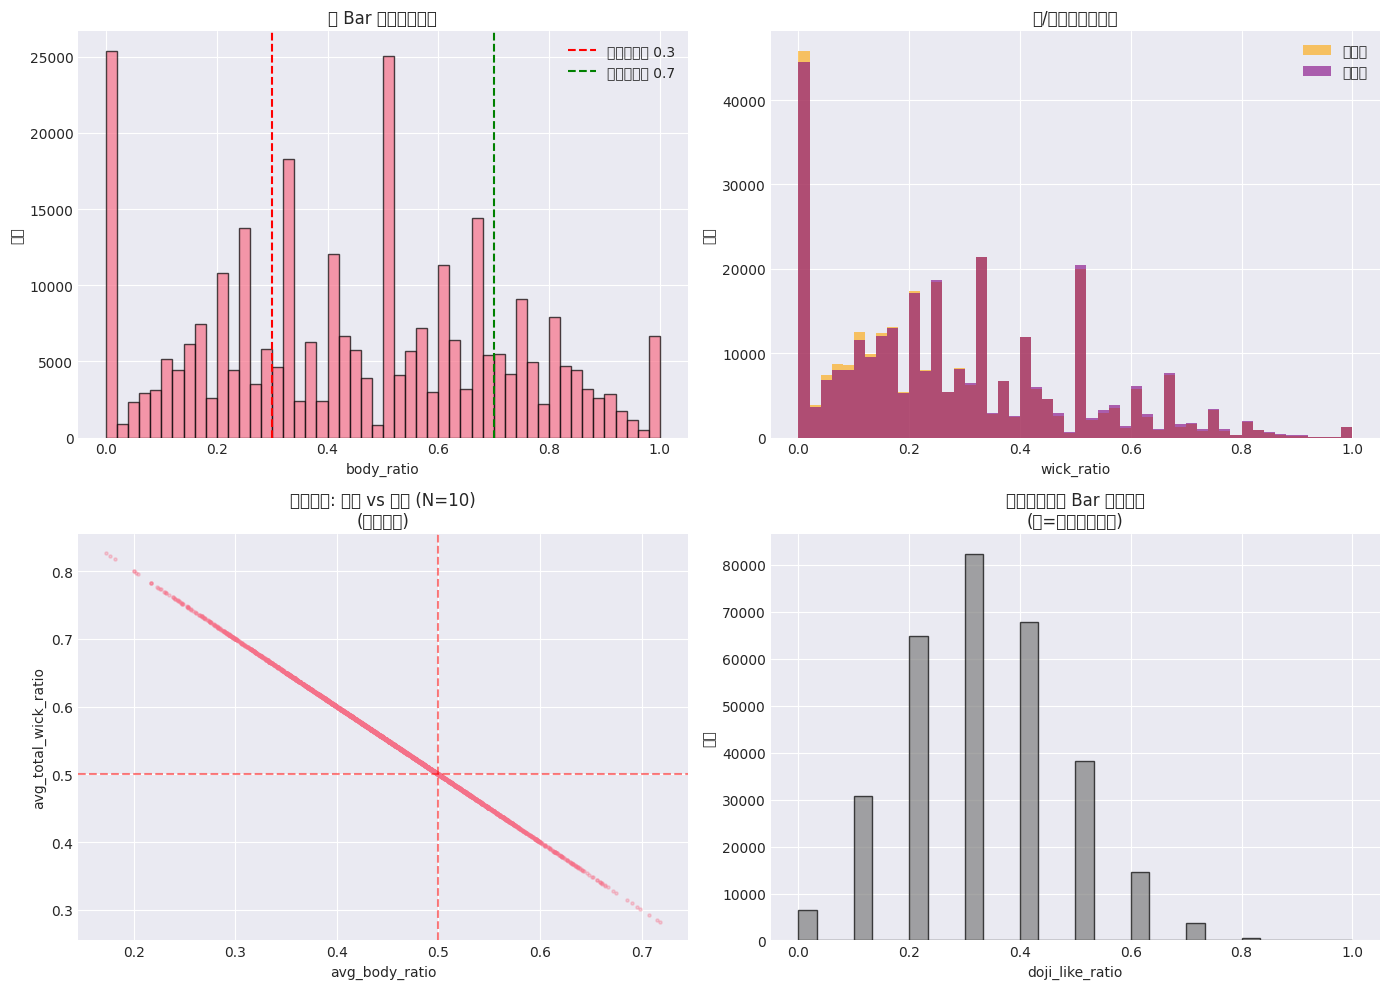


Cell 20 完成: 实体/影线结构 ✅


In [ ]:
# ========== Cell 20: 实体/影线结构 (Body & Wick Ratios) ==========
"""
📌 1.2(b) Brooks 风格的实体/影线分析（不做日式形态名）
   对每根 bar:
   - body_ratio = |close - open| / range  (实体占比)
   - upper_wick_ratio = (high - max(open, close)) / range (上影线占比)
   - lower_wick_ratio = (min(open, close) - low) / range (下影线占比)

   窗口均值解读:
   - avg_body_ratio 低 + 多影线 ⇒ 典型 trading range
   - avg_body_ratio 高 + bull/bear 极端 ⇒ 趋势段
   - Brooks: "lots of tails, especially both sides ⇒ trading range"
"""
print("计算实体/影线结构特征...")

WICK_WINDOW = 10

# ========== 单 Bar 的实体/影线比例 ==========
df["body"] = (df["close"] - df["open"]).abs()
df["upper_wick"] = df["high"] - df[["open", "close"]].max(axis=1)
df["lower_wick"] = df[["open", "close"]].min(axis=1) - df["low"]

# 比例 (避免除以0)
bar_range = df["bar_range"].replace(0, np.nan)
df["body_ratio"] = df["body"] / bar_range
df["upper_wick_ratio"] = df["upper_wick"] / bar_range
df["lower_wick_ratio"] = df["lower_wick"] / bar_range

# 双影线比例 (上下影线之和)
df["total_wick_ratio"] = df["upper_wick_ratio"] + df["lower_wick_ratio"]

# ========== 窗口均值 ==========
df["avg_body_ratio"] = df["body_ratio"].rolling(WICK_WINDOW).mean()
df["avg_upper_wick_ratio"] = df["upper_wick_ratio"].rolling(WICK_WINDOW).mean()
df["avg_lower_wick_ratio"] = df["lower_wick_ratio"].rolling(WICK_WINDOW).mean()
df["avg_total_wick_ratio"] = df["total_wick_ratio"].rolling(WICK_WINDOW).mean()

# ========== 小实体/大影线的 bar 数量 (Brooks 所说的 trading range 特征) ==========
# 定义: body_ratio < 0.3 且 total_wick_ratio > 0.5
df["is_doji_like"] = ((df["body_ratio"] < 0.3) & (df["total_wick_ratio"] > 0.5)).astype(int)
df["doji_like_ratio"] = df["is_doji_like"].rolling(WICK_WINDOW).mean()

# ========== 统计 ==========
print("\n=== 单 Bar 实体/影线统计 ===")
print(f"body_ratio: mean={df['body_ratio'].mean():.4f}, median={df['body_ratio'].median():.4f}")
print(f"upper_wick_ratio: mean={df['upper_wick_ratio'].mean():.4f}")
print(f"lower_wick_ratio: mean={df['lower_wick_ratio'].mean():.4f}")
print(f"total_wick_ratio: mean={df['total_wick_ratio'].mean():.4f}")

print(f"\n=== 窗口均值 (N={WICK_WINDOW}) ===")
print(f"avg_body_ratio: mean={df['avg_body_ratio'].mean():.4f}")
print(f"avg_total_wick_ratio: mean={df['avg_total_wick_ratio'].mean():.4f}")
print(f"doji_like_ratio: mean={df['doji_like_ratio'].mean():.4f} (小实体大影线的比例)")

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

# 可视化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 单 bar body_ratio 分布
axes[0, 0].hist(df["body_ratio"].dropna(), bins=50, edgecolor="black", alpha=0.7)
axes[0, 0].axvline(x=0.3, color="red", linestyle="--", label="小实体阈值 0.3")
axes[0, 0].axvline(x=0.7, color="green", linestyle="--", label="大实体阈值 0.7")
axes[0, 0].set_xlabel("body_ratio")
axes[0, 0].set_ylabel("数量")
axes[0, 0].set_title("单 Bar 实体比例分布")
axes[0, 0].legend()

# 单 bar 影线分布
axes[0, 1].hist(df["upper_wick_ratio"].dropna(), bins=50, alpha=0.6, label="上影线", color="orange")
axes[0, 1].hist(df["lower_wick_ratio"].dropna(), bins=50, alpha=0.6, label="下影线", color="purple")
axes[0, 1].set_xlabel("wick_ratio")
axes[0, 1].set_ylabel("数量")
axes[0, 1].set_title("上/下影线比例分布")
axes[0, 1].legend()

# 窗口均值 body vs wick
axes[1, 0].scatter(df["avg_body_ratio"].dropna().values[::100],
                   df["avg_total_wick_ratio"].dropna().values[::100],
                   alpha=0.3, s=5)
axes[1, 0].set_xlabel("avg_body_ratio")
axes[1, 0].set_ylabel("avg_total_wick_ratio")
axes[1, 0].set_title(f"窗口均值: 实体 vs 影线 (N={WICK_WINDOW})\n(采样显示)")
axes[1, 0].axhline(y=0.5, color="red", linestyle="--", alpha=0.5)
axes[1, 0].axvline(x=0.5, color="red", linestyle="--", alpha=0.5)

# doji_like_ratio 分布
axes[1, 1].hist(df["doji_like_ratio"].dropna(), bins=30, edgecolor="black", alpha=0.7, color="gray")
axes[1, 1].set_xlabel("doji_like_ratio")
axes[1, 1].set_ylabel("数量")
axes[1, 1].set_title("小实体大影线 Bar 比例分布\n(高=典型震荡区间)")

plt.tight_layout()
plt.show()

print("\nCell 20 完成: 实体/影线结构 ✅")


计算三重腿结构特征 (这可能需要一些时间)...
  计算 Leg Type A (Major Legs)...
  计算 Leg Type B (Micro Legs)...
  计算 Leg Type C (Fractal Legs)...



=== 三重腿结构统计 ===
Leg A (Major): 总腿数=105,514, 平均每10bar变化=3.41次
Leg B (Micro): 总腿数=156,620, 平均每10bar变化=5.06次
Leg C (Fractal): 总腿数=149,090, 平均每10bar变化=4.82次


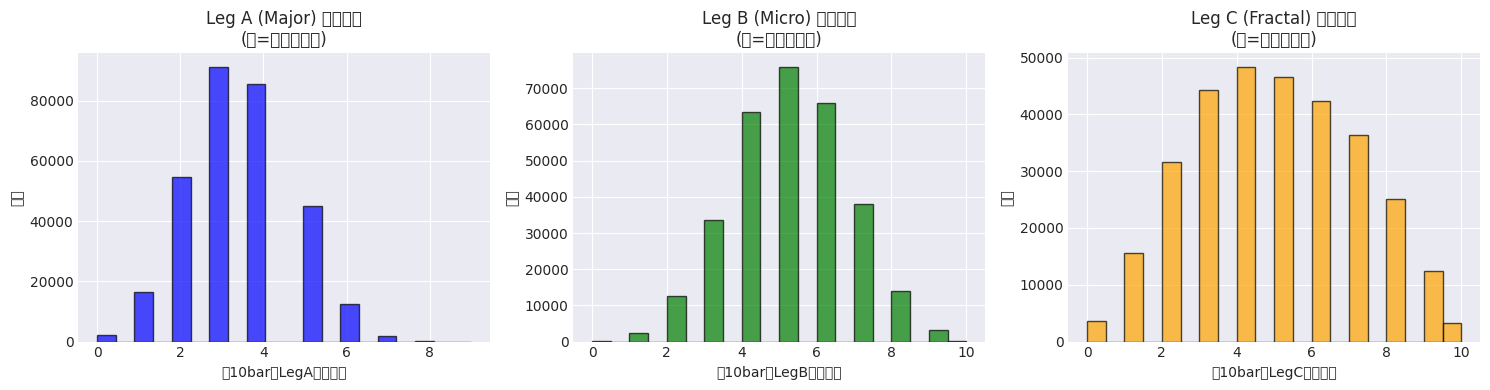


Cell 21 完成: 三重腿结构 ✅


In [ ]:
# ========== Cell 21: 三重腿结构 (Three-Type Leg Structure) ==========
"""
📌 1.2(c) Leg Structure Metrics — Brooks 风格的腿结构量化

三种腿的定义:
1. Leg Type A (Major Legs): Spike Break Leg — 结构性突破腿
   - 上涨中: 某根 bar 的 low 跌破前一根 bar 的 low → 新 major leg 开始
   - 下跌中: 某根 bar 的 high 突破前一根 bar 的 high → 新 major leg 开始

2. Leg Type B (Micro Legs): Opposite Close Leg — 对向收盘腿
   - 上涨中: 出现一根阴线 (close < open) → 新 micro leg
   - 下跌中: 出现一根阳线 (close > open) → 新 micro leg

3. Leg Type C (Fractal Legs): Implied Pullback Leg — 隐含回调腿
   - 基于重叠度、小实体、影线等结构信号判定
   - 模拟更小时间周期上的 pullback 信息

输出特征:
- legA_id, legA_dir, legA_prev1_dir, legA_prev2_dir
- legB_id, legB_dir, legB_prev1_dir, legB_prev2_dir
- legC_id, legC_dir, legC_prev1_dir, legC_prev2_dir
"""
print("计算三重腿结构特征 (这可能需要一些时间)...")

@njit
def calc_leg_type_A(high: np.ndarray, low: np.ndarray, close: np.ndarray, open_: np.ndarray) -> tuple:
    """
    计算 Leg Type A: Spike Break Legs (Major Legs)

    规则:
    - 上涨趋势中: low 跌破前一根 low → 新腿开始
    - 下跌趋势中: high 突破前一根 high → 新腿开始
    - 初始方向由第一根 bar 的 close-open 决定
    """
    n = len(high)
    leg_id = np.zeros(n, dtype=np.int32)
    leg_dir = np.zeros(n, dtype=np.int32)

    # 初始化
    current_leg_id = 1
    if close[0] >= open_[0]:
        current_dir = 1  # 上涨
    else:
        current_dir = -1  # 下跌

    leg_id[0] = current_leg_id
    leg_dir[0] = current_dir

    for i in range(1, n):
        new_leg = False

        if current_dir == 1:  # 当前上涨腿
            # 如果 low 跌破前一根 low → 结构性破坏 → 新腿
            if low[i] < low[i-1]:
                new_leg = True
                # 新腿方向由当前 bar 决定
                if close[i] >= open_[i]:
                    current_dir = 1
                else:
                    current_dir = -1
        else:  # 当前下跌腿
            # 如果 high 突破前一根 high → 结构性破坏 → 新腿
            if high[i] > high[i-1]:
                new_leg = True
                if close[i] >= open_[i]:
                    current_dir = 1
                else:
                    current_dir = -1

        if new_leg:
            current_leg_id += 1

        leg_id[i] = current_leg_id
        leg_dir[i] = current_dir

    return leg_id, leg_dir


@njit
def calc_leg_type_B(close: np.ndarray, open_: np.ndarray) -> tuple:
    """
    计算 Leg Type B: Opposite Close Legs (Micro Legs)

    规则:
    - 当前上涨腿中，出现阴线 → 新腿（方向翻转）
    - 当前下跌腿中，出现阳线 → 新腿（方向翻转）
    """
    n = len(close)
    leg_id = np.zeros(n, dtype=np.int32)
    leg_dir = np.zeros(n, dtype=np.int32)

    current_leg_id = 1
    if close[0] >= open_[0]:
        current_dir = 1
    else:
        current_dir = -1

    leg_id[0] = current_leg_id
    leg_dir[0] = current_dir

    for i in range(1, n):
        bar_dir = 1 if close[i] >= open_[i] else -1

        # 如果当前 bar 方向与腿方向相反 → 新腿
        if bar_dir != current_dir:
            current_leg_id += 1
            current_dir = bar_dir

        leg_id[i] = current_leg_id
        leg_dir[i] = current_dir

    return leg_id, leg_dir


@njit
def calc_leg_type_C(high: np.ndarray, low: np.ndarray, close: np.ndarray, open_: np.ndarray,
                    overlap_ratio: np.ndarray, body_ratio: np.ndarray,
                    upper_wick_ratio: np.ndarray, lower_wick_ratio: np.ndarray,
                    atr: np.ndarray) -> tuple:
    """
    计算 Leg Type C: Implied Pullback Legs (Fractal Legs)

    规则 (上涨中，满足2项条件即新腿):
    - overlap_ratio > 0.6
    - body_ratio < 0.3
    - upper_wick_ratio > 0.4 (上涨中) 或 lower_wick_ratio > 0.4 (下跌中)
    - 最近4根bar的高点增幅 < ATR * 0.3 (动能停滞)
    """
    n = len(high)
    leg_id = np.zeros(n, dtype=np.int32)
    leg_dir = np.zeros(n, dtype=np.int32)

    current_leg_id = 1
    if close[0] >= open_[0]:
        current_dir = 1
    else:
        current_dir = -1

    leg_id[0] = current_leg_id
    leg_dir[0] = current_dir

    for i in range(1, n):
        conditions_met = 0

        # 检查各项条件
        if not np.isnan(overlap_ratio[i]) and overlap_ratio[i] > 0.6:
            conditions_met += 1

        if not np.isnan(body_ratio[i]) and body_ratio[i] < 0.3:
            conditions_met += 1

        if current_dir == 1:  # 上涨腿
            if not np.isnan(upper_wick_ratio[i]) and upper_wick_ratio[i] > 0.4:
                conditions_met += 1
        else:  # 下跌腿
            if not np.isnan(lower_wick_ratio[i]) and lower_wick_ratio[i] > 0.4:
                conditions_met += 1

        # 动能停滞检查 (最近4根bar)
        if i >= 4 and not np.isnan(atr[i]) and atr[i] > 0:
            if current_dir == 1:
                high_gain = high[i] - high[i-4]
            else:
                high_gain = low[i-4] - low[i]

            if high_gain < atr[i] * 0.3:
                conditions_met += 1

        # 满足 2 项条件 → 新腿
        if conditions_met >= 2:
            current_leg_id += 1
            # 方向由当前 bar 决定
            if close[i] >= open_[i]:
                current_dir = 1
            else:
                current_dir = -1

        leg_id[i] = current_leg_id
        leg_dir[i] = current_dir

    return leg_id, leg_dir


# ========== 计算三种腿 ==========
print("  计算 Leg Type A (Major Legs)...")
legA_id, legA_dir = calc_leg_type_A(
    df["high"].values, df["low"].values,
    df["close"].values, df["open"].values
)
df["legA_id"] = legA_id
df["legA_dir"] = legA_dir

print("  计算 Leg Type B (Micro Legs)...")
legB_id, legB_dir = calc_leg_type_B(df["close"].values, df["open"].values)
df["legB_id"] = legB_id
df["legB_dir"] = legB_dir

print("  计算 Leg Type C (Fractal Legs)...")
# 先填充 NaN 为 0，避免 numba 错误
overlap_arr = df["overlap_ratio"].fillna(0).values
body_arr = df["body_ratio"].fillna(0).values
upper_wick_arr = df["upper_wick_ratio"].fillna(0).values
lower_wick_arr = df["lower_wick_ratio"].fillna(0).values
atr_arr = df["atr"].fillna(0).values

legC_id, legC_dir = calc_leg_type_C(
    df["high"].values, df["low"].values,
    df["close"].values, df["open"].values,
    overlap_arr, body_arr, upper_wick_arr, lower_wick_arr, atr_arr
)
df["legC_id"] = legC_id
df["legC_dir"] = legC_dir

# ========== 添加前几腿方向特征 ==========
for leg_type in ["A", "B", "C"]:
    dir_col = f"leg{leg_type}_dir"
    df[f"leg{leg_type}_prev1_dir"] = df[dir_col].shift(1)
    df[f"leg{leg_type}_prev2_dir"] = df[dir_col].shift(2)

# ========== 计算每种腿的变化率 (用于检测频率) ==========
for leg_type in ["A", "B", "C"]:
    id_col = f"leg{leg_type}_id"
    # 腿变化标记
    df[f"leg{leg_type}_change"] = (df[id_col] != df[id_col].shift(1)).astype(int)
    # 最近 N 根内的腿变化次数
    df[f"leg{leg_type}_changes_10"] = df[f"leg{leg_type}_change"].rolling(10).sum()

# ========== 统计 ==========
print("\n=== 三重腿结构统计 ===")
for leg_type, desc in [("A", "Major"), ("B", "Micro"), ("C", "Fractal")]:
    total_legs = df[f"leg{leg_type}_id"].max()
    avg_changes = df[f"leg{leg_type}_changes_10"].mean()
    print(f"Leg {leg_type} ({desc}): 总腿数={total_legs:,}, 平均每10bar变化={avg_changes:.2f}次")

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (leg_type, desc, color) in enumerate([("A", "Major", "blue"),
                                               ("B", "Micro", "green"),
                                               ("C", "Fractal", "orange")]):
    changes_col = f"leg{leg_type}_changes_10"
    axes[i].hist(df[changes_col].dropna(), bins=20, edgecolor="black", alpha=0.7, color=color)
    axes[i].set_xlabel(f"每10bar的Leg{leg_type}变化次数")
    axes[i].set_ylabel("数量")
    axes[i].set_title(f"Leg {leg_type} ({desc}) 变化频率\n(高=更多腿切换)")

plt.tight_layout()
plt.show()

print("\nCell 21 完成: 三重腿结构 ✅")


计算 Spike & Channel 评分...



=== Spike & Channel 评分统计 ===
spike_score: mean=0.4211, max=0.9677
channel_score: mean=0.6019, max=0.9419

=== Phase 分布 ===
  Normal/Range: 240,078 (77.59%)
  Spike: 16,960 (5.48%)
  Channel: 52,374 (16.93%)


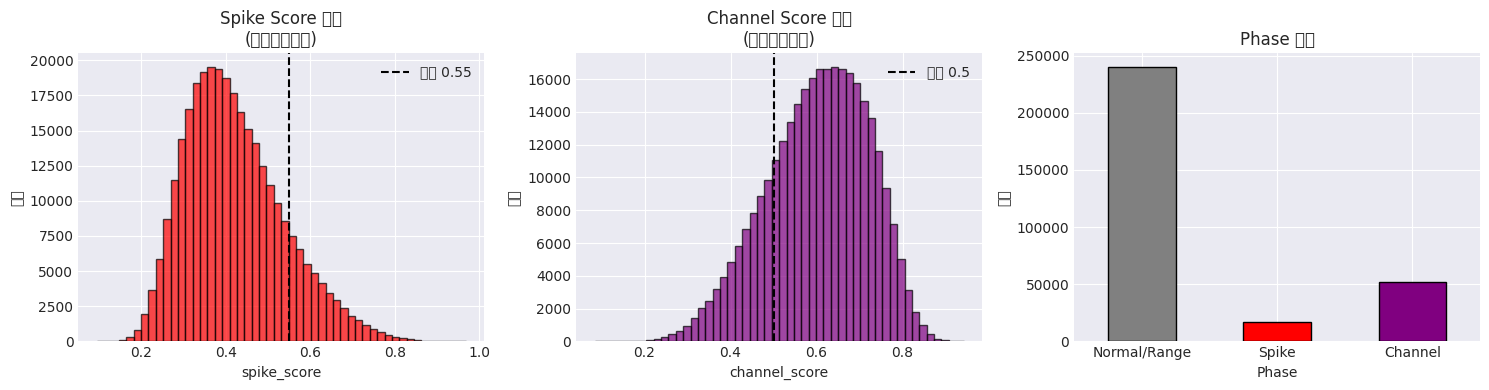


Cell 22 完成: Spike & Channel 评分 ✅


In [ ]:
# ========== Cell 22: Spike & Channel 评分 (Phase Detection) ==========
"""
📌 使用三套腿结构来识别 Spike (趋势爆发期) 和 Channel (趋势成熟期)

Spike (趋势爆发) 特点:
- 只有 1 条 major leg（或只到 legA=2）
- micro legs（B 型）极少
- implied legs（C 型）极少
- 斜率强、重叠少、range_z 高、er 高、chop 低

Channel (趋势成熟/衰竭) 特点:
- major legA ≥ 2 且趋势仍延续
- micro legs（B 型）数量上升
- implied legs（C 型）密度上升
- slope 下降但方向仍稳定
- 高重叠度

输出:
- spike_score: 0-1 分数，越高越像 Spike
- channel_score: 0-1 分数，越高越像 Channel
- phase: 0=normal, 1=spike, 2=channel
"""
print("计算 Spike & Channel 评分...")

PHASE_WINDOW = 10

# ========== Spike Score ==========
def calc_spike_score(df: pd.DataFrame, window: int = 10) -> pd.Series:
    """
    计算 Spike Score (趋势爆发分数)

    组成:
    1. Major leg 少 (legA_changes 低)
    2. Micro leg 少 (legB_changes 低)
    3. Fractal leg 少 (legC_changes 低)
    4. ER 高
    5. chop 低
    6. range_z 高
    7. 多尺度一致性高 (|trend_alignment| == 3)
    """
    scores = pd.DataFrame(index=df.index)

    # 1. Major leg 变化少 (spike 中通常只有 1-2 条大腿)
    legA_changes = df["legA_changes_10"]
    scores["legA_score"] = 1 - (legA_changes / 10).clip(0, 1)  # 变化少 → 高分

    # 2. Micro leg 变化少
    legB_changes = df["legB_changes_10"]
    scores["legB_score"] = 1 - (legB_changes / 10).clip(0, 1)

    # 3. Fractal leg 变化少
    legC_changes = df["legC_changes_10"]
    scores["legC_score"] = 1 - (legC_changes / 10).clip(0, 1)

    # 4. ER 高 (> 0.4 开始加分)
    scores["er_score"] = ((df["er"] - 0.2) / 0.6).clip(0, 1)

    # 5. chop 低 (< 0.5 开始加分)
    scores["chop_score"] = ((0.7 - df["chop"]) / 0.5).clip(0, 1)

    # 6. range_z 高 (扩张)
    scores["range_z_score"] = (df["range_z"] / 3).clip(0, 1)

    # 7. 多尺度一致性
    scores["alignment_score"] = (df["trend_alignment"].abs() / 3).clip(0, 1)

    # 加权平均
    weights = {
        "legA_score": 0.15,
        "legB_score": 0.15,
        "legC_score": 0.10,
        "er_score": 0.20,
        "chop_score": 0.15,
        "range_z_score": 0.10,
        "alignment_score": 0.15,
    }

    spike_score = sum(scores[col] * w for col, w in weights.items())
    return spike_score.clip(0, 1)


# ========== Channel Score ==========
def calc_channel_score(df: pd.DataFrame, window: int = 10) -> pd.Series:
    """
    计算 Channel Score (趋势成熟/衰竭分数)

    组成:
    1. Major leg >= 2
    2. Micro leg 增多 (legB_changes 高)
    3. Fractal leg 增多 (legC_changes 高)
    4. 重叠度高
    5. 斜率衰减 (但方向仍一致)
    6. ER 中等 (0.3-0.5)
    """
    scores = pd.DataFrame(index=df.index)

    # 1. Micro leg 变化多 (channel 内部有很多小回调)
    legB_changes = df["legB_changes_10"]
    scores["legB_score"] = (legB_changes / 8).clip(0, 1)

    # 2. Fractal leg 变化多
    legC_changes = df["legC_changes_10"]
    scores["legC_score"] = (legC_changes / 6).clip(0, 1)

    # 3. 重叠度高
    scores["overlap_score"] = ((df["overlap_ratio"] - 0.3) / 0.5).clip(0, 1)

    # 4. ER 中等 (不太高也不太低)
    er = df["er"]
    scores["er_score"] = 1 - 2 * (er - 0.35).abs()  # 0.35 附近最高
    scores["er_score"] = scores["er_score"].clip(0, 1)

    # 5. 斜率仍有但在衰减 (slope_norm 正/负但绝对值 < 0.05)
    slope_abs = df["slope_norm"].abs()
    scores["slope_score"] = ((0.1 - slope_abs) / 0.1 + 0.5).clip(0, 1)

    # 6. 小实体比例高 (channel 内部常见)
    scores["body_score"] = ((0.6 - df["avg_body_ratio"]) / 0.4).clip(0, 1)

    # 加权平均
    weights = {
        "legB_score": 0.20,
        "legC_score": 0.15,
        "overlap_score": 0.20,
        "er_score": 0.15,
        "slope_score": 0.15,
        "body_score": 0.15,
    }

    channel_score = sum(scores[col] * w for col, w in weights.items())
    return channel_score.clip(0, 1)


# 计算分数
df["spike_score"] = calc_spike_score(df, PHASE_WINDOW)
df["channel_score"] = calc_channel_score(df, PHASE_WINDOW)

# ========== Phase 判定 ==========
# phase: 0=normal, 1=spike, 2=channel
SPIKE_THRESHOLD = 0.55
CHANNEL_THRESHOLD = 0.50

def determine_phase(spike: float, channel: float, regime: int) -> int:
    """
    判定当前阶段
    - 如果 regime == 0 (震荡区间)，则 phase = 0
    - 如果 spike_score 高且在趋势中，则 phase = 1 (spike)
    - 如果 channel_score 高且在趋势中，则 phase = 2 (channel)
    """
    if pd.isna(regime) or regime == 0:
        return 0

    if spike > SPIKE_THRESHOLD and spike > channel:
        return 1  # Spike
    elif channel > CHANNEL_THRESHOLD:
        return 2  # Channel
    else:
        return 0  # Normal trend


df["phase"] = df.apply(
    lambda row: determine_phase(row["spike_score"], row["channel_score"], row["regime"]),
    axis=1
)

# ========== 统计 ==========
print("\n=== Spike & Channel 评分统计 ===")
print(f"spike_score: mean={df['spike_score'].mean():.4f}, max={df['spike_score'].max():.4f}")
print(f"channel_score: mean={df['channel_score'].mean():.4f}, max={df['channel_score'].max():.4f}")

phase_counts = df["phase"].value_counts().sort_index()
print(f"\n=== Phase 分布 ===")
phase_names = {0: "Normal/Range", 1: "Spike", 2: "Channel"}
for k, v in phase_counts.items():
    print(f"  {phase_names.get(k, k)}: {v:,} ({v/len(df)*100:.2f}%)")

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Spike Score 分布
axes[0].hist(df["spike_score"].dropna(), bins=50, edgecolor="black", alpha=0.7, color="red")
axes[0].axvline(x=SPIKE_THRESHOLD, color="black", linestyle="--", label=f"阈值 {SPIKE_THRESHOLD}")
axes[0].set_xlabel("spike_score")
axes[0].set_ylabel("数量")
axes[0].set_title("Spike Score 分布\n(趋势爆发分数)")
axes[0].legend()

# Channel Score 分布
axes[1].hist(df["channel_score"].dropna(), bins=50, edgecolor="black", alpha=0.7, color="purple")
axes[1].axvline(x=CHANNEL_THRESHOLD, color="black", linestyle="--", label=f"阈值 {CHANNEL_THRESHOLD}")
axes[1].set_xlabel("channel_score")
axes[1].set_ylabel("数量")
axes[1].set_title("Channel Score 分布\n(趋势衰竭分数)")
axes[1].legend()

# Phase 分布
phase_counts.plot(kind="bar", ax=axes[2], color=["gray", "red", "purple"], edgecolor="black")
axes[2].set_xlabel("Phase")
axes[2].set_ylabel("数量")
axes[2].set_title("Phase 分布")
axes[2].set_xticklabels(["Normal/Range", "Spike", "Channel"], rotation=0)

plt.tight_layout()
plt.show()

print("\nCell 22 完成: Spike & Channel 评分 ✅")


计算关键价位特征...
  按日期分组计算日内特征...



=== 关键价位特征统计 ===
pos_in_day_range: mean=0.5520, std=0.2990
dist_to_open: mean=0.2815, std=3.7743
day_return: mean=0.000119, std=0.005790

=== 位置分布 ===
near_day_high 比例: 14.66%
near_day_low 比例: 8.10%
near_open 比例: 13.04%


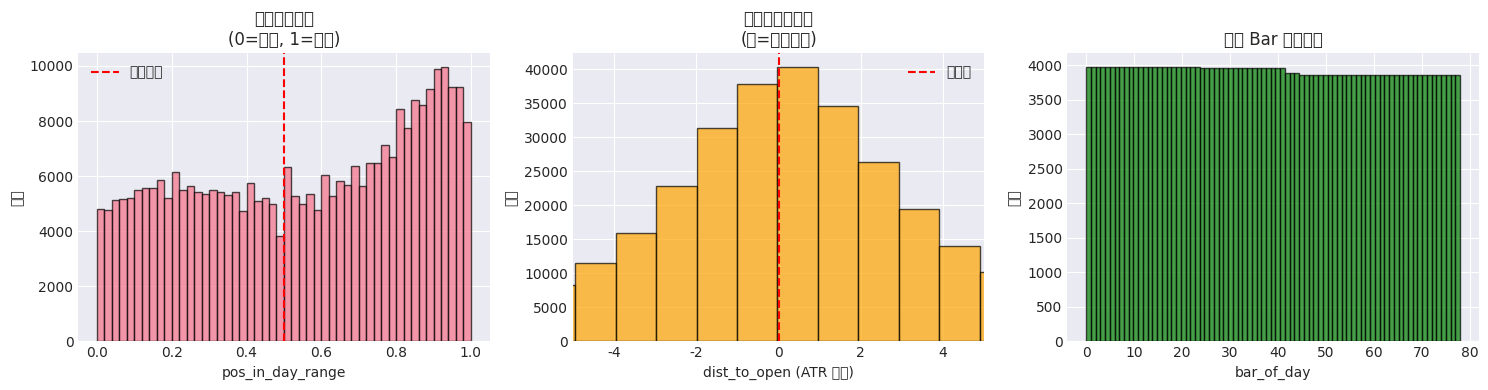


Cell 23 完成: 关键价位特征 ✅


In [ ]:
# ========== Cell 23: 关键价位特征 (Key Price Levels) ==========
"""
📌 1.2(e) Brooks 交易员在盘中非常看重的关键价位:
   - pos_in_day_range = (close - day_low) / (day_high - day_low)  ∈ [0,1]
   - dist_to_open = (close - day_open) / ATR_day
   - 接近当日高/低且行情已经涨跌很多 ⇒ 更容易 trading range 或 climactic
   - 一直贴在 open 近旁上下晃 ⇒ 典型"开盘区间"的无方向震荡

注意: 这些特征使用 cumulative 的当日信息，不泄露未来
"""
print("计算关键价位特征...")

# 首先需要识别每个交易日
df_temp = df.copy()
df_temp = df_temp.reset_index()
df_temp["timestamp_dt"] = pd.to_datetime(df_temp["timestamp"].astype(str).str.slice(0, 19))
df_temp["date"] = df_temp["timestamp_dt"].dt.date
df_temp = df_temp.set_index("timestamp")

# ========== 计算每日的关键价位 (滚动累积，不泄露未来) ==========
def calc_intraday_features(group):
    """
    计算单日内的关键价位特征 (使用 expanding 确保不泄露未来)
    """
    n = len(group)

    # 当日开盘价 (第一根 bar 的 open)
    day_open = group["open"].iloc[0]

    # 累积到当前的最高/最低价 (expanding)
    cum_high = group["high"].expanding().max()
    cum_low = group["low"].expanding().min()
    cum_range = cum_high - cum_low

    # 当前价格在日内区间的位置 [0, 1]
    pos_in_day_range = (group["close"] - cum_low) / cum_range.replace(0, np.nan)

    # 当前价格相对开盘价的距离 (标准化)
    # 使用当日累积 ATR 的均值
    cum_atr_mean = group["atr"].expanding().mean()
    dist_to_open = (group["close"] - day_open) / cum_atr_mean.replace(0, np.nan)

    # 当日累积收益 (相对开盘)
    day_return = (group["close"] - day_open) / day_open

    # 当日累积波动 (ATR 总和 / 根数)
    day_volatility = group["atr"].expanding().mean()

    # 当日 bar 序号 (从 0 开始)
    bar_of_day = np.arange(n)

    return pd.DataFrame({
        "day_open": day_open,
        "cum_high": cum_high,
        "cum_low": cum_low,
        "cum_range": cum_range,
        "pos_in_day_range": pos_in_day_range,
        "dist_to_open": dist_to_open,
        "day_return": day_return,
        "day_volatility": day_volatility,
        "bar_of_day": bar_of_day,
    }, index=group.index)


# 按日期分组计算
print("  按日期分组计算日内特征...")
intraday_features = df_temp.groupby("date").apply(calc_intraday_features)

# 处理 MultiIndex
if isinstance(intraday_features.index, pd.MultiIndex):
    intraday_features = intraday_features.droplevel(0)

# 合并到主 df
for col in ["pos_in_day_range", "dist_to_open", "day_return", "bar_of_day"]:
    df[col] = intraday_features[col]

# ========== 额外的日内位置特征 ==========
# 是否接近当日高点 (top 10%)
df["near_day_high"] = (df["pos_in_day_range"] > 0.9).astype(int)
# 是否接近当日低点 (bottom 10%)
df["near_day_low"] = (df["pos_in_day_range"] < 0.1).astype(int)
# 是否在开盘区间 (dist_to_open 的绝对值 < 0.5 ATR)
df["near_open"] = (df["dist_to_open"].abs() < 0.5).astype(int)

# ========== 时间特征 (无泄露) ==========
# 将 bar_of_day 标准化 (一天约 79 根 5min bar for RTH)
df["time_of_day_norm"] = df["bar_of_day"] / 79  # 0=开盘, 1=收盘

# 开盘/收盘区间标记
df["is_open_range"] = (df["bar_of_day"] < 6).astype(int)   # 前30分钟
df["is_close_range"] = (df["bar_of_day"] > 70).astype(int)  # 最后45分钟

# ========== 统计 ==========
print("\n=== 关键价位特征统计 ===")
print(f"pos_in_day_range: mean={df['pos_in_day_range'].mean():.4f}, std={df['pos_in_day_range'].std():.4f}")
print(f"dist_to_open: mean={df['dist_to_open'].mean():.4f}, std={df['dist_to_open'].std():.4f}")
print(f"day_return: mean={df['day_return'].mean():.6f}, std={df['day_return'].std():.6f}")

print(f"\n=== 位置分布 ===")
print(f"near_day_high 比例: {df['near_day_high'].mean()*100:.2f}%")
print(f"near_day_low 比例: {df['near_day_low'].mean()*100:.2f}%")
print(f"near_open 比例: {df['near_open'].mean()*100:.2f}%")

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# pos_in_day_range 分布
axes[0].hist(df["pos_in_day_range"].dropna(), bins=50, edgecolor="black", alpha=0.7)
axes[0].axvline(x=0.5, color="red", linestyle="--", label="中间位置")
axes[0].set_xlabel("pos_in_day_range")
axes[0].set_ylabel("数量")
axes[0].set_title("日内位置分布\n(0=日低, 1=日高)")
axes[0].legend()

# dist_to_open 分布
axes[1].hist(df["dist_to_open"].dropna(), bins=50, edgecolor="black", alpha=0.7, color="orange")
axes[1].axvline(x=0, color="red", linestyle="--", label="开盘价")
axes[1].set_xlabel("dist_to_open (ATR 单位)")
axes[1].set_ylabel("数量")
axes[1].set_title("相对开盘价距离\n(正=高于开盘)")
axes[1].legend()
axes[1].set_xlim(-5, 5)

# bar_of_day 分布 (应该是均匀的)
axes[2].hist(df["bar_of_day"].dropna(), bins=79, edgecolor="black", alpha=0.7, color="green")
axes[2].set_xlabel("bar_of_day")
axes[2].set_ylabel("数量")
axes[2].set_title("日内 Bar 序号分布")

plt.tight_layout()
plt.show()

print("\nCell 23 完成: 关键价位特征 ✅")


计算多时间周期特征...
  Resampling 到 15min 和 60min...
  15min bars: 105,713
  60min bars: 31,340
  计算 15min 指标...
  计算 60min 指标...
  对齐并合并到 5min 数据...

=== 多周期特征统计 ===
15min ER: mean=0.3047
60min ER: mean=0.3212
ATR ratio (15/5): mean=1.7948
ATR ratio (60/5): mean=3.5962

多周期趋势一致性分布:
  -3: 63,165 (20.4%)
  -2: 6,833 (2.2%)
  -1: 67,880 (21.9%)
  +0: 3,805 (1.2%)
  +1: 72,591 (23.5%)
  +2: 8,950 (2.9%)
  +3: 86,173 (27.9%)


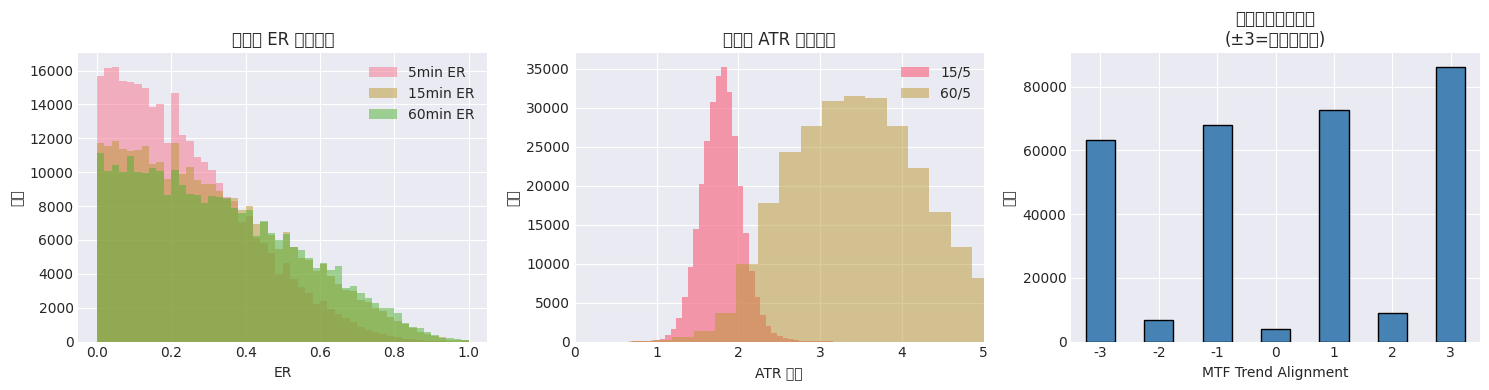


Cell 24 完成: 多时间周期特征 ✅


In [ ]:
# ========== Cell 24: 多时间周期特征 (Multi-Timeframe Features) ==========
"""
📌 Section 2: 把 15min / 1h 的信息也加入训练集

思路:
1. 将 5min 数据 resample 到 15min 和 60min
2. 在高周期上计算相同的指标 (KAMA, ER, ATR, slope, chop 等)
3. 使用 floor 对齐，确保不泄露未来信息
4. 合并回 5min 数据

这样模型可以学到:
- "当 1h 在上升趋势、15min 在震荡时，5min 的向下波动多半是 pullback"
"""
print("计算多时间周期特征...")

# ========== 1. Resample to 15min and 60min ==========
print("  Resampling 到 15min 和 60min...")

# 保存原始 5min df
df_5 = df.copy()

# 需要先 reset index 来处理
df_5_reset = df_5.reset_index()
df_5_reset["timestamp_dt"] = pd.to_datetime(df_5_reset["timestamp"].astype(str).str.slice(0, 19))
df_5_reset = df_5_reset.set_index("timestamp_dt")

# Resample 函数
def resample_ohlcv(df_src: pd.DataFrame, freq: str) -> pd.DataFrame:
    """将 OHLCV 数据 resample 到指定频率"""
    df_resampled = df_src.resample(freq).agg({
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum",
    }).dropna()
    return df_resampled

df_15 = resample_ohlcv(df_5_reset, "15T")
df_60 = resample_ohlcv(df_5_reset, "60T")

print(f"  15min bars: {len(df_15):,}")
print(f"  60min bars: {len(df_60):,}")

# ========== 2. 在高周期上计算指标 ==========
def calc_htf_features(df_htf: pd.DataFrame, suffix: str,
                      n_atr: int = 14, n_er: int = 14, l_back: int = 14) -> pd.DataFrame:
    """
    在高周期数据上计算核心指标
    """
    df_htf = df_htf.copy()

    # Log close
    df_htf["log_close"] = np.log(df_htf["close"])

    # ATR
    prev_close = df_htf["close"].shift(1)
    tr1 = df_htf["high"] - df_htf["low"]
    tr2 = (df_htf["high"] - prev_close).abs()
    tr3 = (df_htf["low"] - prev_close).abs()
    df_htf["tr"] = np.maximum(np.maximum(tr1, tr2), tr3)
    df_htf[f"atr_{suffix}"] = df_htf["tr"].ewm(span=n_atr, adjust=False).mean()

    # ER
    change = (df_htf["close"] - df_htf["close"].shift(n_er)).abs()
    volatility = df_htf["close"].diff().abs().rolling(window=n_er).sum()
    df_htf[f"er_{suffix}"] = (change / volatility.replace(0, np.nan)).clip(0, 1)

    # Slope (简化版)
    df_htf[f"slope_{suffix}"] = df_htf["log_close"].diff(5) / 5
    df_htf[f"slope_{suffix}_norm"] = df_htf[f"slope_{suffix}"] / df_htf[f"atr_{suffix}"].replace(0, np.nan) * 100

    # Chop (简化版)
    chop_window = min(14, l_back)
    atr_sum = df_htf["tr"].rolling(window=chop_window).sum()
    high_max = df_htf["high"].rolling(window=chop_window).max()
    low_min = df_htf["low"].rolling(window=chop_window).min()
    hl_range = high_max - low_min
    df_htf[f"chop_{suffix}"] = (np.log10(atr_sum / hl_range.replace(0, np.nan)) / np.log10(chop_window)).clip(0, 1)

    # 趋势方向 (基于 slope)
    df_htf[f"trend_dir_{suffix}"] = np.sign(df_htf[f"slope_{suffix}"])

    # 只返回需要的列
    result_cols = [f"atr_{suffix}", f"er_{suffix}", f"slope_{suffix}_norm",
                   f"chop_{suffix}", f"trend_dir_{suffix}"]

    return df_htf[result_cols]


print("  计算 15min 指标...")
df_15_features = calc_htf_features(df_15, "15", n_atr=14, n_er=14, l_back=14)

print("  计算 60min 指标...")
df_60_features = calc_htf_features(df_60, "60", n_atr=14, n_er=14, l_back=14)

# ========== 3. Floor 对齐并 merge 回 5min ==========
print("  对齐并合并到 5min 数据...")

# ⚠️ 重要：使用前一个已完成的高周期 bar，避免未来信息泄露
# 例如：在 9:35 时，floor("15T") = 9:30，但 9:30-9:45 的 15min bar 包含 9:40 的未来信息
# 正确做法：减去一个周期，使用前一个已完成的 bar
df_5_reset["t_15"] = df_5_reset.index.floor("15T") - pd.Timedelta("15min")
df_5_reset["t_60"] = df_5_reset.index.floor("60T") - pd.Timedelta("60min")

# Merge 15min features
df_15_features = df_15_features.reset_index()
df_15_features = df_15_features.rename(columns={"timestamp_dt": "t_15"})
df_5_merged = df_5_reset.reset_index().merge(
    df_15_features, on="t_15", how="left"
)

# Merge 60min features
df_60_features = df_60_features.reset_index()
df_60_features = df_60_features.rename(columns={"timestamp_dt": "t_60"})
df_5_merged = df_5_merged.merge(
    df_60_features, on="t_60", how="left"
)

# 将特征添加回原始 df
df_5_merged = df_5_merged.set_index("timestamp")

for col in ["atr_15", "er_15", "slope_15_norm", "chop_15", "trend_dir_15",
            "atr_60", "er_60", "slope_60_norm", "chop_60", "trend_dir_60"]:
    if col in df_5_merged.columns:
        df[col] = df_5_merged[col]

# ========== 4. 多周期比率特征 ==========
# ATR 比率 (波动率跨周期比)
df["atr_ratio_15_5"] = df["atr_15"] / df["atr"].replace(0, np.nan)
df["atr_ratio_60_5"] = df["atr_60"] / df["atr"].replace(0, np.nan)

# 多周期趋势一致性
df["mtf_trend_alignment"] = (
    np.sign(df["slope_norm"]) +
    df["trend_dir_15"].fillna(0) +
    df["trend_dir_60"].fillna(0)
)

# ========== 统计 ==========
print("\n=== 多周期特征统计 ===")
print(f"15min ER: mean={df['er_15'].mean():.4f}")
print(f"60min ER: mean={df['er_60'].mean():.4f}")
print(f"ATR ratio (15/5): mean={df['atr_ratio_15_5'].mean():.4f}")
print(f"ATR ratio (60/5): mean={df['atr_ratio_60_5'].mean():.4f}")

mtf_counts = df["mtf_trend_alignment"].value_counts().sort_index()
print(f"\n多周期趋势一致性分布:")
for k, v in mtf_counts.items():
    print(f"  {int(k):+d}: {v:,} ({v/len(df)*100:.1f}%)")

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# ER 比较: 5min vs 15min vs 60min
axes[0].hist(df["er"].dropna(), bins=50, alpha=0.5, label="5min ER")
axes[0].hist(df["er_15"].dropna(), bins=50, alpha=0.5, label="15min ER")
axes[0].hist(df["er_60"].dropna(), bins=50, alpha=0.5, label="60min ER")
axes[0].set_xlabel("ER")
axes[0].set_ylabel("数量")
axes[0].set_title("多周期 ER 分布比较")
axes[0].legend()

# ATR 比率分布
axes[1].hist(df["atr_ratio_15_5"].dropna(), bins=50, alpha=0.7, label="15/5")
axes[1].hist(df["atr_ratio_60_5"].dropna(), bins=50, alpha=0.5, label="60/5")
axes[1].set_xlabel("ATR 比率")
axes[1].set_ylabel("数量")
axes[1].set_title("多周期 ATR 比率分布")
axes[1].legend()
axes[1].set_xlim(0, 5)

# 多周期趋势一致性
mtf_counts.plot(kind="bar", ax=axes[2], color="steelblue", edgecolor="black")
axes[2].set_xlabel("MTF Trend Alignment")
axes[2].set_ylabel("数量")
axes[2].set_title("多周期趋势一致性\n(±3=全周期同向)")
axes[2].set_xticklabels([f"{int(x)}" for x in mtf_counts.index], rotation=0)

plt.tight_layout()
plt.show()

print("\nCell 24 完成: 多时间周期特征 ✅")


计算滞后特征...
  添加 regime 滞后特征...
  添加核心特征滞后版本...
  添加窗口统计特征...


  添加特征变化率...

=== 滞后特征统计 ===
regime_trend_ratio: mean=0.2614 (趋势占比)
regime_changes_N: mean=0.48 (每10bar变化次数)
regime_consec: max=259, mean=23.39

新增滞后/变化特征数量: 39


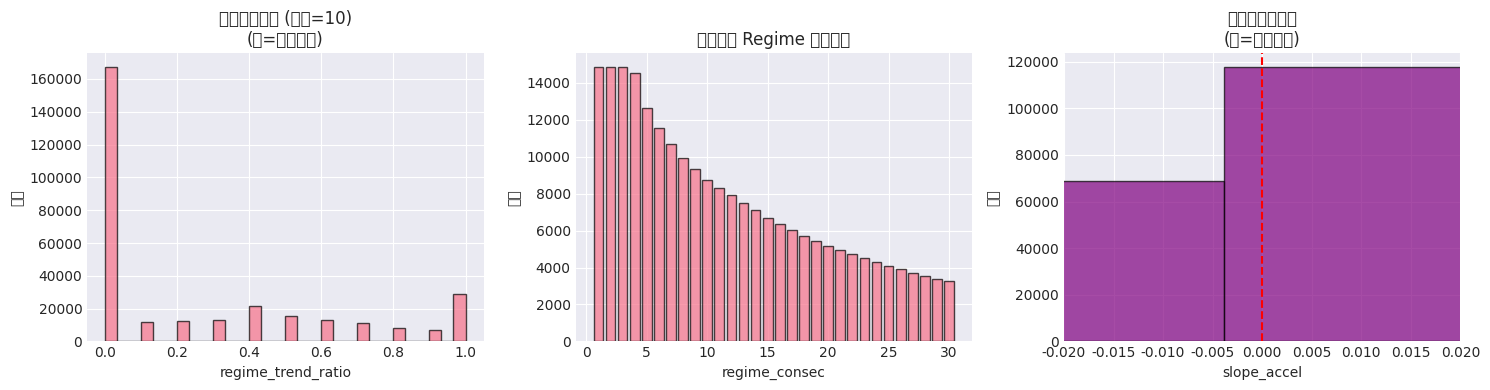


Cell 25 完成: 滞后特征 ✅


In [ ]:
# ========== Cell 25: 滞后特征 (Lagged Features) ==========
"""
📌 Section 3: 加入前几个 K 线的标签和滞后特征

添加:
1. 历史 regime 标签: regime_lag1, regime_lag2, regime_lag3
2. 历史核心特征的滞后版本
3. 窗口统计特征 (如: 最近 10 根中 regime=±1 的比例)

这些直接模拟 "盘感"：
- 模型看到"连续三根 regime=+1 且 slope_norm 都放大"，自然会把当前也判为趋势段
"""
print("计算滞后特征...")

# ========== 配置 ==========
LAG_K = 3  # 滞后期数
WINDOW_N = 10  # 统计窗口

# ========== 1. 历史 regime 标签 ==========
print("  添加 regime 滞后特征...")
for lag in range(1, LAG_K + 1):
    df[f"regime_lag{lag}"] = df["regime"].shift(lag)

# ========== 2. 核心特征的滞后版本 ==========
print("  添加核心特征滞后版本...")

# 选择需要做滞后的核心特征
lag_features = [
    "er",
    "slope_norm",
    "dist_norm",
    "chop",
    "r2",
    "range_z",
    "dir_vol_ratio",
    "bull_bear_diff",
    "avg_body_ratio",
]

for col in lag_features:
    if col in df.columns:
        for lag in range(1, LAG_K + 1):
            df[f"{col}_lag{lag}"] = df[col].shift(lag)

# ========== 3. 窗口统计特征 ==========
print("  添加窗口统计特征...")

# 最近 N 根中 regime 的统计
# 趋势比例 (regime = ±1 的比例)
df["regime_trend_ratio"] = df["regime"].abs().rolling(WINDOW_N).mean()

# 上涨趋势比例 (regime = +1 的比例)
df["regime_up_ratio"] = (df["regime"] == 1).astype(int).rolling(WINDOW_N).mean()

# 下跌趋势比例 (regime = -1 的比例)
df["regime_down_ratio"] = (df["regime"] == -1).astype(int).rolling(WINDOW_N).mean()

# regime 变化次数 (市场结构变化频率)
df["regime_change"] = (df["regime"] != df["regime"].shift(1)).astype(int)
df["regime_changes_N"] = df["regime_change"].rolling(WINDOW_N).sum()

# 连续 regime 标签数量 (模拟"趋势持续性")
@njit
def calc_consecutive_regime(regime: np.ndarray) -> np.ndarray:
    """计算连续相同 regime 的长度"""
    n = len(regime)
    consec = np.zeros(n, dtype=np.int32)

    for i in range(n):
        if i == 0 or np.isnan(regime[i]) or np.isnan(regime[i-1]):
            consec[i] = 1
        elif regime[i] == regime[i-1]:
            consec[i] = consec[i-1] + 1
        else:
            consec[i] = 1

    return consec

df["regime_consec"] = calc_consecutive_regime(df["regime"].values.astype(np.float64))

# ========== 4. 特征变化率 (momentum of features) ==========
print("  添加特征变化率...")

# 核心特征的变化率
momentum_features = ["er", "slope_norm", "chop", "range_z"]

for col in momentum_features:
    if col in df.columns:
        # 1 期变化
        df[f"{col}_diff1"] = df[col].diff(1)
        # 3 期变化
        df[f"{col}_diff3"] = df[col].diff(3)

# ========== 5. 趋势加速/减速指标 ==========
# slope_norm 的变化 (趋势加速)
df["slope_accel"] = df["slope_norm"].diff(1)
df["slope_accel_ma3"] = df["slope_accel"].rolling(3).mean()

# ========== 统计 ==========
print("\n=== 滞后特征统计 ===")
print(f"regime_trend_ratio: mean={df['regime_trend_ratio'].mean():.4f} (趋势占比)")
print(f"regime_changes_N: mean={df['regime_changes_N'].mean():.2f} (每{WINDOW_N}bar变化次数)")
print(f"regime_consec: max={df['regime_consec'].max()}, mean={df['regime_consec'].mean():.2f}")

# 检查滞后特征数量
lag_cols = [c for c in df.columns if "_lag" in c or "_diff" in c]
print(f"\n新增滞后/变化特征数量: {len(lag_cols)}")

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# regime_trend_ratio 分布
axes[0].hist(df["regime_trend_ratio"].dropna(), bins=30, edgecolor="black", alpha=0.7)
axes[0].set_xlabel("regime_trend_ratio")
axes[0].set_ylabel("数量")
axes[0].set_title(f"趋势占比分布 (窗口={WINDOW_N})\n(高=更多趋势)")

# regime_consec 分布
consec_counts = df["regime_consec"].value_counts().sort_index()
consec_counts_plot = consec_counts[consec_counts.index <= 30]  # 限制显示范围
axes[1].bar(consec_counts_plot.index, consec_counts_plot.values, edgecolor="black", alpha=0.7)
axes[1].set_xlabel("regime_consec")
axes[1].set_ylabel("数量")
axes[1].set_title("连续相同 Regime 长度分布")

# slope_accel 分布
axes[2].hist(df["slope_accel"].dropna(), bins=50, edgecolor="black", alpha=0.7, color="purple")
axes[2].axvline(x=0, color="red", linestyle="--")
axes[2].set_xlabel("slope_accel")
axes[2].set_ylabel("数量")
axes[2].set_title("斜率加速度分布\n(正=趋势加速)")
axes[2].set_xlim(-0.02, 0.02)

plt.tight_layout()
plt.show()

print("\nCell 25 完成: 滞后特征 ✅")


In [ ]:
# ========== Cell 11: 多时间周期辅助 Regime 标注 (MTF-Assisted Labeling) ==========
"""
📌 目标: 在打标签时让高周期结构成为"额外的裁判"
  - 5m 趋势如果和 60m 完全反向 → 降权或打回 0 (可能是 pullback)
  - 5m 震荡如果在强 60m 趋势中 → 标记为 "range_inside_trend"

📌 设计原则:
  - 5min 特征占 ~80% 决策权重
  - 15min/60min 占 ~20%，仅起辅助作用
  - 多周期同向时增加置信度
  - 高周期强反向时降低趋势概率
"""
print("=" * 70)
print("🔄 多时间周期辅助 Regime 标注")
print("=" * 70)

# ========== 1. 定义高周期强趋势条件 ==========
# 15min 强趋势
STRONG_15_SLOPE_THR = 0.02
STRONG_15_ER_THR = 0.4
STRONG_15_CHOP_THR = 0.6

# 60min 强趋势
STRONG_60_SLOPE_THR = 0.02
STRONG_60_ER_THR = 0.4
STRONG_60_CHOP_THR = 0.6

# MTF 权重
W_15 = 0.15  # 15min 权重
W_60 = 0.15  # 60min 权重
THR_TREND_SCORE = 1.0  # 趋势得分阈值

# 计算高周期强趋势标记
df["strong_15"] = (
    (df["slope_15_norm"].abs() > STRONG_15_SLOPE_THR) &
    (df["er_15"] > STRONG_15_ER_THR) &
    (df["chop_15"] < STRONG_15_CHOP_THR)
).astype(int)

df["strong_60"] = (
    (df["slope_60_norm"].abs() > STRONG_60_SLOPE_THR) &
    (df["er_60"] > STRONG_60_ER_THR) &
    (df["chop_60"] < STRONG_60_CHOP_THR)
).astype(int)

print(f"\n强 15min 趋势 bar 比例: {df['strong_15'].mean()*100:.1f}%")
print(f"强 60min 趋势 bar 比例: {df['strong_60'].mean()*100:.1f}%")

# ========== 2. 带 MTF 辅助的趋势识别 ==========
def identify_trend_with_mtf(df: pd.DataFrame, is_range: np.ndarray,
                             w_15: float = 0.15, w_60: float = 0.15,
                             thr_score: float = 1.0) -> np.ndarray:
    """
    带多时间周期辅助的趋势识别

    趋势得分 = base_score + mtf_bonus - mtf_penalty
    - base_score: 基于 5min 的原始条件 (0-1)
    - mtf_bonus: 高周期同向加分
    - mtf_penalty: 高周期反向减分
    """
    n = len(df)
    regime = np.zeros(n, dtype=np.int32)
    trend_scores = np.zeros(n, dtype=np.float64)

    # 预提取数组 (加速)
    er = df["er"].values
    chop = df["chop"].values
    slope_norm = df["slope_norm"].values
    dist_norm = df["dist_norm"].values
    d_barrier = df["d_barrier"].values
    close = df["close"].values

    # 高周期信息
    trend_dir_15 = df["trend_dir_15"].fillna(0).values
    trend_dir_60 = df["trend_dir_60"].fillna(0).values
    strong_15 = df["strong_15"].fillna(0).values
    strong_60 = df["strong_60"].fillna(0).values
    er_15 = df["er_15"].fillna(0).values
    er_60 = df["er_60"].fillna(0).values

    for t in range(n):
        if is_range[t]:
            regime[t] = 0
            continue

        if np.isnan(slope_norm[t]) or np.isnan(er[t]):
            continue

        # ========== 5min 基础得分 ==========
        dir_5 = np.sign(slope_norm[t])
        if dir_5 == 0:
            continue

        # 方向一致性 (使用未来 L_FWD 的收益)
        future_idx = min(t + L_FWD, n - 1)
        future_direction = np.sign(close[future_idx] - close[t])
        direction_consistent = (dir_5 == future_direction) and (dir_5 != 0)

        # 构建 base_score (0-1 区间)
        base_score = 0.0

        # 方向一致 +0.3
        if direction_consistent:
            base_score += 0.3

        # 斜率强度 +0.2
        if abs(slope_norm[t]) > THR_SLOPE_NORM:
            base_score += 0.2

        # 趋势质量 (ER 高或 chop 低) +0.25
        if er[t] > THR_ER_HIGH or chop[t] < THR_CHOP_LOW:
            base_score += 0.25

        # 价格偏离 +0.15
        if abs(dist_norm[t]) > THR_DIST_NORM:
            base_score += 0.15

        # Triple barrier 确认 +0.1
        if d_barrier[t] == dir_5:
            base_score += 0.1

        # ========== MTF 加减分 ==========
        mtf_adjustment = 0.0

        # 15min 同向加分
        if trend_dir_15[t] == dir_5 and trend_dir_15[t] != 0:
            mtf_adjustment += w_15

        # 60min 同向加分
        if trend_dir_60[t] == dir_5 and trend_dir_60[t] != 0:
            mtf_adjustment += w_60

        # 高周期强反向 → 大幅减分 (可能是 counter-trend pullback)
        if strong_60[t] and trend_dir_60[t] == -dir_5:
            base_score *= 0.5

        # 多周期完全混乱 → 小幅降权
        mtf_align = dir_5 + trend_dir_15[t] + trend_dir_60[t]
        if abs(mtf_align) <= 1:
            base_score *= 0.85

        # 最终得分
        final_score = base_score + mtf_adjustment
        trend_scores[t] = final_score

        # 判定
        if final_score >= thr_score:
            regime[t] = int(dir_5)

    return regime, trend_scores


# ========== 3. 带 MTF 过滤的震荡识别 ==========
def identify_range_with_mtf_filter(df: pd.DataFrame, is_range_5m: np.ndarray) -> tuple:
    """
    在 5min 震荡基础上，标记"强趋势中的震荡"

    返回:
        is_range_final: 最终震荡标记
        is_range_in_trend: 强趋势中的震荡标记 (从训练集剔除)
    """
    n = len(df)
    is_range_final = is_range_5m.copy()
    is_range_in_trend = np.zeros(n, dtype=bool)

    strong_60 = df["strong_60"].fillna(0).values
    er_60 = df["er_60"].fillna(0.5).values
    chop_60 = df["chop_60"].fillna(0.5).values

    for t in range(n):
        if is_range_5m[t]:
            # 如果 60min 是强趋势，标记为 "range_inside_trend"
            if strong_60[t] and er_60[t] > 0.45 and chop_60[t] < 0.55:
                is_range_in_trend[t] = True
                # 可选: 保持 is_range_final[t] = True (仍然是震荡，但训练时剔除)

    return is_range_final, is_range_in_trend


# ========== 4. 执行 MTF 辅助标注 ==========
print("\n执行 MTF 辅助标注...")

# 使用原始的 5m 震荡判定
is_range_5m = df["is_range_extended"].values if "is_range_extended" in df.columns else df["is_range"].values

# MTF 过滤震荡
is_range_mtf, is_range_in_trend = identify_range_with_mtf_filter(df, is_range_5m)

# MTF 辅助趋势识别
regime_mtf_raw, trend_scores = identify_trend_with_mtf(
    df, is_range_mtf,
    w_15=W_15, w_60=W_60, thr_score=THR_TREND_SCORE
)

# 应用平滑 (与原方法相同)
regime_mtf = smooth_regime_labels(regime_mtf_raw, MIN_TREND_LEN, SMOOTH_WINDOW)

# 保存结果
df["regime_mtf"] = regime_mtf
df["trend_score_mtf"] = trend_scores
df["is_range_in_trend"] = is_range_in_trend

# ========== 5. 统计对比 ==========
print("\n" + "=" * 70)
print("📊 原始 vs MTF 辅助 Regime 分布对比")
print("=" * 70)

# 原始分布
orig_counts = df["regime"].value_counts().sort_index()
mtf_counts = df["regime_mtf"].value_counts().sort_index()

print("\n原始方法:")
for k, v in orig_counts.items():
    label = {-1: "DOWN", 0: "RANGE", 1: "UP"}.get(k, str(k))
    print(f"  {label}: {v:,} ({v/len(df)*100:.2f}%)")

print("\nMTF 辅助方法:")
for k, v in mtf_counts.items():
    label = {-1: "DOWN", 0: "RANGE", 1: "UP"}.get(k, str(k))
    print(f"  {label}: {v:,} ({v/len(df)*100:.2f}%)")

# 标签变化统计
changed = (df["regime"] != df["regime_mtf"]).sum()
print(f"\n标签变化数量: {changed:,} ({changed/len(df)*100:.2f}%)")

# 强趋势中的震荡数量
range_in_trend_count = df["is_range_in_trend"].sum()
print(f"强趋势中的震荡 bar: {range_in_trend_count:,} ({range_in_trend_count/len(df)*100:.2f}%)")

print("\nCell 11 完成: MTF 辅助标注 ✅")


🔄 多时间周期辅助 Regime 标注

强 15min 趋势 bar 比例: 6.1%
强 60min 趋势 bar 比例: 0.7%

执行 MTF 辅助标注...

📊 原始 vs MTF 辅助 Regime 分布对比

原始方法:
  DOWN: 31,812 (10.28%)
  RANGE: 228,526 (73.86%)
  UP: 49,074 (15.86%)

MTF 辅助方法:
  DOWN: 26,253 (8.48%)
  RANGE: 242,237 (78.29%)
  UP: 40,922 (13.23%)

标签变化数量: 30,187 (9.76%)
强趋势中的震荡 bar: 0 (0.00%)

Cell 11 完成: MTF 辅助标注 ✅


## Cell 12: 原始 vs MTF 辅助标注 并排可视化对比

In [ ]:
# ========== Cell 12: 原始 vs MTF 辅助标注 并排可视化对比 ==========
"""
📌 Side-by-side 对比原始方法和 MTF 辅助方法的 regime 标注结果
   用于决定最终采用哪种方法
"""
from bokeh.layouts import row as bokeh_row

print("生成原始 vs MTF 对比图表...")

# ========== 1. 修改绘图函数以支持不同 regime 列 ==========
def plot_kline_comparison(df_day: pd.DataFrame, regime_col: str, title: str, width: int = 600) -> figure:
    """
    绘制单日 K 线图，支持指定 regime 列
    """
    df_day = df_day.copy().reset_index(drop=True)
    df_day["idx"] = range(len(df_day))

    # 创建图表
    p = figure(
        width=width, height=350,
        title=title,
        x_axis_label="Bar Index",
        y_axis_label="Price",
        tools="pan,wheel_zoom,box_zoom,reset,save",
    )

    # 添加 regime 背景色
    regime_colors = {-1: "#FFCCCC", 0: "#FFFFCC", 1: "#CCFFCC"}

    # 按 regime 分段添加背景
    current_regime = None
    start_idx = 0

    for i in range(len(df_day)):
        r = df_day[regime_col].iloc[i] if not pd.isna(df_day[regime_col].iloc[i]) else 0
        r = int(r)

        if current_regime is None:
            current_regime = r
            start_idx = i
        elif r != current_regime or i == len(df_day) - 1:
            # 添加前一段的背景
            end_idx = i if r != current_regime else i + 1
            y_min = df_day["low"].iloc[start_idx:end_idx].min() - 1
            y_max = df_day["high"].iloc[start_idx:end_idx].max() + 1

            box = BoxAnnotation(
                left=start_idx - 0.5, right=end_idx - 0.5,
                fill_color=regime_colors.get(current_regime, "#FFFFFF"),
                fill_alpha=0.3, level="underlay"
            )
            p.add_layout(box)

            current_regime = r
            start_idx = i

    # 绘制 K 线
    # 阳线 (上涨)
    bull_mask = df_day["close"] >= df_day["open"]
    bear_mask = ~bull_mask

    # 阳线实体
    bull_idx = df_day[bull_mask]["idx"]
    if len(bull_idx) > 0:
        p.segment(x0=bull_idx, y0=df_day[bull_mask]["low"],
                  x1=bull_idx, y1=df_day[bull_mask]["high"], color="green", line_width=1)
        p.vbar(x=bull_idx, width=0.6, top=df_day[bull_mask]["close"],
               bottom=df_day[bull_mask]["open"], fill_color="green", line_color="green")

    # 阴线实体
    bear_idx = df_day[bear_mask]["idx"]
    if len(bear_idx) > 0:
        p.segment(x0=bear_idx, y0=df_day[bear_mask]["low"],
                  x1=bear_idx, y1=df_day[bear_mask]["high"], color="red", line_width=1)
        p.vbar(x=bear_idx, width=0.6, top=df_day[bear_mask]["open"],
               bottom=df_day[bear_mask]["close"], fill_color="red", line_color="red")

    p.xaxis.visible = False

    return p


# ========== 2. 选择日期进行对比 ==========
# 准备绘图数据
df_plot = df.reset_index()
df_plot["timestamp_dt"] = pd.to_datetime(df_plot["timestamp"].astype(str).str.slice(0, 19))
df_plot["date"] = df_plot["timestamp_dt"].dt.date

valid_dates = df_plot.groupby("date").size()
valid_dates = valid_dates[valid_dates >= 50].index.tolist()

# 随机选择 5 个日期进行对比
np.random.seed(42)
sample_dates = np.random.choice(valid_dates, size=min(5, len(valid_dates)), replace=False)

print(f"选择 {len(sample_dates)} 个日期进行对比:")
for d in sample_dates:
    print(f"  - {d}")

# ========== 3. 生成并排对比图 ==========
comparison_plots = []

for date in sample_dates:
    df_day = df_plot[df_plot["date"] == date].copy()

    if len(df_day) < 30:
        continue

    # 统计该日的标签变化
    orig_counts = df_day["regime"].value_counts().to_dict()
    mtf_counts = df_day["regime_mtf"].value_counts().to_dict()
    changes = (df_day["regime"] != df_day["regime_mtf"]).sum()

    # 原始方法图
    title_orig = f"{date} - 原始方法 | D:{orig_counts.get(-1,0)} R:{orig_counts.get(0,0)} U:{orig_counts.get(1,0)}"
    p_orig = plot_kline_comparison(df_day, "regime", title_orig, width=550)

    # MTF 辅助方法图
    title_mtf = f"{date} - MTF辅助 | D:{mtf_counts.get(-1,0)} R:{mtf_counts.get(0,0)} U:{mtf_counts.get(1,0)} | 变化:{changes}"
    p_mtf = plot_kline_comparison(df_day, "regime_mtf", title_mtf, width=550)

    # 并排布局
    comparison_plots.append(bokeh_row(p_orig, p_mtf))

if comparison_plots:
    comparison_layout = column(*comparison_plots)
    show(comparison_layout)

    # 保存对比图
    chart_path = OUTPUT_DIR_CHARTS / "regime_comparison_orig_vs_mtf.html"
    output_file(str(chart_path))
    save(comparison_layout, filename=str(chart_path), title="Regime Comparison: Original vs MTF")
    print(f"\n对比图已保存到: {chart_path}")

# ========== 4. 汇总统计 ==========
print("\n" + "=" * 70)
print("📊 方法对比汇总")
print("=" * 70)

# 计算变化矩阵
print("\n标签变化矩阵 (行=原始, 列=MTF):")
change_matrix = pd.crosstab(df["regime"], df["regime_mtf"], margins=True, margins_name="Total")
print(change_matrix)

# 趋势识别率对比
orig_trend_rate = (df["regime"] != 0).mean() * 100
mtf_trend_rate = (df["regime_mtf"] != 0).mean() * 100
print(f"\n趋势识别率:")
print(f"  原始方法: {orig_trend_rate:.2f}%")
print(f"  MTF 辅助: {mtf_trend_rate:.2f}%")

# 多周期一致性分析
mtf_align = df["mtf_trend_alignment"].dropna()
print(f"\n多周期一致性分布 (原始趋势样本):")
trend_samples = df[df["regime"] != 0]["mtf_trend_alignment"].dropna()
for v in sorted(trend_samples.unique()):
    count = (trend_samples == v).sum()
    print(f"  alignment={int(v)}: {count:,} ({count/len(trend_samples)*100:.1f}%)")

print("\nCell 12 完成: 对比可视化 ✅")
print("\n" + "=" * 70)
print("⚠️ 请查看上方对比图，决定是否采用 MTF 辅助方法")
print("   如果满意，后续将使用 regime_mtf 作为最终标签")
print("=" * 70)


生成原始 vs MTF 对比图表...
选择 5 个日期进行对比:
  - 2017-11-03
  - 2015-06-25
  - 2021-02-17
  - 2020-03-06
  - 2022-09-20



对比图已保存到: market_cycle/charts/regime_comparison_orig_vs_mtf.html

📊 方法对比汇总

标签变化矩阵 (行=原始, 列=MTF):
regime_mtf     -1       0      1   Total
regime                                  
-1          22412    9400      0   31812
0            3841  220288   4397  228526
1               0   12549  36525   49074
Total       26253  242237  40922  309412

趋势识别率:
  原始方法: 26.14%
  MTF 辅助: 21.71%

多周期一致性分布 (原始趋势样本):
  alignment=-3: 16,416 (20.3%)
  alignment=-2: 1,807 (2.2%)
  alignment=-1: 13,805 (17.1%)
  alignment=0: 514 (0.6%)
  alignment=1: 16,964 (21.0%)
  alignment=2: 2,980 (3.7%)
  alignment=3: 28,400 (35.1%)

Cell 12 完成: 对比可视化 ✅

⚠️ 请查看上方对比图，决定是否采用 MTF 辅助方法
   如果满意，后续将使用 regime_mtf 作为最终标签


In [ ]:
# ========== Cell 26: 最终特征矩阵 & 数据导出 (Final Feature Matrix) ==========
"""
📌 最终准备机器学习训练数据

关键更新:
1. 使用 regime_mtf (多周期辅助标注) 作为标签 (可切换为原始 regime)
2. 排除原始尺度特征 (kama, atr, tr, bar_range)，使用归一化版本 (*_z)
3. d_barrier 只用于标注，不输入模型训练 (它使用了未来信息)

泄露检查清单:
✅ 无泄露: 使用 shift/rolling 的过去窗口特征
✅ 无泄露: 使用 expanding (累积到当前) 的特征
✅ 无泄露: 多周期特征使用 floor - 1 周期对齐
❌ 泄露: d_barrier (使用了未来路径) → 排除
"""
print("准备最终特征矩阵...")

# ═══════════════════════════════════════════════════════════════════════════════
# ⚠️ 选择使用哪个 regime 作为标签
# ═══════════════════════════════════════════════════════════════════════════════
USE_MTF_REGIME = True  # True: 使用 MTF 辅助标签, False: 使用原始标签

LABEL_COL = "regime_mtf" if USE_MTF_REGIME else "regime"
print(f"\n使用标签列: {LABEL_COL}")

# ========== 1. 定义特征列表 (已排除原始尺度特征) ==========

# 基础波动特征 (已归一化)
volatility_features = [
    "log_return",       # 当前收益 (无量纲)
    "range_atr",        # 区间/ATR (比例)
    "range_z",          # Range z-score
    "range_z_ma5",      # Range z-score 均值
    "atr_z",            # ATR 归一化
    "tr_z",             # TR 归一化 (如果存在)
    "bar_range_z",      # Bar range 归一化 (如果存在)
]

# 趋势特征 (无泄露 - 全部使用过去窗口)
trend_features = [
    "er",               # 效率因子 [0,1]
    "slope_norm",       # KAMA 斜率标准化 (相对 ATR)
    "dist_norm",        # 价格偏离度 (相对 ATR)
    "kama_z",           # KAMA 归一化 (如果存在)
    "beta",             # 回归斜率
    "r2",               # R² [0,1]
    "slope_10_norm",    # 10-bar 斜率
    "slope_30_norm",    # 30-bar 斜率
    "slope_60_norm",    # 60-bar 斜率
    "trend_alignment",  # 多尺度一致性 [-3, +3]
]

# 震荡特征 (无泄露)
range_features = [
    "chop",             # Choppiness Index [0,1]
    "overlap_ratio",    # 重叠度 [0,1]
    "dir_vol_ratio",    # 方向性波动 [0,1]
    "vol_up_ratio",     # 上涨波动占比 [0,1]
]

# Bar 结构特征 (无泄露)
bar_structure_features = [
    "is_bull",          # 阳线 {0,1}
    "is_bear",          # 阴线 {0,1}
    "bull_ratio",       # 阳线比例 [0,1]
    "bear_ratio",       # 阴线比例 [0,1]
    "bull_bear_diff",   # 多空差 [-1,1]
    "consec_bull",      # 连续阳线
    "consec_bear",      # 连续阴线
    "body_ratio",       # 实体比例 [0,1]
    "upper_wick_ratio", # 上影线比例 [0,1]
    "lower_wick_ratio", # 下影线比例 [0,1]
    "total_wick_ratio", # 总影线比例 [0,1]
    "avg_body_ratio",   # 窗口平均实体比例
    "avg_total_wick_ratio",  # 窗口平均影线比例
    "doji_like_ratio",  # 小实体大影线比例 [0,1]
]

# 腿结构特征 (无泄露 - 全部基于过去)
leg_features = [
    "legA_dir", "legA_prev1_dir", "legA_prev2_dir", "legA_changes_10",
    "legB_dir", "legB_prev1_dir", "legB_prev2_dir", "legB_changes_10",
    "legC_dir", "legC_prev1_dir", "legC_prev2_dir", "legC_changes_10",
]

# Phase 特征 (无泄露)
phase_features = [
    "spike_score",      # Spike 分数 [0,1]
    "channel_score",    # Channel 分数 [0,1]
    "phase",            # Phase {0,1,2}
]

# 日内特征 (无泄露 - expanding)
intraday_features = [
    "pos_in_day_range", # 日内位置 [0,1]
    "dist_to_open",     # 距开盘价
    "day_return",       # 日内收益
    "bar_of_day",       # 当日第几根 bar
    "time_of_day_norm", # 时间归一化 [0,1]
    "near_day_high",    # 接近日高 {0,1}
    "near_day_low",     # 接近日低 {0,1}
    "near_open",        # 接近开盘 {0,1}
    "is_open_range",    # 开盘阶段 {0,1}
    "is_close_range",   # 收盘阶段 {0,1}
]

# 多周期特征 (无泄露 - 使用 floor-1 对齐)
mtf_features = [
    "er_15", "slope_15_norm", "chop_15", "trend_dir_15",
    "er_60", "slope_60_norm", "chop_60", "trend_dir_60",
    "atr_ratio_15_5", "atr_ratio_60_5", "mtf_trend_alignment",
]

# 滞后特征 (无泄露 - shift)
lag_features = []
for lag in range(1, 4):
    lag_features.extend([
        f"er_lag{lag}", f"slope_norm_lag{lag}", f"dist_norm_lag{lag}",
        f"chop_lag{lag}", f"r2_lag{lag}", f"range_z_lag{lag}",
        f"dir_vol_ratio_lag{lag}", f"bull_bear_diff_lag{lag}",
        f"avg_body_ratio_lag{lag}",
    ])

# 统计特征 (无泄露)
stat_features = [
    "regime_trend_ratio", "regime_up_ratio", "regime_down_ratio",
    "regime_changes_N", "regime_consec",
    "er_diff1", "er_diff3", "slope_norm_diff1", "slope_norm_diff3",
    "chop_diff1", "chop_diff3", "range_z_diff1", "range_z_diff3",
    "slope_accel", "slope_accel_ma3",
]

# Volume 特征 (如果存在)
volume_features = ["volume_z", "log_volume_z"]

# ========== 2. 合并所有特征并过滤存在的列 ==========
all_features = (
    volatility_features + trend_features + range_features +
    bar_structure_features + leg_features + phase_features +
    intraday_features + mtf_features + lag_features + stat_features +
    volume_features
)

# 明确排除的特征 (原始尺度或泄露)
EXCLUDED_FEATURES = [
    "kama", "atr", "tr", "bar_range", "volume",  # 原始尺度
    "d_barrier", "regime_raw", "is_range", "is_range_extended",  # 泄露或辅助标记
    "is_range_in_trend", "strong_15", "strong_60", "trend_score_mtf",  # 辅助变量
]

# 过滤: 只保留存在且未排除的特征
training_features = [
    col for col in all_features
    if col in df.columns and col not in EXCLUDED_FEATURES
]

print(f"\n可用特征数量: {len(training_features)}")

# ========== 3. 构建训练数据 ==========
# 过滤有效样本 (非 NaN)
df_train = df.dropna(subset=[LABEL_COL]).copy()

# 构建 X 和 y
X = df_train[training_features].copy()
y = df_train[LABEL_COL].astype(int).copy()

# 过滤掉特征中有 NaN 的行
valid_mask = X.notna().all(axis=1)
X = X[valid_mask]
y = y[valid_mask]
df_train = df_train[valid_mask]

print(f"有效样本数: {len(X):,} / {len(df):,} ({len(X)/len(df)*100:.1f}%)")
print(f"特征数: {X.shape[1]}")

# ========== 4. 特征统计 ==========
print("\n" + "=" * 70)
print("📊 特征统计")
print("=" * 70)

# 按类别统计
feature_categories = {
    "波动": volatility_features,
    "趋势": trend_features,
    "震荡": range_features,
    "Bar结构": bar_structure_features,
    "腿结构": leg_features,
    "Phase": phase_features,
    "日内": intraday_features,
    "多周期": mtf_features,
    "滞后": lag_features,
    "统计": stat_features,
}

for cat, feats in feature_categories.items():
    available = [f for f in feats if f in training_features]
    print(f"  {cat}: {len(available)} 个特征")

# ========== 5. 标签分布 ==========
print("\n" + "=" * 70)
print(f"📊 标签分布 ({LABEL_COL})")
print("=" * 70)

label_counts = y.value_counts().sort_index()
for k, v in label_counts.items():
    label_name = {-1: "DOWN (-1)", 0: "RANGE (0)", 1: "UP (+1)"}.get(k, str(k))
    print(f"  {label_name}: {v:,} ({v/len(y)*100:.2f}%)")

# ========== 6. 导出训练数据 ==========
print("\n" + "=" * 70)
print("💾 导出训练数据")
print("=" * 70)

# 准备导出数据
df_train = df_train.reset_index()
df_train["timestamp_str"] = df_train["timestamp"].astype(str)
df_train["year"] = pd.to_datetime(df_train["timestamp_str"].str[:10]).dt.year
df_train["month"] = pd.to_datetime(df_train["timestamp_str"].str[:10]).dt.month
df_train["date"] = df_train["timestamp_str"].str[:10]

# 选择要导出的列
export_meta = ["timestamp_str", "year", "month", "date", "open", "high", "low", "close", "volume"]
export_cols = export_meta + training_features + [LABEL_COL]
export_cols = [c for c in export_cols if c in df_train.columns]

# 去重
export_cols = list(dict.fromkeys(export_cols))

df_export = df_train[export_cols].copy()
df_export = df_export.rename(columns={"timestamp_str": "timestamp", LABEL_COL: "regime"})

# 导出
OUTPUT_TRAIN_CSV = OUTPUT_DIR_FEATURES / "market_cycle_train_data.csv"
OUTPUT_TRAIN_PARQUET = OUTPUT_DIR_FEATURES / "market_cycle_train_data.parquet"

df_export.to_csv(OUTPUT_TRAIN_CSV, index=False)
df_export.to_parquet(OUTPUT_TRAIN_PARQUET, index=False)

print(f"\n📁 训练数据已导出:")
print(f"   - CSV: {OUTPUT_TRAIN_CSV}")
print(f"   - Parquet: {OUTPUT_TRAIN_PARQUET}")
print(f"   - 样本数: {len(df_export):,}")
print(f"   - 特征数: {len(training_features)}")

# ========== 7. 数据泄露最终检查 ==========
print("\n" + "=" * 70)
print("🔍 数据泄露检查")
print("=" * 70)

# 检查是否有未来信息特征
future_keywords = ["_fwd", "future", "barrier"]
potential_leak = [c for c in training_features if any(k in c.lower() for k in future_keywords)]
if potential_leak:
    print(f"⚠️ 发现可能泄露的特征: {potential_leak}")
else:
    print("✅ 未发现明显的数据泄露")

# 检查原始尺度特征
raw_scale_in_train = [c for c in ["kama", "atr", "tr", "bar_range"] if c in training_features]
if raw_scale_in_train:
    print(f"⚠️ 训练集中包含原始尺度特征: {raw_scale_in_train}")
else:
    print("✅ 原始尺度特征已排除")

print("\nCell 26 完成: 最终特征矩阵准备完毕 ✅")
print("\n🎉 数据准备完成！可以开始机器学习训练了！")


准备最终特征矩阵...

使用标签列: regime_mtf

可用特征数量: 114
有效样本数: 285,377 / 309,412 (92.2%)
特征数: 114

📊 特征统计
  波动: 6 个特征
  趋势: 10 个特征
  震荡: 4 个特征
  Bar结构: 14 个特征
  腿结构: 12 个特征
  Phase: 3 个特征
  日内: 10 个特征
  多周期: 11 个特征
  滞后: 27 个特征
  统计: 15 个特征

📊 标签分布 (regime_mtf)
  DOWN (-1): 24,993 (8.76%)
  RANGE (0): 221,367 (77.57%)
  UP (+1): 39,017 (13.67%)

💾 导出训练数据

📁 训练数据已导出:
   - CSV: market_cycle/features/market_cycle_train_data.csv
   - Parquet: market_cycle/features/market_cycle_train_data.parquet
   - 样本数: 285,377
   - 特征数: 114

🔍 数据泄露检查
✅ 未发现明显的数据泄露
✅ 原始尺度特征已排除

Cell 26 完成: 最终特征矩阵准备完毕 ✅

🎉 数据准备完成！可以开始机器学习训练了！


In [ ]:
# ========== Save Sequence Data for Deep Learning ==========
"""
📌 Save preprocessed sequence data for Notebook 3 (Deep Learning)
This allows Notebook 3 to load pre-computed sequences instantly
"""
import numpy as np
from sklearn.preprocessing import StandardScaler

print("=" * 70)
print("💾 Saving Sequence Data for Deep Learning")
print("=" * 70)

# Load the training data
df_seq = pd.read_parquet(OUTPUT_DIR_FEATURES / "market_cycle_train_data.parquet")

# Define feature columns
meta_cols = ["timestamp", "year", "month", "date", "open", "high", "low", "close", "volume", "regime"]
feature_cols = [c for c in df_seq.columns if c not in meta_cols]

# Known future features (time-based, can be known in advance)
known_future_features = ["time_of_day_norm", "bar_of_day", "is_open_range", "is_close_range"]
known_future_features = [f for f in known_future_features if f in feature_cols]
observed_features = [f for f in feature_cols if f not in known_future_features]

# Label mapping
label_mapping = {-1: 0, 0: 1, 1: 2}
df_seq["label"] = df_seq["regime"].map(label_mapping)

# Standardize features
X_raw = df_seq[feature_cols].values.astype(np.float32)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Create date arrays
df_seq["date_str"] = df_seq["date"].astype(str)
dates = df_seq["date_str"].values

# Sequence generation parameters
SEQ_LEN = 30

def create_sequences(X, y, dates, seq_len=30):
    """Create sliding window sequences, handling day boundaries"""
    N = len(X)
    sequences_X, sequences_y, indices = [], [], []

    for i in range(seq_len - 1, N):
        start_idx = i - seq_len + 1
        seq_dates = dates[start_idx:i+1]

        # Skip if sequence crosses day boundary
        if len(set(seq_dates)) > 1:
            continue

        seq_X = X[start_idx:i+1]
        if np.isnan(seq_X).any():
            continue

        sequences_X.append(seq_X)
        sequences_y.append(y[i])
        indices.append(i)

    return np.array(sequences_X, dtype=np.float32), np.array(sequences_y, dtype=np.int64), np.array(indices)

print("Creating sequences...")
y_raw = df_seq["label"].values
X_seq, y_seq, seq_indices = create_sequences(X_scaled, y_raw, dates, seq_len=SEQ_LEN)

# Feature indices for TFT
known_indices = [feature_cols.index(f) for f in known_future_features if f in feature_cols]
observed_indices = [feature_cols.index(f) for f in observed_features if f in feature_cols]

# Save everything
output_path = OUTPUT_DIR_FEATURES / "sequence_data.npz"
np.savez_compressed(
    output_path,
    X_seq=X_seq,
    y_seq=y_seq,
    seq_indices=seq_indices,
    known_indices=np.array(known_indices),
    observed_indices=np.array(observed_indices),
    seq_dates=dates[seq_indices],
    scaler_mean=scaler.mean_,
    scaler_scale=scaler.scale_,
    feature_cols=np.array(feature_cols),
    known_features=np.array(known_future_features),
    observed_features=np.array(observed_features),
    label_names=np.array(["DOWN", "RANGE", "UP"])
)

print(f"\n✅ Sequence data saved to: {output_path}")
print(f"   Sequences: {X_seq.shape}")
print(f"   Features: {len(feature_cols)}")
print(f"   Known features: {len(known_indices)}")
print(f"   Observed features: {len(observed_indices)}")
print("\n" + "=" * 70)
print("🎉 Notebook 1 完成! 请继续运行 Notebook 2 或 3")
print("=" * 70)

💾 Saving Sequence Data for Deep Learning
Creating sequences...

✅ Sequence data saved to: market_cycle/features/sequence_data.npz
   Sequences: (170333, 30, 113)
   Features: 113
   Known features: 4
   Observed features: 109

🎉 Notebook 1 完成! 请继续运行 Notebook 2 或 3


## HMM 标注

In [ ]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'log_close', 'log_return',
       'tr', 'atr', 'roll_max',
       ...
       'chop_diff3', 'range_z_diff1', 'range_z_diff3', 'slope_accel',
       'slope_accel_ma3', 'strong_15', 'strong_60', 'regime_mtf',
       'trend_score_mtf', 'is_range_in_trend'],
      dtype='object', length=165)

In [ ]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 5.2 MB/s eta 0:00:00


In [ ]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'log_close', 'log_return',
       'tr', 'atr', 'roll_max',
       ...
       'range_z_diff3', 'slope_accel', 'slope_accel_ma3', 'strong_15',
       'strong_60', 'regime_mtf', 'trend_score_mtf', 'is_range_in_trend',
       'regime_hmm_raw', 'regime_hmm'],
      dtype='object', length=167)

In [ ]:
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. 取出特征，并处理 NaN / inf
# feat_cols = ["log_return", "atr", "slope_norm"]
# feat_cols = ['open', 'high', 'low', 'close', 'volume']
# feat_cols = ["regime", 'regime_mtf']
feat_cols = ["log_return", "ret_vol"]
df["ret_vol"] = df["log_return"].rolling(20).std()

# 先替换 inf，再 dropna
features = df[feat_cols].replace([np.inf, -np.inf], np.nan).dropna()

# 记住它的索引，后面要贴回去
valid_idx = features.index

# 2. 特征缩放（HMM 对尺度比较敏感，建议标准化）
scaler = StandardScaler()
X = scaler.fit_transform(features.values)

# 3. 训练 HMM
hmm = GaussianHMM(
    n_components=3,          # 想分几种 regime
    covariance_type="full",
    n_iter=200,
    random_state=42
)
hmm.fit(X)

# 4. 预测隐藏状态
hidden_states = hmm.predict(X)   # 这里不会再有 NaN 报错

# 5. 把状态贴回原 df（其他位置保持 NaN）
df["regime_hmm_raw"] = np.nan
df.loc[valid_idx, "regime_hmm_raw"] = hidden_states


In [ ]:
df["regime_hmm_raw"].value_counts(dropna=False)

,count
regime_hmm_raw,
0.0,141228
1.0,119273
2.0,48891
NaN,20


In [ ]:
df["regime_mtf"].value_counts(dropna=False)

,count
regime_mtf,
0,242237
1,40922
-1,26253


In [ ]:
state_returns = (
    # features["log_return"]
    # features["open"]
    features["regime"]
    .groupby(hidden_states)
    .mean()
    .sort_values()
)

# 从低到高：最差 = 下跌，中间 = 震荡，最好 = 上涨
state_to_regime = {}
state_to_regime[state_returns.index[0]] = -1   # 最差
state_to_regime[state_returns.index[1]] = 1    # 中
state_to_regime[state_returns.index[2]] = 0    # 最好

df["regime_hmm"] = df["regime_hmm_raw"].map(state_to_regime)


### 原始 vs MTF vs HMM 辅助标注

In [ ]:
# ========== Cell 12: 原始 vs MTF vs HMM 辅助标注 并排可视化对比 ==========
"""
📌 Side-by-side 对比三种方法的 regime 标注结果：
   1. 原始方法  (regime)
   2. MTF 辅助 (regime_mtf)
   3. HMM 方法 (regime_hmm)
"""

from bokeh.layouts import row as bokeh_row

print("生成 原始 vs MTF vs HMM 对比图表...")

# ========== 1. 绘图函数（不需要改动太多，只是通用 regime 列） ==========
def plot_kline_comparison(
    df_day: pd.DataFrame,
    regime_col: str,
    title: str,
    width: int = 400
) -> figure:
    """
    绘制单日 K 线图，支持指定 regime 列
    """
    df_day = df_day.copy().reset_index(drop=True)
    df_day["idx"] = range(len(df_day))

    # 创建图表
    p = figure(
        width=width, height=350,
        title=title,
        x_axis_label="Bar Index",
        y_axis_label="Price",
        tools="pan,wheel_zoom,box_zoom,reset,save",
    )

    # regime 背景色
    regime_colors = {-1: "#FFCCCC", 0: "#FFFFCC", 1: "#CCFFCC"}

    # 按 regime 分段添加背景
    current_regime = None
    start_idx = 0

    for i in range(len(df_day)):
        r_val = df_day[regime_col].iloc[i]
        r = int(r_val) if not pd.isna(r_val) else 0

        if current_regime is None:
            current_regime = r
            start_idx = i
        elif r != current_regime or i == len(df_day) - 1:
            # 结束上一段
            end_idx = i if r != current_regime else i + 1
            y_min = df_day["low"].iloc[start_idx:end_idx].min() - 1
            y_max = df_day["high"].iloc[start_idx:end_idx].max() + 1

            box = BoxAnnotation(
                left=start_idx - 0.5, right=end_idx - 0.5,
                fill_color=regime_colors.get(current_regime, "#FFFFFF"),
                fill_alpha=0.3, level="underlay"
            )
            p.add_layout(box)

            current_regime = r
            start_idx = i

    # 绘制 K 线
    bull_mask = df_day["close"] >= df_day["open"]
    bear_mask = ~bull_mask

    bull_idx = df_day[bull_mask]["idx"]
    if len(bull_idx) > 0:
        p.segment(
            x0=bull_idx, y0=df_day[bull_mask]["low"],
            x1=bull_idx, y1=df_day[bull_mask]["high"],
            color="green", line_width=1
        )
        p.vbar(
            x=bull_idx, width=0.6,
            top=df_day[bull_mask]["close"],
            bottom=df_day[bull_mask]["open"],
            fill_color="green", line_color="green"
        )

    bear_idx = df_day[bear_mask]["idx"]
    if len(bear_idx) > 0:
        p.segment(
            x0=bear_idx, y0=df_day[bear_mask]["low"],
            x1=bear_idx, y1=df_day[bear_mask]["high"],
            color="red", line_width=1
        )
        p.vbar(
            x=bear_idx, width=0.6,
            top=df_day[bear_mask]["open"],
            bottom=df_day[bear_mask]["close"],
            fill_color="red", line_color="red"
        )

    p.xaxis.visible = False
    return p


# ========== 2. 选择日期进行对比 ==========
df_plot = df.reset_index()
df_plot["timestamp_dt"] = pd.to_datetime(df_plot["timestamp"].astype(str).str.slice(0, 19))
df_plot["date"] = df_plot["timestamp_dt"].dt.date

valid_dates = df_plot.groupby("date").size()
valid_dates = valid_dates[valid_dates >= 50].index.tolist()

np.random.seed(42)
sample_dates = np.random.choice(valid_dates, size=min(5, len(valid_dates)), replace=False)

print(f"选择 {len(sample_dates)} 个日期进行对比:")
for d in sample_dates:
    print(f"  - {d}")


# ========== 3. 生成“三图并排”对比 ==========
comparison_plots = []

for date in sample_dates:
    df_day = df_plot[df_plot["date"] == date].copy()
    if len(df_day) < 30:
        continue

    # 各方法该日标签统计
    orig_counts = df_day["regime"].value_counts().to_dict()
    mtf_counts = df_day["regime_mtf"].value_counts().to_dict()
    hmm_counts = df_day["regime_hmm"].value_counts().to_dict()

    changes_mtf = (df_day["regime"] != df_day["regime_mtf"]).sum()
    changes_hmm = (df_day["regime"] != df_day["regime_hmm"]).sum()

    title_orig = (
        f"{date} - 原始 | "
        f"D:{orig_counts.get(-1,0)} R:{orig_counts.get(0,0)} U:{orig_counts.get(1,0)}"
    )
    title_mtf = (
        f"{date} - MTF | "
        f"D:{mtf_counts.get(-1,0)} R:{mtf_counts.get(0,0)} U:{mtf_counts.get(1,0)} "
        f"| 变更(对原始):{changes_mtf}"
    )
    title_hmm = (
        f"{date} - HMM | "
        f"D:{hmm_counts.get(-1,0)} R:{hmm_counts.get(0,0)} U:{hmm_counts.get(1,0)} "
        f"| 变更(对原始):{changes_hmm}"
    )

    p_orig = plot_kline_comparison(df_day, "regime",      title_orig, width=400)
    p_mtf  = plot_kline_comparison(df_day, "regime_mtf",  title_mtf,  width=400)
    p_hmm  = plot_kline_comparison(df_day, "regime_hmm",  title_hmm,  width=400)

    comparison_plots.append(bokeh_row(p_orig, p_mtf, p_hmm))

if comparison_plots:
    comparison_layout = column(*comparison_plots)
    show(comparison_layout)

    chart_path = OUTPUT_DIR_CHARTS / "regime_comparison_orig_vs_mtf_vs_hmm.html"
    output_file(str(chart_path))
    save(comparison_layout, filename=str(chart_path),
         title="Regime Comparison: Original vs MTF vs HMM")
    print(f"\n对比图已保存到: {chart_path}")


# ========== 4. 汇总统计 ==========
print("\n" + "=" * 70)
print("📊 三种方法对比汇总")
print("=" * 70)

print("\n标签变化矩阵 (行=原始, 列=MTF):")
change_matrix_mtf = pd.crosstab(df["regime"], df["regime_mtf"],
                                margins=True, margins_name="Total")
print(change_matrix_mtf)

print("\n标签变化矩阵 (行=原始, 列=HMM):")
change_matrix_hmm = pd.crosstab(df["regime"], df["regime_hmm"],
                                margins=True, margins_name="Total")
print(change_matrix_hmm)

# 趋势识别率对比
orig_trend_rate = (df["regime"] != 0).mean() * 100
mtf_trend_rate  = (df["regime_mtf"] != 0).mean() * 100
hmm_trend_rate  = (df["regime_hmm"] != 0).mean() * 100

print(f"\n趋势识别率:")
print(f"  原始方法: {orig_trend_rate:.2f}%")
print(f"  MTF 辅助: {mtf_trend_rate:.2f}%")
print(f"  HMM 方法: {hmm_trend_rate:.2f}%")

# 多周期一致性分析还是针对 MTF 的，不需要改
mtf_align = df["mtf_trend_alignment"].dropna()
print(f"\n多周期一致性分布 (原始趋势样本):")
trend_samples = df[df["regime"] != 0]["mtf_trend_alignment"].dropna()
for v in sorted(trend_samples.unique()):
    count = (trend_samples == v).sum()
    print(f"  alignment={int(v)}: {count:,} ({count/len(trend_samples)*100:.1f}%)")

print("\nCell 12 完成: 三方法对比可视化 ✅")
print("\n" + "=" * 70)
print("⚠️ 请查看上方三图对比，决定是否采用 MTF / HMM 作为最终标签")
print("=" * 70)


生成 原始 vs MTF vs HMM 对比图表...
选择 5 个日期进行对比:
  - 2017-11-03
  - 2015-06-25
  - 2021-02-17
  - 2020-03-06
  - 2022-09-20



对比图已保存到: market_cycle/charts/regime_comparison_orig_vs_mtf_vs_hmm.html

📊 三种方法对比汇总

标签变化矩阵 (行=原始, 列=MTF):
regime_mtf     -1       0      1   Total
regime                                  
-1          22412    9400      0   31812
0            3841  220288   4397  228526
1               0   12549  36525   49074
Total       26253  242237  40922  309412

标签变化矩阵 (行=原始, 列=HMM):
regime_hmm      -1      0      1   Total
regime                                  
-1           22412   5230   4170   31812
0           220288   4739   3499  228526
1            36525   7050   5499   49074
Total       279225  17019  13168  309412

趋势识别率:
  原始方法: 26.14%
  MTF 辅助: 21.71%
  HMM 方法: 94.50%

多周期一致性分布 (原始趋势样本):
  alignment=-3: 16,416 (20.3%)
  alignment=-2: 1,807 (2.2%)
  alignment=-1: 13,805 (17.1%)
  alignment=0: 514 (0.6%)
  alignment=1: 16,964 (21.0%)
  alignment=2: 2,980 (3.7%)
  alignment=3: 28,400 (35.1%)

Cell 12 完成: 三方法对比可视化 ✅

⚠️ 请查看上方三图对比，决定是否采用 MTF / HMM 作为最终标签


## 10+2

In [ ]:
import numpy as np
import pandas as pd

def compute_10p2_scores(
    df: pd.DataFrame,
    tick_size: float = 0.01,
    max_shadow_ratio: float = 0.3,
    body_balance_tol: float = 0.5,
    min_body_range_ratio: float = 0.3,
    min_move_atr: float = 1.0,
    atr_col: str | None = None,
    htf_trend_col: str | None = None,
) -> pd.DataFrame:
    """
    根据“10+2”标准，对【三根连续K线】的多头/空头趋势质量进行打分。
    在第 t 根K线上得到：
        - score_10p2_long  : (t-2,t-1,t) 三根作为多头组合的质量评分 ∈ [0,1]
        - score_10p2_short : (t-2,t-1,t) 三根作为空头组合的质量评分 ∈ [0,1]
    """
    df = df.copy()

    o, h, l, c = df["open"], df["high"], df["low"], df["close"]

    # 单根K线基础量
    # 实体长
    body = (c - o).abs()
    # 上影线长
    upper = h - np.maximum(o, c)
    # 下影线长
    lower = np.minimum(o, c) - l
    # 全长
    true_range = h - l + 1e-9

    # 为方便三根组合，用 shift 对齐到“当前bar = 第3根K线”
    body1, body2, body3 = body.shift(2), body.shift(1), body
    upper1, upper2, upper3 = upper.shift(2), upper.shift(1), upper
    lower1, lower2, lower3 = lower.shift(2), lower.shift(1), lower
    o1, o2, o3 = o.shift(2), o.shift(1), o
    h1, h2, h3 = h.shift(2), h.shift(1), h
    l1, l2, l3 = l.shift(2), l.shift(1), l
    c1, c2, c3 = c.shift(2), c.shift(1), c

    # ───────────────────────
    # A. 十项基础指标（方向无关部分）
    # ───────────────────────
    base_conds = {}

    # 1. K线体积均衡：三根实体大小接近
    # body_balance_tol = 0.5
    # bar1 (1M) : █████
    # bar2 (2M) : ██████████
    # bar3 (3M) : ███████████████
    # bar1 (1M) : █████
    # bar2 (1M) : █████
    # bar3 (3M) : ███████████████
    mean_body = (body1 + body2 + body3) / 3
    ratio1 = body1 / mean_body
    ratio2 = body2 / mean_body
    ratio3 = body3 / mean_body
    base_conds["k_body_balance"] = (
        (ratio1.between(1 - body_balance_tol, 1 + body_balance_tol)) &
        (ratio2.between(1 - body_balance_tol, 1 + body_balance_tol)) &
        (ratio3.between(1 - body_balance_tol, 1 + body_balance_tol))
    )


    # # 8. 无下影线（影线相对实体较短）
    # no_lower1 = (lower1 / (body1 + 1e-9)) <= max_shadow_ratio
    # no_lower2 = (lower2 / (body2 + 1e-9)) <= max_shadow_ratio
    # no_lower3 = (lower3 / (body3 + 1e-9)) <= max_shadow_ratio
    # base_conds["k_no_lower_shadow"] = (
    #     (no_lower1.astype(int) +
    #      no_lower2.astype(int) +
    #      no_lower3.astype(int)) >= 2
    # )

    # # 9. 无上影线
    # no_upper1 = (upper1 / (body1 + 1e-9)) <= max_shadow_ratio
    # no_upper2 = (upper2 / (body2 + 1e-9)) <= max_shadow_ratio
    # no_upper3 = (upper3 / (body3 + 1e-9)) <= max_shadow_ratio
    # base_conds["k_no_upper_shadow"] = (
    #     (no_upper1.astype(int) +
    #      no_upper2.astype(int) +
    #      no_upper3.astype(int)) >= 2
    # )

    # # 10. 纯粹柱：三根都不是十字星
    # body_ratio1 = body1 / (h1 - l1 + 1e-9)
    # body_ratio2 = body2 / (h2 - l2 + 1e-9)
    # body_ratio3 = body3 / (h3 - l3 + 1e-9)
    # no_doji = (body_ratio1 > min_body_range_ratio) & \
    #           (body_ratio2 > min_body_range_ratio) & \
    #           (body_ratio3 > min_body_range_ratio)
    no_doji = True

    # ───────────────────────
    # B. 方向相关部分：多头 & 空头 各自一套
    # ───────────────────────

    # ===== 多头（long） =====
    long_conds = {}

    # 2L. 收盘强势：收盘靠近高位（上影线短），3根至少2根满足
    strong_close1_long = (upper1 / (h1 - l1 + 1e-9)) <= max_shadow_ratio
    strong_close2_long = (upper2 / (h2 - l2 + 1e-9)) <= max_shadow_ratio
    strong_close3_long = (upper3 / (h3 - l3 + 1e-9)) <= max_shadow_ratio
    long_conds["k_close_strong"] = (
        (strong_close1_long.astype(int) +
         strong_close2_long.astype(int) +
         strong_close3_long.astype(int)) >= 2
    )

    # 3L. Micro gaps（多头）：实体之间存在未回补的向上间隙（gap up）
    # 实体区间
    body_low1,  body_high1  = np.minimum(o1, c1), np.maximum(o1, c1)
    body_low2,  body_high2  = np.minimum(o2, c2), np.maximum(o2, c2)
    body_low3,  body_high3  = np.minimum(o3, c3), np.maximum(o3, c3)
    t = tick_size

    # a) 1-2 gap up：bar2 实体整体跳到 bar1 上方
    gap_up_12 = body_low2 > body_high1 + t

    # b) 未回补（严格版）：bar3 实体仍在 gap 上方（不进入 gap 区间）
    # gap_up 区间：(body_high1, body_low2)，要求 bar3 实体下沿 >= body_low2
    unfilled_up_12 = gap_up_12 & (body_low3 >= body_low2)

    # c) 2-3 gap up：截至 bar3 收盘仍存在（未来是否回补不可知）
    gap_up_23 = body_low3 > body_high2 + t

    long_conds["k_micro_gap"] = unfilled_up_12 | gap_up_23

    # 4L. K线间缺口（向上）：前一根最高 < 后一根最低
    gap_12_long = h1 < l2 - tick_size
    gap_23_long = h2 < l3 - tick_size
    long_conds["k_bar_gap"] = gap_12_long | gap_23_long

    # 5L. 收盘价递增：每根收盘 > 前一根最高
    long_conds["k_close_trend"] = (c2 > h1) & (c3 > h2)

    # 6L. 低点递增
    long_conds["k_low_trend"] = (l2 > l1) & (l3 > l2)

    # # 7L. Close/Open Gap 向上
    # gap_co_12_long = o2 > c1 + tick_size
    # gap_co_23_long = o3 > c2 + tick_size
    # long_conds["k_close_open_gap"] = gap_co_12_long & gap_co_23_long

    # 10L. 纯阳线
    all_bull = (c1 > o1) & (c2 > o2) & (c3 > o3)
    long_conds["k_pure_bars"] = all_bull & no_doji

    # ===== 空头（short） =====
    short_conds = {}

    # 2S. 收盘强势（空头）：收盘靠近低位（下影线短）
    strong_close1_short = (lower1 / (h1 - l1 + 1e-9)) >= -max_shadow_ratio  # 实际=负数，简单用下影线占比
    strong_close1_short = (lower1.abs() / (h1 - l1 + 1e-9)) <= max_shadow_ratio
    strong_close2_short = (lower2.abs() / (h2 - l2 + 1e-9)) <= max_shadow_ratio
    strong_close3_short = (lower3.abs() / (h3 - l3 + 1e-9)) <= max_shadow_ratio
    short_conds["k_close_strong"] = (
        (strong_close1_short.astype(int) +
         strong_close2_short.astype(int) +
         strong_close3_short.astype(int)) >= 2
    )

    # 3S. Micro gaps（空头）：实体之间存在未回补的向下间隙（gap down）
    # a) 1-2 gap down：bar2 实体整体跳到 bar1 下方
    gap_down_12 = body_low1 > body_high2 + t

    # b) 未回补（严格版）：bar3 实体仍在 gap 下方（不进入 gap 区间）
    # gap_down 区间：(body_high2, body_low1)，要求 bar3 实体上沿 <= body_high2
    unfilled_down_12 = gap_down_12 & (body_high3 <= body_high2)

    # c) 2-3 gap down：截至 bar3 收盘仍存在（未来是否回补不可知）
    gap_down_23 = body_low2 > body_high3 + t

    short_conds["k_micro_gap"] = unfilled_down_12 | gap_down_23

    # 4S. K线间缺口（向下）：前一根最低 > 后一根最高
    gap_12_short = l1 > h2 + tick_size
    gap_23_short = l2 > h3 + tick_size
    short_conds["k_bar_gap"] = gap_12_short | gap_23_short

    # 5S. 收盘价递减：每根收盘 < 前一根最低
    short_conds["k_close_trend"] = (c2 < l1) & (c3 < l2)

    # 6S. 高点递减
    short_conds["k_high_trend"] = (h2 < h1) & (h3 < h2)

    # # 7S. Close/Open Gap 向下
    # gap_co_12_short = o2 < c1 - tick_size
    # gap_co_23_short = o3 < c2 - tick_size
    # short_conds["k_close_open_gap"] = gap_co_12_short & gap_co_23_short

    # 10S. 纯阴线
    all_bear = (c1 < o1) & (c2 < o2) & (c3 < o3)
    short_conds["k_pure_bars"] = all_bear & no_doji

    # ───────────────────────
    # C. 汇总多头/空头 10 项基础条件
    # ───────────────────────
    #   基础条件 = 方向无关 + 对应方向的条件
    long_base_cols  = list(base_conds.keys())  + list(long_conds.keys())
    short_base_cols = list(base_conds.keys())  + list(short_conds.keys())

    for k, v in base_conds.items():
        df[f"cond_base_{k}"] = v.astype(int)

    for k, v in long_conds.items():
        df[f"cond_long_{k}"] = v.astype(int)

    for k, v in short_conds.items():
        df[f"cond_short_{k}"] = v.astype(int)

    df["num_base_long_ok"] = df[[f"cond_base_{k}" for k in base_conds.keys()] +
                                [f"cond_long_{k}" for k in long_conds.keys()]].sum(axis=1)
    df["num_base_short_ok"] = df[[f"cond_base_{k}" for k in base_conds.keys()] +
                                 [f"cond_short_{k}" for k in short_conds.keys()]].sum(axis=1)

    df["score_base_long"]  = (1.0 - (7 - df["num_base_long_ok"])  * 0.05).clip(0.0, 1.0)
    df["score_base_short"] = (1.0 - (7 - df["num_base_short_ok"]) * 0.05).clip(0.0, 1.0)

    # ───────────────────────
    # D. 两项额外否决指标：顺势 & 位移充足
    # ───────────────────────
    # # 11. 顺势原则
    # if htf_trend_col is not None and htf_trend_col in df.columns:
    #     # 多头：大级别趋势 >= 0
    #     cond_follow_trend_long  = df[htf_trend_col] >= 0
    #     # 空头：大级别趋势 <= 0
    #     cond_follow_trend_short = df[htf_trend_col] <= 0
    # else:
    #     cond_follow_trend_long  = pd.Series(True, index=df.index)
    #     cond_follow_trend_short = pd.Series(True, index=df.index)

    # df["cond_follow_trend_long"]  = cond_follow_trend_long.astype(int)
    # df["cond_follow_trend_short"] = cond_follow_trend_short.astype(int)

    # 12. 位移充足
    total_move_long  = c3 - o1      # 多头：向上位移
    total_move_short = o1 - c3      # 空头：向下位移

    if atr_col is not None and atr_col in df.columns:
        atr = df[atr_col]
        cond_enough_move_long  = total_move_long  > (min_move_atr * atr)
        cond_enough_move_short = total_move_short > (min_move_atr * atr)
    else:
        avg_range = (true_range.rolling(50).mean()).shift(1)
        cond_enough_move_long  = total_move_long  > (min_move_atr * avg_range)
        cond_enough_move_short = total_move_short > (min_move_atr * avg_range)

    df["cond_enough_move_long"]  = cond_enough_move_long.astype(int)
    df["cond_enough_move_short"] = cond_enough_move_short.astype(int)

    # df["num_extra_long_ok"]  = df["cond_follow_trend_long"]  + df["cond_enough_move_long"]
    # df["num_extra_short_ok"] = df["cond_follow_trend_short"] + df["cond_enough_move_short"]

    df["score_extra_long"]  = (1.0 - (1 - df["cond_enough_move_long"])  * 0.10).clip(0.0, 1.0)
    df["score_extra_short"] = (1.0 - (1 - df["cond_enough_move_long"]) * 0.10).clip(0.0, 1.0)

    # ───────────────────────
    # E. 综合 10+2 得分
    # ───────────────────────
    df["score_10p2_long"]  = (df["score_base_long"]  * df["score_extra_long"]).clip(0.0, 1.0)
    df["score_10p2_short"] = (df["score_base_short"] * df["score_extra_short"]).clip(0.0, 1.0)

    return df


In [ ]:
def label_regime_by_10p2(
    df: pd.DataFrame,
    lookback: int = 20,
    high_score: float = 0.8,
) -> pd.DataFrame:
    """
    根据 10+2 多空得分，给出一个简单的市场周期标签：
    +1: 多头趋势主导
    -1: 空头趋势主导
     0: 震荡 / 无明显趋势

    规则：
    - long_trend_strength = 最近 lookback 内最高的 score_10p2_long
    - short_trend_strength = 最近 lookback 内最高的 score_10p2_short
    - 若两者都低于 high_score → 0
    - 若至少一方 >= high_score → 取分数更高的一方的方向
    """
    df = df.copy()

    df["long_trend_strength"]  = df["score_10p2_long"].rolling(lookback).max()
    df["short_trend_strength"] = df["score_10p2_short"].rolling(lookback).max()

    long_str  = df["long_trend_strength"]
    short_str = df["short_trend_strength"]

    regime = np.zeros(len(df), dtype=int)

    cond_long  = long_str  >= high_score
    cond_short = short_str >= high_score

    # 只多头强
    regime[cond_long & ~cond_short] = 1
    # 只空头强
    regime[cond_short & ~cond_long] = -1
    # 两边都强 → 选更强的那边
    both = cond_long & cond_short
    regime[both & (long_str >= short_str)] = 1
    regime[both & (short_str > long_str)] = -1

    df["regime_10p2"] = regime
    return df


In [ ]:
# from three_bar_10p2 import compute_10p2_scores, label_regime_by_10p2

df = compute_10p2_scores(
    df,
    tick_size=0.01,
    atr_col="atr",          # 如果没有ATR，就先传 None
    htf_trend_col="htf_trend"  # 如果没有大级别趋势，就先传 None
)

df = label_regime_by_10p2(df, lookback=20, high_score=0.8)

# 之后用 df_scored["regime_10p2"] 作为新的市场周期标签画图即可


In [ ]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'log_close', 'log_return',
       'tr', 'atr', 'roll_max',
       ...
       'cond_enough_move_short', 'num_extra_long_ok', 'num_extra_short_ok',
       'score_extra_long', 'score_extra_short', 'score_10p2_long',
       'score_10p2_short', 'long_trend_strength', 'short_trend_strength',
       'regime_10p2'],
      dtype='object', length=201)

In [ ]:
df["regime_10p2"].value_counts(dropna=False)

,count
regime_10p2,
0,162307
1,84229
-1,62876


### 原始 vs MTF vs 10+2 辅助标注

In [ ]:
# ========== Cell 12: 原始 vs MTF vs 10+2 辅助标注 并排可视化对比 ==========
"""
📌 Side-by-side 对比三种方法的 regime 标注结果：
   1. 原始方法  (regime)
   2. MTF 辅助 (regime_mtf)
   3. 10+2 方法 (regime_10p2)
"""

from bokeh.layouts import row as bokeh_row

print("生成 原始 vs MTF vs 10+2 对比图表...")

# ========== 1. 绘图函数（不需要改动太多，只是通用 regime 列） ==========
def plot_kline_comparison(
    df_day: pd.DataFrame,
    regime_col: str,
    title: str,
    width: int = 400
) -> figure:
    """
    绘制单日 K 线图，支持指定 regime 列
    """
    df_day = df_day.copy().reset_index(drop=True)
    df_day["idx"] = range(len(df_day))

    # 创建图表
    p = figure(
        width=width, height=350,
        title=title,
        x_axis_label="Bar Index",
        y_axis_label="Price",
        tools="pan,wheel_zoom,box_zoom,reset,save",
    )

    # regime 背景色
    regime_colors = {-1: "#FFCCCC", 0: "#FFFFCC", 1: "#CCFFCC"}

    # 按 regime 分段添加背景
    current_regime = None
    start_idx = 0

    for i in range(len(df_day)):
        r_val = df_day[regime_col].iloc[i]
        r = int(r_val) if not pd.isna(r_val) else 0

        if current_regime is None:
            current_regime = r
            start_idx = i
        elif r != current_regime or i == len(df_day) - 1:
            # 结束上一段
            end_idx = i if r != current_regime else i + 1
            y_min = df_day["low"].iloc[start_idx:end_idx].min() - 1
            y_max = df_day["high"].iloc[start_idx:end_idx].max() + 1

            box = BoxAnnotation(
                left=start_idx - 0.5, right=end_idx - 0.5,
                fill_color=regime_colors.get(current_regime, "#FFFFFF"),
                fill_alpha=0.3, level="underlay"
            )
            p.add_layout(box)

            current_regime = r
            start_idx = i

    # 绘制 K 线
    bull_mask = df_day["close"] >= df_day["open"]
    bear_mask = ~bull_mask

    bull_idx = df_day[bull_mask]["idx"]
    if len(bull_idx) > 0:
        p.segment(
            x0=bull_idx, y0=df_day[bull_mask]["low"],
            x1=bull_idx, y1=df_day[bull_mask]["high"],
            color="green", line_width=1
        )
        p.vbar(
            x=bull_idx, width=0.6,
            top=df_day[bull_mask]["close"],
            bottom=df_day[bull_mask]["open"],
            fill_color="green", line_color="green"
        )

    bear_idx = df_day[bear_mask]["idx"]
    if len(bear_idx) > 0:
        p.segment(
            x0=bear_idx, y0=df_day[bear_mask]["low"],
            x1=bear_idx, y1=df_day[bear_mask]["high"],
            color="red", line_width=1
        )
        p.vbar(
            x=bear_idx, width=0.6,
            top=df_day[bear_mask]["open"],
            bottom=df_day[bear_mask]["close"],
            fill_color="red", line_color="red"
        )

    p.xaxis.visible = False
    return p


# ========== 2. 选择日期进行对比 ==========
df_plot = df.reset_index()
df_plot["timestamp_dt"] = pd.to_datetime(df_plot["timestamp"].astype(str).str.slice(0, 19))
df_plot["date"] = df_plot["timestamp_dt"].dt.date

valid_dates = df_plot.groupby("date").size()
valid_dates = valid_dates[valid_dates >= 50].index.tolist()

np.random.seed(42)
sample_dates = np.random.choice(valid_dates, size=min(5, len(valid_dates)), replace=False)

print(f"选择 {len(sample_dates)} 个日期进行对比:")
for d in sample_dates:
    print(f"  - {d}")


# ========== 3. 生成“三图并排”对比 ==========
comparison_plots = []

for date in sample_dates:
    df_day = df_plot[df_plot["date"] == date].copy()
    if len(df_day) < 30:
        continue

    # 各方法该日标签统计
    orig_counts = df_day["regime"].value_counts().to_dict()
    mtf_counts  = df_day["regime_mtf"].value_counts().to_dict()
    p10_counts  = df_day["regime_10p2"].value_counts().to_dict()

    changes_mtf = (df_day["regime"] != df_day["regime_mtf"]).sum()
    changes_10p = (df_day["regime"] != df_day["regime_10p2"]).sum()

    title_orig = (
        f"{date} - 原始 | "
        f"D:{orig_counts.get(-1,0)} R:{orig_counts.get(0,0)} U:{orig_counts.get(1,0)}"
    )
    title_mtf = (
        f"{date} - MTF | "
        f"D:{mtf_counts.get(-1,0)} R:{mtf_counts.get(0,0)} U:{mtf_counts.get(1,0)} "
        f"| 变更(对原始):{changes_mtf}"
    )
    title_10p = (
        f"{date} - 10+2 | "
        f"D:{p10_counts.get(-1,0)} R:{p10_counts.get(0,0)} U:{p10_counts.get(1,0)} "
        f"| 变更(对原始):{changes_10p}"
    )

    p_orig = plot_kline_comparison(df_day, "regime",      title_orig, width=400)
    p_mtf  = plot_kline_comparison(df_day, "regime_mtf",  title_mtf,  width=400)
    p_10p  = plot_kline_comparison(df_day, "regime_10p2", title_10p,  width=400)

    comparison_plots.append(bokeh_row(p_orig, p_mtf, p_10p))

if comparison_plots:
    comparison_layout = column(*comparison_plots)
    show(comparison_layout)

    chart_path = OUTPUT_DIR_CHARTS / "regime_comparison_orig_vs_mtf_vs_10p2.html"
    output_file(str(chart_path))
    save(comparison_layout, filename=str(chart_path),
         title="Regime Comparison: Original vs MTF vs 10+2")
    print(f"\n对比图已保存到: {chart_path}")


# ========== 4. 汇总统计 ==========
print("\n" + "=" * 70)
print("📊 三种方法对比汇总")
print("=" * 70)

print("\n标签变化矩阵 (行=原始, 列=MTF):")
change_matrix_mtf = pd.crosstab(df["regime"], df["regime_mtf"],
                                margins=True, margins_name="Total")
print(change_matrix_mtf)

print("\n标签变化矩阵 (行=原始, 列=10+2):")
change_matrix_10p = pd.crosstab(df["regime"], df["regime_10p2"],
                                margins=True, margins_name="Total")
print(change_matrix_10p)

# 趋势识别率对比
orig_trend_rate = (df["regime"] != 0).mean() * 100
mtf_trend_rate  = (df["regime_mtf"] != 0).mean() * 100
p10_trend_rate  = (df["regime_10p2"] != 0).mean() * 100

print(f"\n趋势识别率:")
print(f"  原始方法: {orig_trend_rate:.2f}%")
print(f"  MTF 辅助: {mtf_trend_rate:.2f}%")
print(f"  10+2 方法: {p10_trend_rate:.2f}%")

# 多周期一致性分析还是针对 MTF 的，不需要改
mtf_align = df["mtf_trend_alignment"].dropna()
print(f"\n多周期一致性分布 (原始趋势样本):")
trend_samples = df[df["regime"] != 0]["mtf_trend_alignment"].dropna()
for v in sorted(trend_samples.unique()):
    count = (trend_samples == v).sum()
    print(f"  alignment={int(v)}: {count:,} ({count/len(trend_samples)*100:.1f}%)")

print("\nCell 12 完成: 三方法对比可视化 ✅")
print("\n" + "=" * 70)
print("⚠️ 请查看上方三图对比，决定是否采用 MTF / 10+2 作为最终标签")
print("=" * 70)


生成 原始 vs MTF vs 10+2 对比图表...
选择 5 个日期进行对比:
  - 2017-11-03
  - 2015-06-25
  - 2021-02-17
  - 2020-03-06
  - 2022-09-20



对比图已保存到: market_cycle/charts/regime_comparison_orig_vs_mtf_vs_10p2.html

📊 三种方法对比汇总

标签变化矩阵 (行=原始, 列=MTF):
regime_mtf     -1       0      1   Total
regime                                  
-1          22412    9400      0   31812
0            3841  220288   4397  228526
1               0   12549  36525   49074
Total       26253  242237  40922  309412

标签变化矩阵 (行=原始, 列=10+2):
regime_10p2     -1       0      1   Total
regime                                   
-1           12397   14963   4452   31812
0            45930  123279  59317  228526
1             4549   24065  20460   49074
Total        62876  162307  84229  309412

趋势识别率:
  原始方法: 26.14%
  MTF 辅助: 21.71%
  10+2 方法: 47.54%

多周期一致性分布 (原始趋势样本):
  alignment=-3: 16,416 (20.3%)
  alignment=-2: 1,807 (2.2%)
  alignment=-1: 13,805 (17.1%)
  alignment=0: 514 (0.6%)
  alignment=1: 16,964 (21.0%)
  alignment=2: 2,980 (3.7%)
  alignment=3: 28,400 (35.1%)

Cell 12 完成: 三方法对比可视化 ✅

⚠️ 请查看上方三图对比，决定是否采用 MTF / 10+2 作为最终标签
